# Resampler notebook
<a name="Resampler-notebook"></a>

[Hugues Hoppe](https://hhoppe.com/)
&nbsp;&nbsp; Aug 2022.

[**[Open in Colab]**](https://colab.research.google.com/github/hhoppe/resampler/blob/main/resampler_notebook.ipynb)
&nbsp;
[**[Kaggle]**](https://www.kaggle.com/notebooks/welcome?src=https://github.com/hhoppe/resampler/blob/main/resampler_notebook.ipynb)
&nbsp;
[**[MyBinder]**](https://mybinder.org/v2/gh/hhoppe/resampler/main?filepath=resampler_notebook.ipynb)
&nbsp; <!-- [**[MyBinder]**](https://mybinder.org/v2/gh/hhoppe/resampler/HEAD?urlpath=lab/tree/resampler_notebook.ipynb) -->
[**[DeepNote]**](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2Fhhoppe%2Fresampler%2Fblob%2Fmain%2Fresampler_notebook.ipynb)
&nbsp;
[**[GitHub source]**](https://github.com/hhoppe/resampler)
&nbsp;
[**[API docs]**](https://hhoppe.github.io/resampler/)
&nbsp;
[**[PyPI package]**](https://pypi.org/project/resampler/)

<!--
Resize, warp, or interpolate arbitrary data arrays.
A general-purpose library for resizing, scaling, transforming, and warping data sampled
on regular grids.
Flexible, differentiable resampling of arbitrary grids for efficient resizing and warping.
-->

The `resampler` library enables fast differentiable resizing and warping of arbitrary grids.
It supports:

- grids of **any dimension** (e.g., 1D, 2D images, 3D video, 4D batches of videos), containing

- **samples of any shape** (e.g., scalars, colors, motion vectors, Jacobian matrices) and

- any **numeric type** (e.g., `uint8`, `float64`, `complex128`)

- within several [**array libraries**](#Array-libraries)
  (`numpy`, `tensorflow`, `torch`, and `jax`);

- either `'dual'` ("half-integer") or `'primal'` [**grid-type**](#Grid-types--dual-and-primal-)
  for each dimension;

- many [**boundary**](#Boundary-rules) rules,
  specified per dimension, extensible via subclassing;

- an extensible set of [**filter**](#Filter-kernels) kernels, selectable per dimension;

- optional [**gamma**](#Gamma-correction) transfer functions for correct linear-space filtering;

- prefiltering for accurate **antialiasing** when `resize` downsampling;

- efficient backpropagation of [**gradients**](#Gradient-backpropagation)
  for `tensorflow`, `torch`, and `jax`;

- few dependencies (only `numpy` and `scipy`) and **no C extension code**, yet

- [**faster resizing**](#Test-other-libraries) than C++ implementations
  in `tf.image` and `torch.nn`.

A key strategy is to leverage existing sparse matrix representations and tensor operations.

**Example usage:**

```python
!pip install -q mediapy resampler
import mediapy as media
import numpy as np
import resampler
```

```python
array = np.random.default_rng(1).random((4, 6, 3))  # 4x6 RGB image.
upsampled = resampler.resize(array, (128, 192))  # To 128x192 resolution.
media.show_images({'4x6': array, '128x192': upsampled}, height=128)
```
> <img src="https://github.com/hhoppe/resampler/raw/main/media/example_array_upsampled.png"/>

```python
image = media.read_image('https://github.com/hhoppe/data/raw/main/image.png')
downsampled = resampler.resize(image, (32, 32))
media.show_images({'128x128': image, '32x32': downsampled}, height=128)
```
> <img src="https://github.com/hhoppe/resampler/raw/main/media/example_array_downsampled.png"/>

```python
import matplotlib.pyplot as plt
```

```python
array = [3.0, 5.0, 8.0, 7.0]  # 4 source samples in 1D.
new_dual = resampler.resize(array, (32,))  # (default gridtype='dual') 8x resolution.
new_primal = resampler.resize(array, (25,), gridtype='primal')  # 8x resolution.

_, axs = plt.subplots(1, 2, figsize=(7, 1.5))
axs[0].set(title="gridtype='dual'")
axs[0].plot((np.arange(len(array)) + 0.5) / len(array), array, 'o')
axs[0].plot((np.arange(len(new_dual)) + 0.5) / len(new_dual), new_dual, '.')
axs[1].set(title="gridtype='primal'")
axs[1].plot(np.arange(len(array)) / (len(array) - 1), array, 'o')
axs[1].plot(np.arange(len(new_primal)) / (len(new_primal) - 1), new_primal, '.')
plt.show()
```
> <img src="https://github.com/hhoppe/resampler/raw/main/media/examples_1d_upsampling.png"/>

```python
batch_size = 4
batch_of_images = media.moving_circle((16, 16), batch_size)
upsampled = resampler.resize(batch_of_images, (batch_size, 64, 64))
media.show_videos({'original': batch_of_images, 'upsampled': upsampled}, fps=1)
```
> original
  <img src="https://github.com/hhoppe/resampler/raw/main/media/batch_original.gif"/>
  upsampled
  <img src="https://github.com/hhoppe/resampler/raw/main/media/batch_upsampled.gif"/>

Most examples above use the default
[`resize()`](#Resize) settings:
- [`gridtype='dual'`](#Grid-types--dual-and-primal-) for both source and destination arrays,
- [`boundary='auto'`](#Boundary-rules)
  which uses `'reflect'` for upsampling and `'clamp'` for downsampling,
- [`filter='lanczos3'`](#Filter-kernels)
  (a [Lanczos](https://en.wikipedia.org/wiki/Lanczos_resampling) kernel with radius 3),
- [`gamma=None`](#Gamma-correction) which by default uses the `'power2'`
  transfer function for the `uint8` image in the second example,
- `scale=1.0, translate=0.0` (no domain transformation),
- default `precision` and output `dtype`.

**Advanced usage:**

Map an image to a wider grid using custom `scale` and `translate` vectors,
with horizontal `'reflect'` and vertical `'natural'` boundary rules,
providing a constant value for the exterior,
using different filters (Lanczos and O-MOMS) in the two dimensions,
disabling gamma correction, performing computations in double-precision,
and returning an output array in single-precision:

```python
new = resampler.resize(
    image, (128, 512), boundary=('natural', 'reflect'), cval=(0.2, 0.7, 0.3),
    filter=('lanczos3', 'omoms5'), gamma='identity', scale=(0.8, 0.25),
    translate=(0.1, 0.35), precision='float64', dtype='float32')
media.show_images({'image': image, 'new': new})
```
> <img src="https://github.com/hhoppe/resampler/raw/main/media/example_advanced_usage1.png"/>

Warp an image by transforming it using
[polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system):

```python
shape = image.shape[:2]
yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
resampled = resampler.resample(image, coords, boundary='constant')
media.show_images({'image': image, 'resampled': resampled})
```
> <img src="https://github.com/hhoppe/resampler/raw/main/media/example_warp.png"/>

**Limitations:**

- Over multiple dimensions, filters are assumed to be [separable](https://en.wikipedia.org/wiki/Separable_filter).
- Although `resize` implements prefiltering, `resample` does not yet have it (and therefore
  may have aliased results if downsampling).
- Differentiability is with respect to the grid values,
  not wrt the `resize()` shape, scale, and translation, or wrt the `resample()` coordinates.

# Signal-processing concepts

In [digital signal processing](https://en.wikipedia.org/wiki/Digital_signal_processing),
a [scalar field](https://en.wikipedia.org/wiki/Scalar_field)
\(defined over a [Euclidean space](https://en.wikipedia.org/wiki/Euclidean_space)\)
is represented using discrete
[samples](https://en.wikipedia.org/wiki/Sampling_(signal_processing))
\(defined over a [regular grid](https://en.wikipedia.org/wiki/Regular_grid)\).
Converting between the field and samples involves
[*reconstruction*](https://en.wikipedia.org/wiki/Sinc_interpolation)
and [*sampling*](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) (Figure 1).

<center>
<img style="margin: 15px 0px 0px 0px;" src="https://github.com/hhoppe/resampler/raw/main/media/reconstruction_then_sampling.png" width="600"/>
<br/>
Figure 1: Reconstruction of an RGB color field from a 2D grid of pixel samples,
and sampling of the field to obtain pixel values.
</center>

- The **domain** is the region of interest:
  e.g., a 1D time interval, the 2D extent of an image, or a 3D cuboid of volumetric data.
  For simplicity, we let this domain be the unit
  [hypercube](https://en.wikipedia.org/wiki/Hypercube) $[0, 1]^d$.

- A [*regular grid*](https://en.wikipedia.org/wiki/Regular_grid) distributes samples
  within the domain according to the
  [**grid-type**](#Grid-types--dual-and-primal-) (*dual* or *primal*):
  <center><img style="margin: 15px 0px 15px 0px;" src="https://github.com/hhoppe/resampler/raw/main/media/dual_primal.png"/></center>

- [*Reconstruction*](https://en.wikipedia.org/wiki/Sinc_interpolation)
  creates an interpolating function (e.g., a 2D color field)
  from a sample grid (e.g., image pixels).
  The function is obtained as a sum along each dimension of translated *reconstruction filters*
  [weighted](https://en.wikipedia.org/wiki/Lanczos_resampling)
  by the sample values:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://github.com/hhoppe/resampler/raw/main/media/reconstruction_weighted_kernels.png" width="500"/></center>

- Common [**filter**](#Filter-kernels) choices include:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://github.com/hhoppe/resampler/raw/main/media/filter_summary.png"/></center>


- [**Boundary**](#Boundary-rules) rules determine the behavior of the
  reconstruction near and beyond the domain extent.  Choices include:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://github.com/hhoppe/resampler/raw/main/media/boundary_summary.png"/></center>

- [*Sampling*](https://en.wikipedia.org/wiki/Sampling_(signal_processing))
  determines sample values given a field.
  To prevent [aliasing](https://en.wikipedia.org/wiki/Aliasing) artifacts,
  we convolve the field with a *prefilter*
  to remove frequencies larger than the destination grid's
  [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency)
  before evaluating the grid samples.
  Sampling does not involve boundary rules because the reconstructed field
  is already defined over the full space $\mathbb{R}^d$.

- [**Gamma**](#Gamma-correction) correction uses
  [nonlinear transfer functions](https://en.wikipedia.org/wiki/Gamma_correction)
  \(e.g., [sRGB](https://en.wikipedia.org/wiki/SRGB)\)
  to decode/encode sample values, especially quantized `uint8` values.

- The [**resize**](#Resize) operation converts a *source grid* to
  a *destination grid* as the composition of reconstruction and sampling (Figure 1).
  Such [sample rate conversion](https://en.wikipedia.org/wiki/Sample-rate_conversion)
  enables [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing))
  and [upsampling](https://en.wikipedia.org/wiki/Upsampling).
  The operation also supports translation and non-uniform scaling
  from the source to the destination domain.

- The [**resample_affine**](#resample-affine-function) operation allows an
  [affine map](https://en.wikipedia.org/wiki/Affine_transformation)
  (i.e., including rotation and shear) from the source to the destination domain.

- The [**resample**](#Resample) operation is a generalization in which
  the destination samples are mapped to *arbitrary* coordinates in the source domain:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://github.com/hhoppe/resampler/raw/main/media/example_warp_coords.png"/></center>

- Efficient implementation of resize/resample is enabled by [two key
  observations](https://www2.eecs.berkeley.edu/Pubs/TechRpts/1989/CSD-89-516.pdf):

  1. For upsampling (magnification), the sampling prefilter is *unnecessary*
     because the reconstructed field is already
     [bandlimited](https://en.wikipedia.org/wiki/Bandlimiting).

  2. For downsampling (minification), the reconstruction filter
     can be replaced by a trivial *impulse* function because the
     reconstructed field is subsequently bandlimited by the sampling prefilter.

<!--
  However, the *intermediate function* is impractical to represent on a computer.
  Most computations involve discretized representations.

  One can approximate the intermediate function using a high-resolution grid as was done
  in the previous figure.

  But in practice, it is possible to take a shortcut.

  - Magnification -> omit the prefilter kernel.

  - Minification -> omit the reconstruction kernel.

  To avoid the shortcut and obtain a higher-quality resampling, one can manually apply two
  successive resizing operations, where the intermediate grid has higher-resolution than
  either the source or destination grid.

Computer graphics: supersampling.
Given a procedural vector graphics or computer graphics rendering.

Unused:

https://en.wikipedia.org/wiki/Multidimensional_sampling

https://en.wikipedia.org/wiki/Multivariate_interpolation

-->

# Notebook header

In [1]:
!command -v ffmpeg >/dev/null || conda install -y ffmpeg >&/dev/null || (apt update && apt install -y ffmpeg)  # For mediapy.

In [2]:
!pip install -qU numba numpy

In [3]:
!pip list | grep opencv-python >/dev/null || pip install -q opencv-python-headless

In [4]:
!pip install -q autopep8 hhoppe-tools 'jax[cpu]' jupytext matplotlib mediapy mypy \
  pdoc Pillow pyink pylint pytest resampler scipy scikit-image tensorflow-cpu torch

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
"""Python notebook demonstrating the `resampler` package."""
from __future__ import annotations

import collections
from collections.abc import Callable, Iterable, Mapping, Sequence
import concurrent.futures
import copy
import dataclasses
import functools
import heapq
import itertools
import math
import os
import pathlib
import sys
import types
import typing
from typing import Any, Literal, TypeVar
import warnings

import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import IPython
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy
import numpy as np
import pdoc
import scipy.signal
import skimage
import skimage.metrics
import tensorflow as tf
import torch
import torch.autograd

import resampler

try:
  import numba
except ModuleNotFoundError:
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

# pylint: disable=protected-access, missing-function-docstring
# mypy: allow-incomplete-defs, allow-untyped-defs

_ArrayLike = resampler._ArrayLike
_NDArray = resampler._NDArray
_TensorflowTensor = resampler._TensorflowTensor
_TorchTensor = resampler._TorchTensor
_JaxArray = resampler._JaxArray
_Array = TypeVar('_Array', _NDArray, _TensorflowTensor, _TorchTensor, _JaxArray)
_AnyArray = resampler._AnyArray

_UNICODE_DAGGER = '\u2020'

In [7]:
EFFORT: Literal[0, 1, 2, 3] = hh.get_env_int('EFFORT', 1)  # type: ignore[assignment]
"""Controls the breadth and precision of the notebook experiments; 0 <= value <= 3."""

'Controls the breadth and precision of the notebook experiments; 0 <= value <= 3.'

In [8]:
_ORIGINAL_GLOBALS = list(globals())
_: Any = np.seterr(all='raise')  # Let all numpy warnings raise errors.
hh.start_timing_notebook_cells()

In [9]:
# Silence "This TensorFlow binary is optimized with oneAPI.."; https://stackoverflow.com/a/42121886
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [10]:
# Silence tf warning: "TqdmWarning: IProgress not found. Please update jupyter and ipywidgets."
warnings.filterwarnings('ignore', message='IProgress not found')  # category=tqdm.TqdmWarning

In [11]:
# Silence "...but a CUDA-enabled jaxlib is not installed. Falling back to cpu."
# See https://github.com/google/jax/issues/6805.
jax.config.update('jax_platforms', 'cpu')

In [12]:
# Silence "RuntimeWarning: More than 20 figures have been opened." when run as script.
matplotlib.rcParams['figure.max_open_warning'] = 0
warnings.filterwarnings('ignore', message='FigureCanvasAgg is non-interactive')

In [13]:
def enable_jax_float64() -> None:
  """Enable use of double-precision float in Jax; this only works at startup."""
  jax.config.update('jax_enable_x64', True)


enable_jax_float64()

In [14]:
def _check_eq(a: Any, b: Any) -> None:
  """If the two values or arrays are not equal, raise an exception with a useful message."""
  are_equal = np.all(a == b) if isinstance(a, np.ndarray) else a == b
  if not are_equal:
    raise AssertionError(f'{a!r} == {b!r}')

In [15]:
_URL_BASE = 'https://github.com/hhoppe/data/raw/main'
EXAMPLE_IMAGE = media.read_image(f'{_URL_BASE}/image.png')  # (128, 128, 3)
EXAMPLE_PHOTO = media.read_image(f'{_URL_BASE}/lillian_640x480.png')  # (480, 640)

In [16]:
@functools.cache
def example_tissot_image() -> _NDArray:
  """Return image of shape (1000, 2000, 3) from
  https://commons.wikimedia.org/wiki/File:Tissot_indicatrix_world_map_equirectangular_proj.svg"""
  url = (
      'https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/'
      'Tissot_indicatrix_world_map_equirectangular_proj.svg/'
      '2000px-Tissot_indicatrix_world_map_equirectangular_proj.svg.png'
  )
  return media.read_image(url)[..., :3]

In [17]:
@functools.cache
def example_vector_graphics_image() -> _NDArray:
  """Return image of shape (3300, 2550, 3)."""
  # (We used the https://cloudconvert.com/pdf-to-png service to obtain this vector graphics
  # rasterization, as it antialiases nicely without ringing.)
  return media.read_image(f'{_URL_BASE}/apptexsyn_cloudconvert_page4_300dpi.png')

In [18]:
def display_markdown(text: str) -> None:
  """Show Markdown as output if within a notebook, or else noop."""
  IPython.display.display(IPython.display.Markdown(text))  # type: ignore

In [19]:
hh.adjust_jupyterlab_markdown_width()

In [20]:
def show_var_docstring(module_dot_name: str) -> None:
  """Display a variable's documentation as formatted HTML."""
  modulename, name = module_dot_name.rsplit('.', 1)
  module = sys.modules[modulename]
  ast_info = pdoc.doc_ast.walk_tree(module)
  # text = ast_info.docstrings.get(name, '')
  text = ast_info.var_docstrings.get(name, '')
  text = f'**`{name}`** = {getattr(module, name)}<br/>{text}'
  display_markdown(text)
  hh.no_vertical_scroll()

In [21]:
def must_be_int(x: _ArrayLike) -> _NDArray:
  """Return float cast as int, asserting that there is no fractional part."""
  result = np.asarray(x).astype(int, copy=False)
  _check_eq(result, x)
  return result


_check_eq(must_be_int(6 / 2), 3)

In [22]:
def get_rms(a: _ArrayLike, b: _ArrayLike) -> float:
  """Return the root-mean-square difference between two arrays."""
  a2: _NDArray = media.to_float01(a)
  b2: _NDArray = media.to_float01(b)
  rms: float = np.sqrt(np.mean(np.square(a2 - b2))).item()
  return rms


assert math.isclose(get_rms(0.2, 0.3), 0.1)

In [23]:
def get_psnr(a: _ArrayLike, b: _ArrayLike) -> float:
  """Return the Peak-Signal-to-Noise-Ratio (dB) between values, assuming a [0.0, 1.0] range."""
  rms = get_rms(a, b)
  psnr: float = 20 * np.log10(1.0 / (rms + 1e-10)).item()
  return psnr


assert math.isclose(get_psnr(0.2, 0.3), 20.0)

In [24]:
def get_ssim(image1: _NDArray, image2: _NDArray) -> float:
  """Return the structural similarity metric [0.0, 1.0] between two images."""
  _check_eq(image1.shape, image2.shape)
  assert np.issubdtype(image1.dtype, np.floating)
  assert np.issubdtype(image2.dtype, np.floating)
  if 1:
    func = skimage.metrics.structural_similarity
    kwargs = dict(data_range=1.0, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    if image1.ndim == 3:
      kwargs |= dict(channel_axis=2)
    # Infers win_size=11.
    return float(func(image1, image2, **kwargs))  # type: ignore[no-untyped-call]

  # Identical result but ~10x slower.  Default filter_size=11, filter_sigma=1.5.
  return float(tf.image.ssim(image1, image2, max_val=1.0))

In [25]:
def test_ssim() -> None:
  image1 = media.to_float01(EXAMPLE_IMAGE)
  image2 = image1 * np.float32(0.9)
  ssim = get_ssim(image1, image2)
  assert 0.99 < ssim < 1.0  # Change in mean value does not change structure.
  filter = np.ones((3, 3, 1)) / 9
  image3 = scipy.ndimage.convolve(image1, filter, mode='reflect')
  time1, ssim1 = hh.get_time_and_result(lambda: get_ssim(image1, image3))
  assert 0.75 < ssim1 < 0.9  # Blurring causes loss of structural detail.
  time2, ssim2 = hh.get_time_and_result(lambda: float(tf.image.ssim(image1, image3, max_val=1.0)))
  if EFFORT >= 2:
    print(f'{ssim1=:.6f} {ssim2=:.6f}  {time1=:.4f} {time2=:.4f}')
  assert abs(ssim1 - ssim2) < 0.0001


if EFFORT >= 1:
  test_ssim()
# ssim1=0.789012 ssim2=0.789010  time1=0.0029 time2=0.0354

In [26]:
def crop_array(array: _ArrayLike, width: _ArrayLike, cval: _ArrayLike = 0) -> _NDArray:
  """Return array cropped (or padded) along each dimension.

  Args:
    array: Input data.
    width: Crop widths (or pad widths if negative) before each dimension and after each dimension.
      Must be broadcastable onto (2, array.ndim).
    cval: Value to use when padding.

  >>> array1 = np.arange(15).reshape(3, 5)
  >>> crop_array(array1, 1)
  array([[6, 7, 8]])

  >>> crop_array(array1, (1, 2))
  array([[7]])

  >>> crop_array(array1, ((2, 1), (-1, 2)))
  array([[11, 12],
         [ 0,  0]])

  >>> crop_array([1], -3, cval=5)
  array([5, 5, 5, 1, 5, 5, 5])

  >>> crop_array([1], [[-2], [-1]], cval=5)
  array([5, 5, 1, 5])
  """
  # https://stackoverflow.com/questions/66846983
  array = np.asarray(array)
  width = np.broadcast_to(width, (2, array.ndim))
  if (width > 0).any():
    slices = tuple(
        slice(before, (-after if after else None)) for (before, after) in np.maximum(width, 0).T
    )
    array = array[slices]
  if (width < 0).any():
    array = np.pad(array, -np.minimum(width, 0).T, constant_values=cval)
  return array

In [27]:
def show_grid_values(array, figsize=(14, 4), cmap='gray', **kwargs) -> None:
  """Show the values of a 2D grayscale array."""
  array = np.asarray(array)
  _check_eq(array.ndim, 2)
  _, ax = plt.subplots(figsize=figsize)
  ax.matshow(array, cmap=cmap, **kwargs)
  for yx, value in np.ndenumerate(array):
    text = f'{value}' if np.issubdtype(array.dtype, np.integer) else f'{value:.3f}'
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html
    bbox = dict(boxstyle='square,pad=0.1', fc='white', lw=0)
    x, y = yx[::-1]
    ax.text(x, y, text, va='center', ha='center', bbox=bbox)
  _ = ax.xaxis.set_ticks([]), ax.yaxis.set_ticks([])
  plt.show()

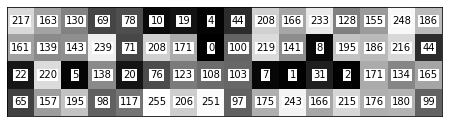

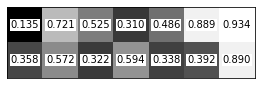

In [28]:
def test_show_grid_values() -> None:
  rng = np.random.default_rng(0)
  show_grid_values(rng.integers(0, 256, size=(4, 16)), figsize=(14, 2), vmin=0, vmax=255)
  show_grid_values(rng.random((2, 7)), figsize=(8, 1.3))


if EFFORT >= 1:
  test_show_grid_values()

In [29]:
def create_checkerboard(
    output_shape: tuple[int, ...], block_shape=(1, 1), dtype=np.float32
) -> _NDArray:
  """Return a grid of alternating blocks of 0 and 1 values.

  >>> array = create_checkerboard((5, 7))
  >>> array.dtype, array.shape, array.sum()
  (dtype('float32'), (5, 7), 17.0)
  """
  indices = np.moveaxis(np.indices(output_shape), 0, -1)
  return ((indices // block_shape).sum(axis=-1) % 2).astype(dtype)

In [30]:
def experiment_preload_arraylibs_for_accurate_timings() -> None:
  """Perform library imports now so that later timings do not include this."""
  for arraylib in resampler.ARRAYLIBS:
    resampler._make_array(np.ones(1), arraylib)


if EFFORT >= 1:
  experiment_preload_arraylibs_for_accurate_timings()

In [31]:
# TODO:
# - instead use default prefilter='trapezoid'.
#   but then even more discontinuous at transition from minification to magnification?  Not really.
# - Optimize the case of an affine map:
#   convolve the source grid with a prefilter using FFT (if any dim is downsampling),
#   then proceed as before.  Slow!
# - For an affine map, create an anisotropic footprint of destination within the source domain.
# - Use jacobian and prefilter in resample().
# - Is lightness-space upsampling justified using experiments on natural images?
#   (is linear-space downsampling justified using such experiments? it should be obvious.)
# - Try [gpu].

In [32]:
# Useful resources:
# https://legacy.imagemagick.org/Usage/filter/

# Library elements

## Array libraries
<a name="Array-libraries"></a>

The [`resize`](#resize-function) and [`resample`](#Resample)
functions operate transparently on multidimensional arrays from several libraries,
listed in `ARRAYLIBS`:

In [33]:
show_var_docstring('resampler.ARRAYLIBS')

**`ARRAYLIBS`** = ['numpy', 'tensorflow', 'torch', 'jax']<br/>Array libraries supported automatically in the resize and resampling operations.

- The library is selected automatically based on the type of the `array` function parameter.

- The class `_Arraylib` provides library-specific implementations of needed basic functions.

- The `_arr_*()` functions dispatch the `_Arraylib` methods based on the array type.

Another array library that we could include is:
- `cupy` (with `cupy.ndarray` and `cupyx.scipy.sparse.csr_matrix`).

We may consider switching to [`eagerpy`](https://github.com/jonasrauber/eagerpy) for cross-library support;
it is more complete but less specialized;
some missing features include:
- Support for `einsum()` using a `str` subscripts argument.
- The equivalent of `_make_sparse_matrix` and `_arr_matmul_sparse_dense`.
- Support for `_make_array(array, arraylib)` and `arr_arraylib(array)`; or use `ep.get_dummy(str)`?
- Alternatively, use of subclassing for extensibility.
- Use of `np.dtype` as a shared standard for `dtype` attributes and `astype(...)` functions.
- Implementations of `moveaxis()` and `swapaxes()` in the base class `eagerpy.Tensor` using `transpose()`.
- Fix of the type signature of `full(shape, value)` to indicate that `value` may be scalar or tensor.

And, [`einops`](https://einops.rocks/) is another nice cross-library interface, but its functionality is focused on `einsum()`.

## Grid-types (dual and primal)
<a name="Grid-types--dual-and-primal-"></a>

Digital signal processing is commonly described with
[samples at integer coordinates](https://en.wikipedia.org/wiki/Sinc_interpolation).
However, this becomes cumbersome when a field is sampled at several resolutions,
for example in an [image pyramid](https://en.wikipedia.org/wiki/Pyramid_(image_processing)).
Indeed, the standard in computer graphics (including GPU hardware) is to let image pixels
correspond to sample points at the center of grid cells, as shown in the
*dual* grid-structure below.
Each pyramid resolution level has a power-of-two number of pixels.
Notably, sample locations are *different* at each resolution level.

The alternative is the *primal* grid structure,
in which samples have a nice nesting property.
However, representing a domain at power-of-two scales requires a
sequence of grids with non-power-of-two samples,
which complicates data structures and algorithms
(e.g. the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)).

We support both grid-types, selectable as either `gridtype='dual'` or `gridtype='primal'`.
To avoid confusion, the `coords` parameter in `resampler.resample()` refers to coordinates
with respect to the unit domain $[0, 1]^d$ rather than the sample lattice $\mathbb{Z}^d$.

In [34]:
show_var_docstring('resampler.GRIDTYPES')

**`GRIDTYPES`** = ['dual', 'primal']<br/>Shortcut names for the two predefined grid types (specified per dimension):

| `gridtype` | `'dual'`<br/>`DualGridtype()`<br/>(default) | `'primal'`<br/>`PrimalGridtype()`<br/>&nbsp; |
| --- |:---:|:---:|
| Sample positions in 2D<br/>and in 1D at different resolutions | ![Dual](https://github.com/hhoppe/resampler/raw/main/media/dual_grid_small.png) | ![Primal](https://github.com/hhoppe/resampler/raw/main/media/primal_grid_small.png) |
| Nesting of samples across resolutions | The samples positions do *not* nest. | The *even* samples remain at coarser scale. |
| Number $N_\ell$ of samples (per-dimension) at resolution level $\ell$ | $N_\ell=2^\ell$ | $N_\ell=2^\ell+1$ |
| Position of sample index $i$ within domain $[0, 1]$ | $\frac{i + 0.5}{N}$ ("half-integer" coordinates) | $\frac{i}{N-1}$ |
| Image resolutions ($N_\ell\times N_\ell$) for dyadic scales | $1\times1, ~~2\times2, ~~4\times4, ~~8\times8, ~\ldots$ | $2\times2, ~~3\times3, ~~5\times5, ~~9\times9, ~\ldots$ |

See the source code for extensibility.

## Boundary rules
<a name="Boundary-rules"></a>

Reconstruction creates a field as a sum of filters
weighted by the sample values.
However, the source samples are within a finite domain grid.

<table><tr>
<td><img src="https://github.com/hhoppe/resampler/raw/main/media/reconstruction_weighted_kernels.png" width="400"/></td>
<td>&emsp;&emsp;&emsp;&emsp;</td>
<td><img src="https://github.com/hhoppe/resampler/raw/main/media/reconstruction.png" width="350"/></td>
</tr></table>

Boundary rules let us define the reconstructed function
both near the domain boundary and beyond it.

For a multidimensional domain $\mathbb{R}^d$,
we can specify a separate boundary rule for each dimension.

Given a point $p=(x_1,\ldots,x_d)\in \mathbb{R}^d$,
the boundary rules affect its reconstructed value $f(p)$ as follows:

1. Optionally remap the coordinate $x_i$ to the domain interior $[0, 1]$.

2. Assign values to exterior grid samples, particularly those whose basis functions overlap
   the domain interior.
   These exterior samples may be assigned linear combinations of interior
   samples and/or some special constant value `cval`.

3. Compute the weighted interpolation $f(p)$.

4. Optionally override the reconstructed function $f(p)$ as an affine combination with the
   special constant value `cval` near or outside the domain boundary.

Steps 1, 2, and 4 are specified by the classes `RemapCoordinates`, `ExtendSamples`,
and `OverrideExteriorValue`, all of which are components of the class `Boundary`.

Here are some [predefined `boundary` settings](#Predefined-boundary-rules):

In [35]:
show_var_docstring('resampler.BOUNDARIES')

**`BOUNDARIES`** = ['reflect', 'wrap', 'tile', 'clamp', 'border', 'natural', 'linear_constant', 'quadratic_constant', 'reflect_clamp', 'constant', 'linear', 'quadratic']<br/>Shortcut names for some predefined boundary rules (as defined by `_DICT_BOUNDARIES`):

| name                   | a.k.a. / comments |
|------------------------|-------------------|
| `'reflect'`            | *reflected*, *symm*, *symmetric*, *mirror*, *grid-mirror* |
| `'wrap'`               | *periodic*, *repeat*, *grid-wrap* |
| `'tile'`               | like `'reflect'` within unit domain, then tile discontinuously |
| `'clamp'`              | *clamped*, *nearest*, *edge*, *clamp-to-edge*, repeat last sample |
| `'border'`             | *grid-constant*, use `cval` for samples outside unit domain |
| `'natural'`            | *renormalize* using only interior samples, use `cval` outside domain |
| `'reflect_clamp'`      | *mirror-clamp-to-edge* |
| `'constant'`           | like `'reflect'` but replace by `cval` outside unit domain |
| `'linear'`             | extrapolate from 2 last samples |
| `'quadratic'`          | extrapolate from 3 last samples |
| `'linear_constant'`    | like `'linear'` but replace by `cval` outside unit domain |
| `'quadratic_constant'` | like `'quadratic'` but replace by `cval` outside unit domain |

These boundary rules may be specified per dimension.  See the source code for extensibility
using the classes `RemapCoordinates`, `ExtendSamples`, and `OverrideExteriorValue`.

**Boundary rules illustrated in 1D:**

<center>
<img src="https://github.com/hhoppe/resampler/raw/main/media/boundary_rules_in_1D.png" width="100%"/>
</center>

**Boundary rules illustrated in 2D:**

<center>
<img src="https://github.com/hhoppe/resampler/raw/main/media/boundary_rules_in_2D.png" width="100%"/>
</center>

## Filter kernels
<a name="Filter-kernels"></a>

Let us assume a dual grid in 1D, i.e. a domain $[0, 1]$ with sample values $a_i$ at positions $\frac{i+0.5}{N}$, $0\leq i < N$.

The reconstructed field
$f(x) = \sum_{i\in\mathbb{Z}} \,a_i\, \phi((x-(i+0.5))\cdot N)$
is a sum of the grid samples $\{a_i\}$ weighted by a reconstruction
[*filter kernel*](https://en.wikipedia.org/wiki/Kernel_(statistics))
$\phi$.
<!-- (A kernel is a [window function](https://en.wikipedia.org/wiki/Window_function),
i.e., it has value zero outside of some some radius.) -->

The [Nyquist-Shannon sampling
theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)
states that a function $f$ is exactly reconstructed
from its samples $a_i = f(\frac{i+0.5}{N})$ if $\phi(x)$ is the
[*sinc function*](https://en.wikipedia.org/wiki/Sinc_function)
$\text{sinc}(x) = \frac{sin(\pi x)}{\pi x}$
and $f$ has no frequencies higher than $2N$, i.e., twice the sample rate $N$.

Because the sinc function has infinite support,
in practice it is approximated by multiplying it with a window function $w(x)$.
A frequently used approximation is the
[Lanczos filter](https://en.wikipedia.org/wiki/Lanczos_resampling),
whose radius parameter trades off speed and accuracy.

A filter kernel is also used to prefilter the reconstructed field prior to sampling.
By default, we assign this filter to be the same as the reconstruction filter.

All multidimensional filters are assumed to be separable.
For rotation equivariance (e.g., bandlimit the signal uniformly in all directions),
it would be nice to support the (non-separable) 2D rotationally symmetric
[sombrero function](https://en.wikipedia.org/wiki/Sombrero_function)
$f(\textbf{x}) = \text{jinc}(\|\textbf{x}\|)$,
where $\text{jinc}(r) = 2J_1(\pi r)/(\pi r)$.
(The Fourier transform of a circle
[involves the first-order Bessel function of the first kind](https://en.wikipedia.org/wiki/Airy_disk).)

In [36]:
show_var_docstring('resampler.FILTERS')

**`FILTERS`** = ['impulse', 'box', 'trapezoid', 'triangle', 'cubic', 'sharpcubic', 'lanczos3', 'lanczos5', 'lanczos10', 'cardinal3', 'cardinal5', 'omoms3', 'omoms5', 'hamming3', 'kaiser3', 'gaussian', 'bspline3', 'mitchell', 'narrowbox']<br/>Shortcut names for some predefined filter kernels (specified per dimension).
The names expand to:

| name           | `Filter`                      | a.k.a. / comments |
|----------------|-------------------------------|-------------------|
| `'impulse'`    | `ImpulseFilter()`             | *nearest* |
| `'box'`        | `BoxFilter()`                 | non-antialiased box, e.g. ImageMagick |
| `'trapezoid'`  | `TrapezoidFilter()`           | *area* antialiasing, e.g. `cv.INTER_AREA` |
| `'triangle'`   | `TriangleFilter()`            | *linear*  (*bilinear* in 2D), spline `order=1` |
| `'cubic'`      | `CatmullRomFilter()`          | *catmullrom*, *keys*, *bicubic* |
| `'sharpcubic'` | `SharpCubicFilter()`          | `cv.INTER_CUBIC`, `torch 'bicubic'` |
| `'lanczos3'`   | `LanczosFilter`(radius=3)     | support window [-3, 3] |
| `'lanczos5'`   | `LanczosFilter`(radius=5)     | [-5, 5] |
| `'lanczos10'`  | `LanczosFilter`(radius=10)    | [-10, 10] |
| `'cardinal3'`  | `CardinalBsplineFilter`(degree=3) | *spline interpolation*, `order=3`, *GF* |
| `'cardinal5'`  | `CardinalBsplineFilter`(degree=5) | *spline interpolation*, `order=5`, *GF* |
| `'omoms3'`     | `OmomsFilter`(degree=3)       | non-$C^1$, [-3, 3], *GF* |
| `'omoms5'`     | `OmomsFilter`(degree=5)       | non-$C^1$, [-5, 5], *GF* |
| `'hamming3'`   | `GeneralizedHammingFilter`(...) | (radius=3, a0=25/46) |
| `'kaiser3'`    | `KaiserFilter`(radius=3.0, beta=7.12) | |
| `'gaussian'`   | `GaussianFilter()`            | non-interpolating, default $\sigma=1.25/3$ |
| `'bspline3'`   | `BsplineFilter`(degree=3)     | non-interpolating |
| `'mitchell'`   | `MitchellFilter()`            | *mitchellcubic* |
| `'narrowbox'`  | `NarrowBoxFilter()`           | for visualization of sample positions |

The comment label *GF* denotes a [generalized filter](https://hhoppe.com/proj/filtering/), formed
as the composition of a finitely supported kernel and a discrete inverse convolution.

**Some example filter kernels:**

<center>
<img src="https://github.com/hhoppe/resampler/raw/main/media/filter_summary.png" width="100%"/>
</center>

<br/>A more extensive set of filters is presented [here](#plots_of_filters) in the
[notebook](https://colab.research.google.com/github/hhoppe/resampler/blob/main/resampler_notebook.ipynb),
together with visualizations and analyses of the filter properties.
See the source code for extensibility.

The `'trapezoid'` filter is an antialiased version of the `'box'` filter.
Its implementation is special in that its parameterized shape (edge slope)
is made to adapt to the scaling factor in a `resize` operation.

[Experiments](#Best-filter-for-resize) show that `'lanczos3'` is generally an effective filter,
except when *downsampling vector graphics content*,
in which case the `'trapezoid'` filter is favored because it minimizes
[*ringing*](https://en.wikipedia.org/wiki/Ringing_artifacts) artifacts.

## Gamma correction
<a name="Gamma-correction"></a>

Quantized values (e.g., `uint8`) often lack sufficient precision,
causing [banding](https://en.wikipedia.org/wiki/Color_banding) artifacts in images.
To reduce this problem, it is common to transform physical ("linear-space") intensities $l$
to more perceptual ("lightness space") values $e$
using a nonlinear transfer function
(a.k.a. [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction)\)
prior to quantization.

Here are the predefined schemes:

In [37]:
show_var_docstring('resampler.GAMMAS')

**`GAMMAS`** = ['identity', 'power2', 'power22', 'srgb']<br/>Shortcut names for some predefined gamma-correction schemes:

| name | `Gamma` | Decoding function<br/> (linear space from stored value) | Encoding function<br/> (stored value from linear space) |
|---|---|:---:|:---:|
| `'identity'` | `IdentityGamma()` | $l = e$ | $e = l$ |
| `'power2'` | `PowerGamma`(2.0) | $l = e^{2.0}$ | $e = l^{1/2.0}$ |
| `'power22'` | `PowerGamma`(2.2) | $l = e^{2.2}$ | $e = l^{1/2.2}$ |
| `'srgb'` | `SrgbGamma()` | $l = \left(\left(e + 0.055\right) / 1.055\right)^{2.4}$ | $e = l^{1/2.4} * 1.055 - 0.055$ |

See the source code for extensibility.

(`'srgb'` corresponds to the [sRGB](https://en.wikipedia.org/wiki/SRGB) standard
and its encoding function includes an additional linear map segment near zero.)

For grids with data type `uint8`, the default is `gamma='power2'`
(chosen for its tradeoff of accuracy and efficiency).
Therefore, we square the values when converting them to floating-point, perform resampling,
and take the square-root before quantizing the values back to `uint8`.

For other data types, the default transfer function is `gamma='identity'`.

## Resize
<a name="Resize"></a>

In [38]:
hh.pdoc_help(resampler.resize)
hh.no_vertical_scroll()

Because the reconstruction and prefilter kernels are assumed to be separable functions,
we implement multidimensional resizing by iteratively modifying the sampling resolution
along one dimension at a time.
The order of these 1D resize operations does not affect the final result
(up to machine precision), but it affects total execution time.

In [39]:
hh.pdoc_help(resampler.resize_in_arraylib)

In [40]:
hh.pdoc_help(resampler.jaxjit_resize)

In [41]:
# display_markdown(resampler.resize.__doc__)  # It omits the function parameters and defaults.

In [42]:
if 0:  # For testing.
  resampler.resize = typing.cast(
      Any, functools.partial(resampler._resize_possibly_in_arraylib, arraylib='torch')
  )
  # Note: resize() in jax may return a non-writable np.ndarray, and consequently torch may warn
  # "The given NumPy array is not writable, and PyTorch does not support non-writable tensors".

In [43]:
def resize_showing_domain_boundary(
    array: _NDArray, shape, *, scale=0.6, translate=0.2, **kwargs
) -> _NDArray:
  array = np.asarray(resampler.resize(array, shape, scale=scale, translate=translate, **kwargs))
  yx_low = (np.array(shape) * translate + 0.5).astype(int)
  yx_high = (np.array(shape) * (translate + scale) + 0.5).astype(int)
  yx = np.indices(shape)
  conditions = [
      ((t == l) | (t == h)) & (t2 >= l2) & (t2 <= h2)
      for t, l, h, t2, l2, h2 in zip(yx, yx_low, yx_high, yx[::-1], yx_low[::-1], yx_high[::-1])
  ]
  on_boundary = np.logical_or.reduce(conditions)
  line_color = np.mod(yx.sum(axis=0), 8) < 4  # Dashed black-and-white line.
  array = np.where(on_boundary, line_color.T, array.T).T
  return array

In [44]:
def visualize_filters_on_checkerboard(src_shape=(12, 8), boundary='wrap') -> None:
  original = create_checkerboard(src_shape)
  for dst_shape in [(11, 7), (9, 6), (7, 5), (6, 4), (5, 3), (15, 14)]:
    filters = 'impulse box trapezoid triangle cubic lanczos3 lanczos5 lanczos10'.split()
    display_markdown(
        f'Resizing checkerboard from shape `{src_shape}`'
        f" to `{dst_shape}` with boundary=`'{boundary}'`:"
    )
    images = {
        f"'{filter}'": resampler.resize(original, dst_shape, filter=filter, boundary=boundary)
        for filter in filters
    }
    images = {'original': original} | images
    media.show_images(images, border=True, vmin=0, vmax=1, width=64)


if EFFORT >= 1:
  visualize_filters_on_checkerboard()

Resizing checkerboard from shape `(12, 8)` to `(11, 7)` with boundary=`'wrap'`:

Resizing checkerboard from shape `(12, 8)` to `(9, 6)` with boundary=`'wrap'`:

Resizing checkerboard from shape `(12, 8)` to `(7, 5)` with boundary=`'wrap'`:

Resizing checkerboard from shape `(12, 8)` to `(6, 4)` with boundary=`'wrap'`:

Resizing checkerboard from shape `(12, 8)` to `(5, 3)` with boundary=`'wrap'`:

Resizing checkerboard from shape `(12, 8)` to `(15, 14)` with boundary=`'wrap'`:

## Resample
<a name="Resample"></a>

In [45]:
hh.pdoc_help(resampler.resample)
hh.no_vertical_scroll()

In [46]:
hh.pdoc_help(resampler.resample_affine)
hh.no_vertical_scroll()

In [47]:
hh.pdoc_help(resampler.rotation_about_center_in_2d)

In [48]:
hh.pdoc_help(resampler.rotate_image_about_center)

In [49]:
# General resample:
# Jacobian matrix: of the parametric map from destination pixel coordinates to source pixel
# coordinates.
# Desirable to adjust in 2 ways:
# (1) orthogonalize the column vectors, to avoid interference-pattern artifacts due to
#   interference of x and y kernels with negative lobes.
# (2) if either column vector has norm less than 1, indicating upsampling in that direction,
#   the vector should be normalized so that the filter kernel acts as reconstruction rather
#   than prefiltering.

In [50]:
# Samples the color at a destination image pixel (x, y) given the 'location' (u, v) in a source
# image and the 2x2 Jacobian matrix of the map from the destination to the source:
#
#     [du/dx, du/dy]
#     [dv/dx, dv/dy]
#
# Thus, the two columns of the Jacobian matrix represent the preimages in the source of the
# destination image's unit axis vectors.  I.e., if the norm of the first column is less than 1,
# then the resampling operation from source to destination performs upsampling along the X axis of
# the destination image.  Internally, the column vectors of the Jacobian are orthogonalized and
# rescaled as desired for sampling if the options.adjust_jacobian is set to True.

In [51]:
# Currently we cannot apply jax.jit to resampler.resample() because the `coords` argument is
# processed using numpy and therefore cannot be differentiated.
# Also, because `coords` is an array it cannot be marked as a static argument.
# We could allow `coords` to be a general `_Array` type;
# this would involve generalizing the code in the Boundary and Filter classes?

In [52]:
def test_profile_resample() -> None:
  def run(src_shape, dst_shape) -> None:
    hh.prun(lambda: resampler._resize_using_resample(np.ones(src_shape), dst_shape), top=5)

  run((8192,) * 2 + (3,), (2048,) * 2)
  run((1024,) * 2 + (3,), (2048,) * 2)


if EFFORT >= 2:
  test_profile_resample()
# The bottleneck is the memory gather:
# Prun: tottime    3.441 overall_cumtime
#         1.694    1.694 getitem (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:345)
#         0.398    0.398 numpy.core._multiarray_umath.c_einsum (built-in)
#         0.361    0.361 ones (numpy/core/numeric.py:136)
#         0.279    3.007 resample (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:2956)
#         0.185    0.247 interpolate_using_cached_samples (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:158)
# Prun: tottime    2.986 overall_cumtime
#         1.659    1.659 getitem (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:345)
#         0.384    0.384 numpy.core._multiarray_umath.c_einsum (built-in)
#         0.280    2.936 resample (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:2956)
#         0.182    0.245 interpolate_using_cached_samples (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:158)
#         0.128    0.128 numpy.ufunc.reduce

In [53]:
if 0:  # For testing.
  resampler.resize = typing.cast(
      Any, functools.partial(resampler._resize_using_resample, fallback=True)
  )

# Tests

In [54]:
def test_cached_sampling_of_1d_function(radius=2.0) -> None:
  def func(x: _ArrayLike) -> _NDArray:  # Lanczos kernel
    x = np.abs(x)
    return np.where(x < radius, resampler._sinc(x) * resampler._sinc(x / radius), 0.0)

  @resampler._cache_sampled_1d_function(xmin=-radius, xmax=radius)
  def func2(x: _ArrayLike) -> _NDArray:
    return func(x)

  def create_scipy_interpolator(  # (Legacy interpolator.)
      func, xmin, xmax, num_samples=3_600
  ) -> Callable[[_NDArray], _NDArray]:
    samples_x = np.linspace(xmin, xmax, num_samples + 1, dtype=np.float32)
    samples_func = func(samples_x)
    assert np.all(samples_func[[0, -1]] == 0.0)
    interpolator: Callable[[_NDArray], _NDArray] = scipy.interpolate.interp1d(
        samples_x, samples_func, kind='linear', bounds_error=False, fill_value=0
    )
    return interpolator

  scipy_interp = create_scipy_interpolator(func, -radius, radius)

  def create_np_interpolator(func, xmin, xmax, num_samples=3_600) -> Callable[[_NDArray], _NDArray]:
    samples_x = np.linspace(xmin, xmax, num_samples + 1, dtype=np.float32)
    samples_func = func(samples_x)
    assert np.all(samples_func[[0, -1]] == 0.0)

    def evaluate(array: _NDArray) -> _NDArray:
      return np.interp(array, samples_x, samples_func).astype(np.float32)

    return evaluate

  np_interp = create_np_interpolator(func, -radius, radius)

  shape = 2, 8_000
  rng = np.random.default_rng(0)
  array = rng.random(shape, np.float32) * 2 * radius - radius
  result = {
      'expected': func(array),
      'scipy': scipy_interp(array),
      'np_interp': np_interp(array),
      'obtained': func2(array),
  }

  assert all(a.dtype == np.float32 for a in result.values())
  assert all(a.shape == shape for a in result.values())
  assert np.allclose(result['scipy'], result['expected'], rtol=0, atol=1e-6)
  assert np.allclose(result['np_interp'], result['expected'], rtol=0, atol=1e-6)
  assert np.allclose(result['obtained'], result['expected'], rtol=0, atol=1e-6)

  if 0:
    shape = 2000, 2000
    array = rng.random(shape) * 8.0 - 4.0
    hh.print_time(lambda: func(array))
    hh.print_time(lambda: func2(array))
    # 154 ms
    # 28.6 ms
    hh.prun(lambda: func2(array), top=4)  # The bottleneck is the array lookup.
    # Prun: tottime    0.038 overall_cumtime
    #         0.030    0.038 interpolate_using_cached_samples (/tmp/ipykernel:16)
    #         0.006    0.006 _clip_dep_invoke_with_casting (numpy/core/_methods.py:106)
    #         0.003    0.003 numpy.ndarray.astype
    #         0.000    0.000 _clip_dep_is_scalar_nan (numpy/core/_methods.py:91)


test_cached_sampling_of_1d_function()

In [55]:
def test_profile_downsample_in_2d_using_box_filter(shape=(512, 512)) -> None:
  array = np.ones((4096, 4096))
  hh.print_time(lambda: resampler._downsample_in_2d_using_box_filter(array, shape), max_time=0.4)


if using_numba:
  test_profile_downsample_in_2d_using_box_filter()
# 3.43 ms

614 ms


In [56]:
def test_that_very_large_cval_causes_numerical_noise_to_appear(debug: bool = False) -> None:
  resize_matrix, _ = resampler._create_resize_matrix(
      2,
      3,
      src_gridtype=resampler.DualGridtype(),
      dst_gridtype=resampler.DualGridtype(),
      boundary=resampler._get_boundary('linear_constant'),
      filter=resampler.CatmullRomFilter(),
  )
  diff = resize_matrix.toarray().sum(axis=-1) - 1.0
  if debug:
    print(diff)  # [8.8817842e-16 0.0000000e+00 8.8817842e-16]
  assert 1e-17 < abs(diff).max() < 1e-15
  # The observation is that this small but nonzero error (non-affinity) due to numerical noise
  # becomes greatly amplified if we were to set cval=1e20.


test_that_very_large_cval_causes_numerical_noise_to_appear()

In [57]:
def test_jax_jit_digital_filter() -> None:
  jitted = jax.jit(resampler._apply_digital_filter_1d, static_argnums=(1, 2, 3, 4, 5, 6))
  array = jnp.ones((5,))
  # pylint: disable-next=not-callable
  result = jitted(
      array,
      resampler._get_gridtype('dual'),
      resampler._get_boundary('reflect'),
      0.0,
      resampler._get_filter('cardinal3'),
  )
  del result


if 0:  # Fails because resampler._apply_digital_filter_1d() is not jax-traceable.
  test_jax_jit_digital_filter()

In [58]:
def test_apply_digital_filter_1d_quick() -> None:
  for boundary in 'reflect linear border'.split():

    def inverse_convolution(array: resampler._Array) -> resampler._Array:
      return resampler._apply_digital_filter_1d(
          array,
          resampler._get_gridtype('dual'),
          resampler._get_boundary(boundary),
          20.0,
          resampler._get_filter('cardinal3'),
      )

    array_np = np.array([1.0, 2.0, 5.0, 7.0], np.float32)
    reference = inverse_convolution(array_np)

    for arraylib in [a for a in resampler.ARRAYLIBS if a != 'numpy']:
      array = resampler._make_array(array_np, arraylib)
      result = resampler._arr_numpy(inverse_convolution(array))
      assert np.allclose(result, reference)

    shape = 5, 7
    array2_np = np.random.default_rng(0).random(shape, np.float64)
    array2 = torch.tensor(array2_np, requires_grad=True)
    assert torch.autograd.gradcheck(inverse_convolution, [array2], rtol=0, atol=1e-6), boundary


if EFFORT >= 1:
  test_apply_digital_filter_1d_quick()

In [59]:
def test_order_of_dimensions_does_not_affect_resize_results(step=3) -> None:
  shapes = [(3, 4, 5), (3, 2, 4), (6, 2, 2), (1, 1, 1)]
  gridtypes = resampler.GRIDTYPES
  boundaries = 'reflect tile border natural linear_constant'.split()
  filters = 'impulse box trapezoid lanczos3'.split()
  sequences: list[Sequence[Any]] = [shapes, shapes, gridtypes, gridtypes, boundaries, filters]
  assert step == 1 or all(len(sequence) % step != 0 for sequence in sequences)
  configs = itertools.product(*sequences)  # len(configs) = math.prod([4, 4, 2, 2, 5, 4]) = 1280.
  for config in itertools.islice(configs, 0, None, step):
    src_shape, dst_shape, src_gridtype, dst_gridtype, boundary, filter = config
    if (src_gridtype == 'primal' and min(src_shape) < 2) or (
        dst_gridtype == 'primal' and min(dst_shape) < 2
    ):
      continue
    array = np.random.default_rng(0).random(src_shape)
    reference = None
    for dim_order in itertools.permutations(range(3)):
      result = resampler.resize(
          array,
          dst_shape,
          src_gridtype=src_gridtype,
          dst_gridtype=dst_gridtype,
          boundary=boundary,
          filter=filter,
          dim_order=dim_order,
      )
      if reference is None:
        reference = result
      else:
        assert np.allclose(result, reference), config


if EFFORT >= 1:
  test_order_of_dimensions_does_not_affect_resize_results()

In [60]:
def test_apply_resize_to_batch_of_images(
    num_images=10, shape=(32, 32), new_shape=(128, 128), debug=False
) -> None:
  for arraylib in resampler.ARRAYLIBS:
    batch_of_images = media.moving_circle(shape, num_images=num_images)
    batch_of_images = resampler._make_array(batch_of_images, arraylib)
    _check_eq(batch_of_images.shape, (num_images, *shape, 3))
    new_batch = resampler._arr_numpy(
        resampler._original_resize(batch_of_images, (num_images, *new_shape))
    )
    _check_eq(new_batch.shape, (num_images, *new_shape, 3))
    if debug:
      media.show_video(new_batch, fps=5)


if EFFORT >= 1:
  test_apply_resize_to_batch_of_images()

In [61]:
def test_resample_scenario1() -> None:
  """Resample a grayscale image with `array.shape = height, width` onto a new grayscale image
  with `new.shape = height2, width2` by using `coords.shape = height2, width2, 2`."""
  array = [[25, 75], [25, 75]]
  coords = (np.moveaxis(np.indices((4, 4)), 0, -1) + 0.5) / 4
  new = resampler.resample(array, coords, filter='triangle')
  assert np.allclose(new, [[25, 38, 63, 75]] * 4)


def test_resample_scenario2() -> None:
  """Resample an RGB image with `array.shape = height, width, 3` onto a new RGB image with
  `new.shape = height2, width2, 3` by using `coords.shape = height2, width2, 2`."""
  array = [[[25, 125, 225], [75, 175, 275]], [[25, 125, 225], [75, 175, 275]]]  #
  coords = (np.moveaxis(np.indices((4, 4)), 0, -1) + 0.5) / 4
  new = resampler.resample(array, coords, filter='triangle')
  assert np.allclose(new, [[[25, 125, 225], [38, 138, 238], [63, 163, 263], [75, 175, 275]]] * 4)


def test_resample_scenario3() -> None:
  """Sample an RGB image at `num` 2D points along a line segment by using
  `coords.shape = num, 2`."""
  array = [[[10, 10, 10], [100, 10, 10]], [[20, 200, 20], [80, 80, 80]]]  #
  coords = [[0.2, 0.2], [0.3, 0.5], [0.4, 0.8]]
  new = resampler.resample(array, coords, filter='triangle')
  assert np.allclose(new, [[10, 10, 10], [55, 23, 14], [94, 31, 31]])


def test_resample_scenario4() -> None:
  """Sample an RGB image at a single 2D point by using `coords.shape = (2,)`."""
  array = [[[10, 10, 10], [100, 10, 10]], [[20, 200, 20], [80, 80, 80]]]  #
  new = resampler.resample(array, (0.25, 0.25))
  assert np.allclose(new, [10, 10, 10])


def test_resample_scenario5() -> None:
  """Sample a 3D grid of 3x3 Jacobians with `array.shape = nz, ny, nx, 3, 3` along a 2D plane
  by using `coords.shape = height, width, 3`."""
  array = np.random.default_rng(0).random((2, 2, 2, 3, 3))
  coords = np.random.default_rng(0).random((2, 2, 3))
  new = resampler.resample(array, coords)
  _check_eq(new.shape, (2, 2, 3, 3))


def test_resample_scenario6() -> None:
  """Map a grayscale image through a color map by using `array.shape = 256, 3` and
  `coords.shape = height, width`."""
  array = [1000, 1100, 1400, 2000]
  coords = [[[0.1], [0.3]], [[0.7], [0.9]]]  #
  new = resampler.resample(array, coords)
  assert np.allclose(new, [[998, 1060], [1583, 2040]])


test_resample_scenario1()
test_resample_scenario2()
test_resample_scenario3()
test_resample_scenario4()
test_resample_scenario5()
test_resample_scenario6()

In [62]:
def test_that_all_resize_and_resample_agree(shape=(3, 2, 2), new_shape=(4, 2, 4)) -> None:
  assert np.all(np.array(new_shape) >= np.array(shape))
  scale = 1.1
  translate = -0.4, -0.03, 0.4
  # Sublists of resampler.ARRAYLIBS, resampler.BOUNDARIES, resampler.FILTERS, and resampler.GAMMAS.
  arraylibs = [arraylib for arraylib in resampler.ARRAYLIBS if arraylib != 'numpy']
  dtypes = 'float32 uint8 complex64 complex128 int32 uint32 float64'.split()
  boundaries = 'border clamp quadratic reflect wrap'.split()
  filters = 'box bspline3 impulse lanczos3 narrowbox triangle cardinal3 omoms5'.split()
  gammas = 'identity power2'.split()
  sequences = [arraylibs, dtypes, resampler.GRIDTYPES, boundaries, filters, gammas]
  configs = itertools.product(*sequences)  # len(configs) = math.prod([4, 7, 5, 8, 2]) = 2240.
  step = 1 if EFFORT >= 2 else 73
  assert step == 1 or all(len(sequence) % step != 0 for sequence in sequences)
  for config in itertools.islice(configs, 0, None, step):
    arraylib, dtype, gridtype, boundary, filter, gamma = config
    if gamma != 'identity' and not (
        dtype in ['float32', 'uint8'] and boundary == 'reflect' and filter == 'lanczos3'
    ):
      continue
    if arraylib == 'torch' and dtype == 'uint32':
      continue  # "The only supported types are: ..., int64, int32, int16, int8, uint8, and bool."
    atol = {
        'float32': 2e-5,
        'float64': 1e-12,
        'complex64': 2e-5,
        'complex128': 1e-12,
        'uint8': 1,
        'uint32': 1,
        'int32': 1,
    }[dtype]
    np_dtype = np.dtype(dtype)
    rng = np.random.default_rng(0)
    array = (
        rng.integers(256, size=shape, dtype=np_dtype)
        if np.issubdtype(np_dtype, np.integer)
        else rng.random(shape).astype(np_dtype)
    )
    yx = np.moveaxis(np.indices(new_shape), 0, -1)
    coords = (yx + 0.5) / new_shape if gridtype == 'dual' else yx / (np.array(new_shape) - 1)
    coords = (coords - translate) / scale
    kwargs: Any = dict(gridtype=gridtype, boundary=boundary, filter=filter, gamma=gamma)
    resize_kwargs = dict(scale=scale, translate=translate, **kwargs)
    resized = resampler.resize_in_numpy(array, new_shape, **resize_kwargs)
    array2 = resampler._make_array(array, arraylib)
    resized2 = resampler.resize(array2, new_shape, **resize_kwargs)
    resampled2 = resampler.resample(array2, coords, **kwargs)
    _check_eq(resampler._arr_arraylib(resized), 'numpy')
    assert resampler._arr_arraylib(resized2) == resampler._arr_arraylib(resampled2) == arraylib
    _arr_dtype = resampler._arr_dtype
    assert resized.dtype == _arr_dtype(resized2) == _arr_dtype(resampled2) == np_dtype
    assert np.allclose(resized2, resized, rtol=0, atol=atol), config
    assert np.allclose(resampled2, resized, rtol=0, atol=atol), config


if EFFORT >= 1:
  # hh.prun(lambda: test_that_all_resize_and_resample_agree(), mode='full')
  test_that_all_resize_and_resample_agree()  # ~5.5 s on 1st run due to jax compiles; then ~450 ms.

# Other libs (PIL, cv, tf, torch, ...)

**PIL.Image.resize:**

In [63]:
# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize
#  resample=PIL.Image.Resampling.NEAREST  # or BOX, BILINEAR, BICUBIC, HAMMING, LANCZOS.
#  Only 2D float image or 2D 3-or-4-channel uint8 image.
#  Undocumented boundary rule is 'natural'.
#  Undocumented Lanczos has radius=3 and seems imperfectly normalized.
#  Only dual grid.

In [64]:
def test_pil_image_resize() -> None:
  at_boundaries = [False, True]
  gridscales = [3.7, 2.0, 1.0, 0.5, 0.41]
  filters = 'impulse box triangle hamming1 cubic lanczos3'.split()
  for config in itertools.product(at_boundaries, gridscales, filters):
    at_boundary, gridscale, filter = config
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, np.float32)
    shape = (int(original.shape[0] * gridscale),)
    result = resampler.pil_image_resize(original, shape, filter=filter)
    reference = resampler.resize(original, shape, filter=filter, boundary='natural')
    atol = 2e-7 if gridscale in (2.0, 1.0, 0.5) else 3e-6
    assert np.allclose(result, reference, rtol=0, atol=atol), (config, result, reference)


test_pil_image_resize()

In [65]:
def test_undocumented_lanczos_in_pil_image() -> None:
  array = np.array([0, 0, 0, 1, 0, 0, 0], np.float32)
  new_len = len(array) * 2
  new_array = resampler.pil_image_resize(array, (new_len,), filter='lanczos3')
  lanczos = resampler.resize(
      array, (new_len,), filter=resampler.LanczosFilter(radius=3), boundary='natural'
  )
  assert np.allclose(new_array, lanczos)

  new_array = resampler.pil_image_resize(array, (new_len,), filter='cubic')
  cubic = resampler.resize(array, (new_len,), filter='cubic', boundary='natural')
  assert np.allclose(new_array, cubic)


if EFFORT >= 1:
  test_undocumented_lanczos_in_pil_image()
# Conclusions: their filter is indeed Lanczos with radius 3, and their boundary rule is 'natural'.

**cv.resize:**

In [66]:
# https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
# https://docs.opencv.org/master/da/d6e/tutorial_py_geometric_transformations.html
# https://github.com/opencv/opencv/blob/master/modules/imgproc/src/resize.cpp
# mode=cv.INTER_LINEAR  # or NEAREST, AREA, CUBIC, LANCZOS4 (r=4).
# Boundary is found empirically to be 'clamp'.
# The CUBIC is sharpcubic.
# Only 2D domain.
# Only good downsampling prefilter is AREA, which is not too bad.

In [67]:
def test_cv_resize() -> None:
  at_boundaries = [False, True]
  gridscales = [2.0, 1.0, 0.5]
  filters = 'impulse triangle trapezoid sharpcubic lanczos4'.split()
  for config in itertools.product(at_boundaries, gridscales, filters):
    at_boundary, gridscale, filter = config
    if gridscale < 1.0 and filter != 'trapezoid':
      continue  # Downsampling is not behaving well except with AREA filter.
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, np.float32)
    shape = (int(original.shape[0] * gridscale),)
    result = resampler.cv_resize(original, shape, filter=filter)
    filter2: Any = resampler.LanczosFilter(radius=4) if filter == 'lanczos4' else filter
    reference = resampler.resize(original, shape, filter=filter2, boundary='clamp')
    atol = 5e-6 if filter == 'lanczos4' else 2e-7
    assert np.allclose(result, reference, rtol=0, atol=atol), (config, result, reference)


test_cv_resize()

In [68]:
def test_sharper_cubic_filter_in_opencv(debug=False) -> None:
  """Confirm that the OpenCV "cubic" is in fact the 'sharpcubic' filter."""
  # https://github.com/opencv/opencv/blob/master/modules/imgproc/src/resize.cpp#L908
  # const float A = -0.75f;
  array = np.array([0, 0, 0, 0, 1, 0, 0, 0], np.float32)
  new_len = len(array) * 2
  reference = resampler.resize(array, (new_len,), filter='sharpcubic')
  new_array = resampler.cv_resize(array, (new_len,), filter='sharpcubic')
  if debug:
    with np.printoptions(linewidth=300):
      print(np.vstack([reference, new_array]))
  assert np.allclose(new_array, reference, rtol=0, atol=1e-7)


if EFFORT >= 2:
  test_sharper_cubic_filter_in_opencv()

**scipy.ndimage.map_coordinates:**

In [69]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
#  Uses FFT.  Assumes that signal is periodic.

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html
# https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html#ndimage-interpolation-modes
#  mode='constant'  # or 'reflect', 'nearest', 'mirror', 'wrap', 'grid-wrap',
#                   #  'grid-constant'; grid-* are correct for dual sampling.
#  cval=0  # used for 'constant'.
#  order=3  # cardinal spline interpolation order (0..5), (3=cubic).
#  Only filter is cardinal spline.
#  See cardinal spline digital prefilter in
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.spline_filter.html
#  Boundary conditions are the same for all dimensions.
#  No prefilter for antialiasing.
#  (Their 'prefilter' is the B-spline digital prefilter).

In [70]:
def test_scipy_ndimage_resize() -> None:
  boundaries = 'reflect wrap clamp border'.split()
  at_boundaries = [False, True]
  gridscales = [2.0, 13 / 8, 1.0, 0.5]
  filters = 'box triangle cardinal3 cardinal5'.split()
  for config in itertools.product(boundaries, at_boundaries, gridscales, filters):
    boundary, at_boundary, gridscale, filter = config
    if gridscale < 1.0:
      continue  # Downsampling is aliased because there is no prefilter.
    if boundary in ['clamp', 'border'] and filter.startswith('cardinal'):
      continue  # The inverse-convolution prefilter is not well-defined in these cases.
    if boundary in ['border'] and filter in ['box', 'triangle']:
      continue  # It produces seemingly incorrect results.
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, np.float32)
    shape = (int(original.shape[0] * gridscale),)
    result = resampler.scipy_ndimage_resize(original, shape, filter=filter, boundary=boundary)
    reference = resampler.resize(original, shape, filter=filter, boundary=boundary)
    assert np.allclose(result, reference, rtol=0, atol=2e-6), (config, result, reference)


test_scipy_ndimage_resize()

**skimage.transform.resize:**

In [71]:
# https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#  mode='reflect'  # or 'constant', 'edge', 'symmetric' (for dual), 'wrap'.
#  cval=0  # used for 'constant'.
#  order=1  # spline interpolation order (0..5), (3='cardinal3')
#  anti_aliasing=None  # automatically apply Gaussian prefilter prior to downsampling.

In [72]:
def test_skimage_transform_resize() -> None:
  skimage_version_string = skimage.__version__  # type: ignore[attr-defined]
  skimage_version = tuple(int(num) for num in skimage_version_string.split('.'))
  if skimage_version < (0, 19):
    return  # There exist errors, likely due to boundary rules.
  boundaries = 'reflect wrap clamp border'.split()
  at_boundaries = [False, True]
  gridscales = [2.0, 13 / 8, 1.0, 0.5]
  filters = 'box triangle cardinal3 cardinal5'.split()
  for config in itertools.product(boundaries, at_boundaries, gridscales, filters):
    boundary, at_boundary, gridscale, filter = config
    if gridscale < 1.0:
      continue  # Downsampling is poor due to the Gaussian prefilter.
    if boundary in ['clamp', 'border'] and filter.startswith('cardinal'):
      continue  # The inverse-convolution prefilter is not well-defined in these cases.
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, np.float32)
    shape = (int(original.shape[0] * gridscale),)
    result = resampler.skimage_transform_resize(original, shape, filter=filter, boundary=boundary)
    reference = resampler.resize(original, shape, filter=filter, boundary=boundary)
    assert np.allclose(result, reference, rtol=0, atol=2e-6), (config, result, reference)


test_skimage_transform_resize()

**tf.image.resize:**

In [73]:
# https://www.tensorflow.org/api_docs/python/tf/image/resize
# It is differentiable.
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/image_ops_impl.py#L1549
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/sampling_kernels.h
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/scale_and_translate_op.cc
# The sparse matrix multiply is in GatherRows() then GatherColumns().
#  method='bilinear'  # or 'area', 'bicubic', 'gaussian', 'lanczos3',
#                     #   'lanczos5', 'mitchellcubic', 'nearest'.
#  Only 2D domain; only boundary rule is 'natural' (IgnoreOutside); only dual (half-integer) grid.

In [74]:
def test_tf_image_resize(debug=False) -> None:
  # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/resize_area_op.cc
  original_shape = 32, 32, 1
  array = np.random.default_rng(0).random(original_shape)
  filters = list(resampler._TENSORFLOW_IMAGE_RESIZE_METHOD_FROM_FILTER)
  shapes = [(16, 13), (64, 53)]  # Try both downsampling and upsampling.
  antialiases = [True, False]
  for config in itertools.product(filters, shapes, antialiases):
    filter, shape, antialias = config
    downsampling = np.any(np.array(shape) < np.array(original_shape[:2]))
    if downsampling and not antialias:
      continue  # Avoid comparing against poor (aliased) downsampling.
    if filter == 'cubic' and not antialias:
      continue  # Cubic without `antialias` uses an older, different code path.
    tfi_result = resampler.tf_image_resize(array, shape, filter=filter, antialias=antialias).numpy()
    reference = resampler.resize(array, shape, boundary='natural', filter=filter)
    # atol=4e-6 works most of the time, but fails intermittently, likely due to parallelism.
    assert np.allclose(tfi_result, reference, rtol=0, atol=1e-5), config
    rms = np.sqrt(np.mean(np.square(tfi_result - reference)))
    if debug:
      print(f'{filter:10} {antialias=:1}  {rms=:.2e}')
    assert rms < 1e-6, (config, rms)


if EFFORT >= 1:
  test_tf_image_resize()

**torch.nn.functional.interpolate:**

In [75]:
# https://pytorch.org/docs/master/generated/torch.nn.functional.interpolate.html
# It is differentiable.
# It does not apply prefiltering/antialiasing when downsampling:
#  mode='nearest'  # or 'bilinear', 'bicubic' (sharpcubic), 'area'.
#  Domain may be 1D, 2D, or 3D.
#  Boundary rule found empirically to be 'clamp'.
#  Dual grid using align_corners=False.
# https://github.com/pytorch/vision/issues/2950#issuecomment-811787820.

In [76]:
def test_torch_nn_resize() -> None:
  at_boundaries = [False, True]
  gridscales = [3.7, 2.0, 1.0, 0.5, 0.41]
  filters = 'impulse trapezoid triangle sharpcubic'.split()
  for config in itertools.product(at_boundaries, gridscales, filters):
    at_boundary, gridscale, filter = config
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, np.float32)
    if gridscale not in (2.0, 1.0, 0.5):
      continue  # torch.nn code misbehaves for non-power-of-two gridscales.
    if filter in ['triangle', 'sharpcubic'] and gridscale < 1.0:
      continue  # torch.nn code misbehaves; align_corners=False malfunctions for gridscale < 1.
    shape = (int(original.shape[0] * gridscale),)
    result = resampler.torch_nn_resize(original, shape, filter=filter).numpy()
    reference = resampler.resize(original, shape, filter=filter, boundary='clamp')
    assert np.allclose(result, reference, rtol=0, atol=0), (config, result, reference)


test_torch_nn_resize()

In [77]:
def test_differentiability_of_torch_resizing(src_shape=(13, 13), dst_shape=(7, 7)) -> None:
  functions: dict[str, Callable[[_TorchTensor], _TorchTensor]] = {
      'interpolate linear AA': lambda array: torch.nn.functional.interpolate(
          array[None][None], dst_shape, mode='bilinear', align_corners=False, antialias=True
      ),
      'interpolate cubic AA': lambda array: torch.nn.functional.interpolate(
          array[None][None], dst_shape, mode='bicubic', align_corners=None, antialias=True
      ),
      'interpolate trapezoid/area': lambda array: torch.nn.functional.interpolate(
          array[None][None], dst_shape, mode='area', align_corners=None, antialias=False
      ),
  }
  array_np = np.random.default_rng(0).random(src_shape, np.float64)
  array = torch.tensor(array_np, requires_grad=True)
  for name, function in functions.items():
    assert torch.autograd.gradcheck(function, [array], rtol=0, atol=1e-6), name


test_differentiability_of_torch_resizing()

- `torchvision.transforms.functional.resize` seems to produce identical results to
  `torch.nn.functional.interpolate`, but a little slower and
  with slightly less functionality (no antialiased 'area' downsampling).

**jax.image.resize:**

In [78]:
# jax.image.scale_and_translate(image, shape, spatial_dims, scale, translation, method,
#                               antialias=True)
# More general than jax.image.resize(), except does not support method='nearest'.
# len(shape) == len(image.shape);  len(spatial_dims) == len(scale) == len(translation)
# method: 'triangle', 'cubic', 'lanczos3', and 'lanczos5'.
# antialias=True: corrects filter scaling for all filters.
# boundary corresponds to 'natural' with implicit `cval=0`.

In [79]:
def test_jax_image_resize() -> None:
  at_boundaries = [False, True]
  gridscales = [3.7, 2.0, 1.0, 0.5, 0.41]
  filters = 'triangle cubic lanczos3 lanczos5'.split()
  scales = [1.0, 1.3, 0.8]
  translates = [0.0, 0.25]
  configs = itertools.product(at_boundaries, gridscales, filters, scales, translates)
  step = 1 if EFFORT >= 1 else 13  # len(configs) = 5 * 4 * 3 * 2 = 120
  for config in itertools.islice(configs, 0, None, step):
    at_boundary, gridscale, filter, scale, translate = config
    if (scale != 1.0 or translate != 0.0) and (
        at_boundary or filter == 'lanczos5' or gridscale < 1.0
    ):
      # print(f'skipping {config} which seems buggy.')
      # It seems that they are normalizing weights before setting zero weights outside.
      continue
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, np.float32)
    shape = (int(original.shape[0] * gridscale),)
    kwargs: Any = dict(filter=filter, scale=scale, translate=translate)
    # to_py() deprecated.
    result = np.asarray(resampler.jax_image_resize(original, shape, **kwargs))
    reference = resampler.resize(original, shape, **kwargs, boundary='natural')
    assert np.allclose(result, reference, rtol=0, atol=1e-5), (config, result, reference)


if EFFORT >= 1:
  test_jax_image_resize()

In [80]:
# Pure jax implementation of scipy.ndimage.map_coordinates:
# https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.ndimage.map_coordinates.html
# "Only nearest neighbor (order=0), linear interpolation (order=1) and
# modes 'constant', 'nearest', 'wrap' 'mirror' and 'reflect' are currently supported."

In [81]:
#  pip install dm-pix  # DeepMind PIX.

# dm_pix.flat_nd_linear_interpolate(volume, coordinates, *, unflattened_vol_shape=None):
# https://dm-pix.readthedocs.io/en/latest/api.html#flat-nd-linear-interpolate
# https://github.com/deepmind/dm_pix/blob/master/dm_pix/_src/interpolation.py
# allows differentiation with respect to coordinates;  only 'triangle' filter.

# dm_pix.affine_transform(image, matrix, *, offset=0.0, order=1, mode='nearest', cval=0.0):
# allows differentiation with respect to matrix;
# for GPU acceleration: order must be 0 (nearest) or 1 (linear); mode (boundary) must be 'nearest';
# else, reverts to slower jax.scipy.ndimage.map_coordinates(); differentiable on coordinates.

# Timing/profiling

In [82]:
def experiment_parallelism() -> None:
  """Determine how much multithreaded parallelism each array library uses."""
  shape = (1024, 1024, 3)
  size = 4096
  new_shape = (size, size, 3)
  array = np.ones(shape, np.uint8)
  for arraylib in resampler.ARRAYLIBS:
    for _ in range(1):
      with hh.timing(f'# {arraylib=:<10}'):
        resampler.resize_in_arraylib(array, new_shape[:2], arraylib=arraylib)


if EFFORT >= 1:
  experiment_parallelism()
# arraylib=numpy     : 0.277488   1.78x
# arraylib=tensorflow: 0.326846  15.86x
# arraylib=torch     : 0.259070  10.02x
# arraylib=jax       : 0.688079   2.86x

# arraylib=numpy     : 0.365110   1.74x
# arraylib=tensorflow: 0.326141  16.42x
# arraylib=torch     : 0.250470  10.30x
# arraylib=jax       : 0.708680   3.88x


In [83]:
# https://stackoverflow.com/questions/16814273/how-to-parallelise-scipy-sparse-matrix-multiplication
# suggests using Cython and demonstrates it for a csc_matrix times a dense numpy matrix in Fortran order.
# See the compact implementation in https://gist.github.com/rmcgibbo/6019670 which uses an OpenMP
# parallel "prange" and calls a function "cs_gaxpy()".  However, it is an inefficient decomposition.
# For R[N*P] = X[N*M] * W[M*P], it distributes threads over P (the columns of W).
# So, each thread traverses the entire CSC matrix and must accumulate contributions in the rows of
# the result matrix using a scatter (and hopefully do so atomically!).
# Instead we want to use a CSR matrix and distribute threads over N so that each thread writes to
# a slice of rows in the result R by gathering a (sparse) set of rows from W.

# pyRSB described in [this paper](https://web.archive.org/web/20210713202752id_/http://conference.scipy.org/proceedings/scipy2021/pdfs/martone_bacchio_pyrsb.pdf)
# is designed for large sparse csr matrices and is built on [librsb](https://librsb.sourceforge.net/).

# One idea is to use scipy.sparse._sparsetools.csr_matvecs() but call it over slices of rows
# using a thread pool.  (Fortunately, both numpy and scipy native code release the GIL.)
# See https://stackoverflow.com/a/35456820
# Another idea is to replace csr_matvecs() by numba-jitted code -- it is in fact faster.
# And moreover, to use njit(parallel=True) and numba.prange for multithreading -- its
# multithreading overhead is tiny in comparison to using concurrent.futures.ThreadPoolExecutor.

In [84]:
def test_jit_timing() -> None:
  indptr, indices, data = np.array([0, 1, 2]), np.array([0, 1]), np.array([1, 1], np.float32)
  src, dst = np.ones((2, 2), np.float32), np.ones((2, 2), np.float32)
  with hh.timing('numba_csr_dense_mult'):
    resampler._numba_serial_csr_dense_mult(indptr, indices, data, src, dst)
  with hh.timing('numba_parallel_csr_dense_mult'):
    resampler._numba_parallel_csr_dense_mult(indptr, indices, data, src, dst)


# We can re-save the file ./resampler/__init__.py to force rejitting.
# Cached signatures in ./resampler/__pycache__/__init__._numba_serial_csr_dense_mult-*.py310.nbi
test_jit_timing()  # 0.3 s; ~3.0 s!

numba_csr_dense_mult: 0.293894
numba_parallel_csr_dense_mult: 3.441189


In [85]:
# This analysis is only for 1D resize; it fails to account for the fact that for 2D resize,
# np.ascontiguous() becomes necessary for good performance, and can become the bottleneck.
def test_multithreading(tiny_test=False, verbose=False) -> None:
  matvecs = getattr(scipy.sparse._sparsetools, 'csr_matvecs')
  src_size, dst_size, width = 1024, 8096, 4096 * 3
  if tiny_test:
    src_size, dst_size, width = 4, 16, 4
  src = np.random.default_rng(1).random((src_size, width), dtype=np.float32)
  resize_matrix, unused_cval_weight = resampler._create_resize_matrix(
      src_size,
      dst_size,
      src_gridtype=resampler.DualGridtype(),
      dst_gridtype=resampler.DualGridtype(),
      boundary=resampler._get_boundary('reflect'),
      filter=resampler._get_filter('cubic'),
      dtype=np.float32,
  )

  def single_threaded_resize() -> _NDArray:
    csr = resize_matrix
    (m, n), (n2, n_vecs) = csr.shape, src.shape
    assert n == n2
    if 0:  # Old default.
      return csr @ src
    if 0:  # The time overhead due to copy is about 1.35x.
      dst = np.empty((m, n_vecs), np.float32)
      dst[:] = csr @ src
      return dst
    if 0:  # The time overhead is eliminated.
      dst = np.zeros((m, n_vecs), np.float32)  # Must zero because matvecs() does "+=".
      matvecs(m, n, n_vecs, csr.indptr, csr.indices, csr.data, src.ravel(), dst.ravel())
      return dst
    if 1:  # About 2x faster than the C++ code in scipy matvecs().
      dst = np.empty((m, n_vecs), np.float32)
      resampler._numba_serial_csr_dense_mult(csr.indptr, csr.indices, csr.data, src, dst)
      return dst
    raise AssertionError

  single_threaded_resize()  # Pre-jit.
  with hh.timing('# Single-threaded', enabled=verbose):
    time1, dst1 = hh.get_time_and_result(single_threaded_resize, max_time=0.2)

  def multi_threaded_resize() -> _NDArray:
    dst2 = np.empty((dst_size, width), np.float32)

    def task(sl: slice):
      csr = resize_matrix[sl]
      dst = dst2[sl]
      if 0:
        # Unfortunately, _cs_matrix._mul_multivector() allocates a separate buffer.
        # See https://github.com/scipy/scipy/blob/main/scipy/sparse/_compressed.py
        # and axpy() in https://github.com/scipy/scipy/blob/main/scipy/sparse/sparsetools/dense.h
        dst[:] = csr @ src
      elif 0:  # 1.5x faster.
        (m, n), (n2, n_vecs) = csr.shape, src.shape
        assert n == n2 and dst.shape == (m, n_vecs)
        assert dst.dtype == scipy.sparse._sputils.upcast_char(csr.dtype.char, src.dtype.char)
        dst[:] = 0  # Because matvecs() does "+=".
        matvecs(m, n, n_vecs, csr.indptr, csr.indices, csr.data, src.ravel(), dst.ravel())
      else:  # Another 1.6x speedup.
        resampler._numba_serial_csr_dense_mult(csr.indptr, csr.indices, csr.data, src, dst)

    num_threads = 6  # 4 is already good.  Default is too large.
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
      executor.map(task, hh.divide_slice(slice(0, dst_size), num_threads))

    return dst2

  with hh.timing('# Multi-threaded ', enabled=verbose):
    time2, dst2 = hh.get_time_and_result(multi_threaded_resize, max_time=0.2)

  def numba_threaded_resize() -> _NDArray:  # ~1.05x faster than ThreadPoolExecutor
    csr = resize_matrix
    dst = np.empty((dst_size, width), np.float32)
    numba.set_num_threads(6)  # Faster than default numba.config.NUMBA_NUM_THREADS (24).
    resampler._numba_parallel_csr_dense_mult(csr.indptr, csr.indices, csr.data, src, dst)
    return dst

  numba_threaded_resize()  # Pre-jit.
  with hh.timing('# Numba-threaded ', enabled=verbose):
    time3, dst3 = hh.get_time_and_result(numba_threaded_resize, max_time=0.2)

  print(f'# single:{time1*1000:7.3f} ms  executor:{time2*1000:7.3f} ms  numba:{time3*1000:7.3f} ms')
  assert dst1.shape == dst2.shape == (dst_size, width)
  assert dst1.dtype == dst2.dtype == np.float32
  assert np.allclose(dst1, dst2)
  assert np.allclose(dst1, dst3)


if using_numba and EFFORT >= 1:
  test_multithreading()
  test_multithreading(tiny_test=True)  # The overhead is very small for numba_threaded:
# single:104.405 ms  executor: 39.445 ms  numba: 39.770 ms
# single:  0.002 ms  executor:  0.903 ms  numba:  0.005 ms

# single:107.004 ms  executor: 39.152 ms  numba: 41.707 ms
# single:  0.002 ms  executor:  1.380 ms  numba:  0.008 ms


In [86]:
# Conclusions:
# - Compared to the standard "csr @ src", we can get a small speedup (1.35x) by calling the C++
#   scipy.sparse._sparsetools.csr_matvecs directly; however, it is a private scipy function.
# - A jitted numba function provides a larger speedup (1.6x); however it requires initial jitting.
# - The numba prange() multithreading (default "omp') is slightly faster (1.05x) than
#   a ThreadPoolExecutor.
# - Moreover, the numba multithreading has lower overhead, possibly because it reuses the threads.

In [87]:
if 0:
  hh.show(numba.config.THREADING_LAYER)
  # numba.config.THREADING_LAYER = default
  hh.show(numba.config.THREADING_LAYER_PRIORITY)
  # numba.config.THREADING_LAYER_PRIORITY = ['tbb', 'omp', 'workqueue']
  hh.show(numba.threading_layer(), numba.get_num_threads())
  # numba.threading_layer() = omp, numba.get_num_threads() = 6

In [88]:
if 0:
  # Shows hoisting of np.empty().
  resampler._numba_parallel_csr_dense_mult.parallel_diagnostics(level=4)

In [89]:
if 0:
  # Crazy long; lots of SIMD instructions it seems.
  print(list(resampler._numba_parallel_csr_dense_mult.inspect_llvm().values())[0])

In [90]:
if 0:
  resampler._numba_serial_csr_dense_mult.inspect_types()  # Wow, very informative.
  # Shows ops on Array(float32, 2, 'C', False, aligned=True), i.e. array(float32, 1d, C).

In [91]:
if 0:
  print(resampler._numba_serial_csr_dense_mult.inspect_disasm_cfg())  # Missing module r2pipe.

In [92]:
def experiment_measure_executor_overhead(task=lambda _: None) -> None:
  for num_threads in [24, 12, 6, 1]:

    def run_executor():
      with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        executor.map(task, hh.divide_slice(slice(0, 8096), num_threads))

    with hh.timing(f'# {num_threads=:2}', enabled=False):  # (As expected, shows no parallelism.)
      elapsed_time = hh.get_time(run_executor)
    print(f'# {num_threads=:2}  {elapsed_time * 1000:4.2f} ms')


if EFFORT >= 2:
  experiment_measure_executor_overhead()
  # num_threads=24  1.11 ms
  # num_threads=12  0.61 ms
  # num_threads= 6  0.41 ms
  # num_threads= 1  0.10 ms
  experiment_measure_executor_overhead(task=lambda _: np.dot(np.ones((1, 1)), np.ones((1, 1))))
  # num_threads=24  1.39 ms
  # num_threads=12  0.81 ms
  # num_threads= 6  0.51 ms
  # num_threads= 1  0.12 ms

In [93]:
# https://stackoverflow.com/questions/39611045  # multiprocessing.Array(..., lock=False); multiprocessing.Pool(initargs=...); np.frombuffer().
# https://stackoverflow.com/questions/7894791  # np.frombuffer(mp.Array.get_obj()) get_obj() no longer needed?  multiprocessing.shared_memory.SharedMemory() np.frombuffer(shared_mem.buf, ...)
# https://stackoverflow.com/questions/17785275/  # not that useful

In [94]:
def test_gamma_conversion_from_and_to_uint8_timings() -> None:
  dtypes = 'float32 float64'.split()
  for config in itertools.product(dtypes, resampler.GAMMAS, resampler.ARRAYLIBS):
    dtype, gamma_name, arraylib = config
    gamma = resampler._get_gamma(gamma_name)
    shape = 2048, 2048, 3
    array_uint8 = resampler._make_array(np.ones(shape, np.uint8), arraylib)
    array_float = resampler._make_array(np.ones(shape, dtype), arraylib)
    t0 = hh.get_time(lambda: gamma.decode(array_uint8, dtype))
    t1 = hh.get_time(lambda: gamma.encode(array_float, np.uint8))
    print(f'# {dtype}  {gamma_name:9} {arraylib:11} decode={t0:5.3f}  encode={t1:5.3f} s')


if EFFORT >= 2:
  test_gamma_conversion_from_and_to_uint8_timings()

In [95]:
def test_best_dimension_ordering_for_resize_timing(dtype=np.float32) -> None:
  arraylibs = resampler.ARRAYLIBS  # Or ['numpy'].
  for config in itertools.product(arraylibs, [True, False]):
    arraylib, c_contiguous = config

    def run(src_shape, dst_shape) -> None:
      array = resampler._make_array(np.ones(src_shape, dtype), arraylib)
      if not c_contiguous:
        array = resampler._arr_swapaxes(array, 0, 1)
      args = array, dst_shape
      time_args = dict(max_time=0.5)
      t0 = hh.get_time(lambda: resampler._original_resize(*args, dim_order=[0, 1]), **time_args)
      t1 = hh.get_time(lambda: resampler._original_resize(*args, dim_order=[1, 0]), **time_args)
      t2 = hh.get_time(lambda: resampler._original_resize(*args), **time_args)
      warning = ' !' if t2 > min(t0, t1) * 1.1 and t2 > max(t0, t1) * 0.9 else ''
      print(
          f'# {arraylib:10} {int(c_contiguous)}  {src_shape!s:>15} -> {dst_shape!s:12}'
          f' {t0:6.3f} {t1:6.3f} {t2:6.3f} s{warning}'
      )

    for args in [
        ((1024, 1024, 1), (4096, 4096)),
        ((4096, 4096, 3), (2048, 2048)),
        ((8192, 8192, 3), (512, 512)),
        ((2048, 2048, 3), (4096, 4096)),
        # ((2048, 2048), (4096, 4096)),
        ((2048, 2048), (4096, 1024)),
        ((2048, 2048), (1024, 4096)),
        ((1024, 1024), (4096, 8192)),
        ((1024, 1024), (8192, 4096)),
        ((4096, 4096), (2048, 1024)),
        ((4096, 4096), (1024, 2048)),
    ]:
      run(*args)
    print()


if EFFORT >= 2:
  test_best_dimension_ordering_for_resize_timing()

In [96]:
def experiment_with_resize_timing() -> None:
  def run(src_shape, dst_shape) -> None:
    for dtype in 'uint8 float32 float64'.split():
      array = np.ones(src_shape, dtype)
      args = [dst_shape]
      kwargs: Any = dict(gamma='identity')
      array_for_lib = {
          arraylib: resampler._make_array(array, arraylib) for arraylib in resampler.ARRAYLIBS
      }
      functions: dict[str, Callable[[], _AnyArray]] = {
          'np': lambda: resampler.resize(array_for_lib['numpy'], *args, **kwargs),
          'tf': lambda: resampler.resize(array_for_lib['tensorflow'], *args, **kwargs),
          'to': lambda: resampler.resize(array_for_lib['torch'], *args, **kwargs),
          'jax': lambda: resampler.resize(array_for_lib['jax'], *args, **kwargs),
          'jj': lambda: resampler.jaxjit_resize(array_for_lib['jax'], *args, **kwargs),
          'tfi': lambda: resampler.tf_image_resize(
              array_for_lib['tensorflow'], *args, filter=resampler._DEFAULT_FILTER
          ),
      }
      src_str = str(src_shape).replace(' ', '')
      dst_str = str(dst_shape).replace(' ', '')
      text = f'# {dtype:7} {src_str:>13}->{dst_str:11}'
      for name, function in functions.items():
        _ = function()  # Possibly pre-compile/jit the function.
        elapsed = hh.get_time(function, max_time=0.5)
        text += f' {name}:{elapsed:5.3f}'
      text += ' s'
      print(text)
    print()

  for args in [
      ((1024,) * 2 + (1,), (4096,) * 2),
      ((1024,) * 2 + (3,), (4096,) * 2),
      ((1000, 2000, 3), (100, 200)),
      ((8192,) * 2 + (3,), (2048,) * 2),
  ]:
    run(*args)


if EFFORT >= 2:
  experiment_with_resize_timing()
# uint8   (1024,1024,1)->(4096,4096) np:0.065 tf:0.091 to:0.081 jax:0.139 jj:0.196 tfi:0.204 s
# float32 (1024,1024,1)->(4096,4096) np:0.030 tf:0.029 to:0.041 jax:0.106 jj:0.202 tfi:0.199 s
# float64 (1024,1024,1)->(4096,4096) np:0.042 tf:0.053 to:0.078 jax:0.211 jj:0.266 tfi:0.205 s

# uint8   (1024,1024,3)->(4096,4096) np:0.172 tf:0.284 to:0.250 jax:0.630 jj:0.362 tfi:0.281 s
# float32 (1024,1024,3)->(4096,4096) np:0.065 tf:0.087 to:0.124 jax:0.325 jj:0.289 tfi:0.273 s
# float64 (1024,1024,3)->(4096,4096) np:0.113 tf:0.166 to:0.214 jax:0.701 jj:0.521 tfi:0.282 s

# uint8   (1000,2000,3)->(100,200)   np:0.006 tf:0.010 to:0.013 jax:0.047 jj:0.029 tfi:0.006 s
# float32 (1000,2000,3)->(100,200)   np:0.005 tf:0.007 to:0.009 jax:0.035 jj:0.033 tfi:0.006 s
# float64 (1000,2000,3)->(100,200)   np:0.007 tf:0.010 to:0.011 jax:0.082 jj:0.056 tfi:0.009 s

# uint8   (8192,8192,3)->(2048,2048) np:0.361 tf:0.586 to:0.512 jax:1.782 jj:1.225 tfi:0.346 s
# float32 (8192,8192,3)->(2048,2048) np:0.238 tf:0.220 to:0.286 jax:1.390 jj:1.202 tfi:0.359 s
# float64 (8192,8192,3)->(2048,2048) np:0.434 tf:0.438 to:0.545 jax:3.109 jj:2.497 tfi:0.457 s

In [97]:
def test_compare_timing_of_resize_and_media_show_image() -> None:
  array = np.full((8192, 8192, 3), 0.5, np.float32)
  time_resize = hh.get_time(lambda: resampler.resize(array, (256, 256)))
  time_pil = hh.get_time(lambda: media.show_image(array, height=256))
  print(f'Timing: resize:{time_resize:.1f} media_pil:{time_pil:.1f} s')
  # Timing: resize:0.1 media_pil:1.5 s
  assert 0.05 < time_resize / time_pil < 0.5


if EFFORT >= 2:
  test_compare_timing_of_resize_and_media_show_image()
# Conclusion: media.show_image() should use resampler.resize() instead of PIL!

In [98]:
def test_profile_downsampling(
    shape, new_shape, filter='trapezoid', also_prun=False, dtype='float32'
) -> None:
  _check_eq(len(shape), 3)
  array = np.ones(shape, dtype)
  height, width, ch = shape
  new_height, new_width = new_shape
  block_height, block_width = np.array(shape[:2]) // new_shape
  factor = (1 / (block_height * block_width)).astype(dtype)

  def reshape_mean() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width, ch
    return array.reshape(shape1).mean(axis=(1, 3))

  def reshape2() -> _NDArray:
    shape1 = height, new_width, block_width, ch
    shape2 = new_height, block_height, new_width, ch
    return (
        array.reshape(shape1)
        .transpose([0, 1, 3, 2])
        .mean(axis=-1)
        .reshape(shape2)
        .transpose([0, 2, 3, 1])
        .mean(axis=-1)
    )

  def reshape3() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width * ch
    shape2 = new_height, new_width, block_height * block_width, ch
    return array.reshape(shape1).transpose([0, 2, 1, 3]).reshape(shape2).mean(axis=2)

  def einsum() -> _NDArray:
    # https://stackoverflow.com/a/36383134
    shape1 = new_height, block_height, new_width, block_width, ch
    return np.einsum('ijklm->ikm', array.reshape(shape1), optimize='greedy', dtype=dtype) * factor

  def two_dots() -> _NDArray:
    if ch != 1:
      return einsum()
    # https://stackoverflow.com/a/40241502
    left = np.eye(new_height, dtype=dtype).repeat(block_height, axis=1)
    right = np.eye(new_width, dtype=dtype).repeat(block_width, axis=0)
    return left.dot(array.reshape(height, width)).dot(right)[..., None] * factor

  def reshape4() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width, ch
    shape2 = ch, new_height, new_width, block_height * block_width
    return np.moveaxis(
        array.reshape(shape1).transpose([4, 0, 2, 1, 3]).reshape(shape2).mean(axis=-1), 0, -1
    )

  def reshape5() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width, ch
    shape2 = new_height, new_width, ch, block_height * block_width
    return array.reshape(shape1).transpose([0, 2, 4, 1, 3]).reshape(shape2).mean(axis=-1)

  def reduceat() -> _NDArray:
    # https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-191.php
    a = np.add.reduceat(array, np.arange(0, width, block_width), axis=1)
    return np.add.reduceat(a, np.arange(0, height, block_height), axis=0) * factor

  a = array, new_shape
  functions: dict[str, Callable[[], Any]] = {
      'resize_serial': lambda: resampler.resize_in_numpy(*a, filter=filter, num_threads=1),
      'resize_in_numpy': lambda: resampler.resize_in_numpy(*a, filter=filter),
      'resize_in_tensorflow': lambda: resampler.resize_in_tensorflow(*a, filter=filter),
      'resize_in_torch': lambda: resampler.resize_in_torch(*a, filter=filter),
      'resize_in_jax': lambda: resampler.resize_in_jax(*a, filter=filter),
      'jaxjit_resize': lambda: resampler.jaxjit_resize(*a, filter=filter),
      'tf_image_resize': lambda: resampler.tf_image_resize(*a, filter=filter),
  }
  if filter == 'trapezoid':
    functions = {
        **functions,
        'reshape_mean': reshape_mean,
        'reshape2': reshape2,
        'reshape3': reshape3,
        'einsum': einsum,
        'two_dots': two_dots,
        'reshape4': reshape4,
        'reshape5': reshape5,
        'reduceat': reduceat,
    }

  print(f'# ** {shape} -> {new_shape} {filter} {dtype}:')
  expected = resampler.resize_in_numpy(array, new_shape, filter=filter)
  for name, function in functions.items():
    function()  # Pre-compile/jit the code.
    if 1:  # Min time over several iterations is more reliable.
      elapsed, result = hh.get_time_and_result(function, max_time=0.2)
      print(f'# {name:20}: {elapsed:5.3f} s')
    else:
      with hh.timing(f'# {name:20}'):
        result = function()
    result = resampler._arr_numpy(result)
    _check_eq(result.dtype, dtype)
    _check_eq(result.shape, (*new_shape, ch))
    assert np.allclose(result, expected)
    if also_prun:
      hh.prun(function, top=2)


if EFFORT >= 1:
  test_profile_downsampling((2000, 4000, 3), (100, 200))
if EFFORT >= 2:
  test_profile_downsampling((2000, 4000, 3), (100, 200), filter='lanczos3')
if EFFORT >= 2:
  test_profile_downsampling((2000, 2000, 1), (1000, 1000))
  test_profile_downsampling((2000, 2000, 3), (1000, 1000))
  test_profile_downsampling((2000, 2000, 4), (1000, 1000))
  test_profile_downsampling((5000, 5000, 1), (1000, 1000), also_prun=True)
if EFFORT >= 2:
  test_profile_downsampling((8192, 8192, 3), (2048, 2048))
  test_profile_downsampling((8192, 8192, 1), (2048, 2048))

# ** (2000, 4000, 3) -> (100, 200) trapezoid float32:
# resize_serial       : 0.004 s
# resize_in_numpy     : 0.004 s
# resize_in_tensorflow: 0.066 s
# resize_in_torch     : 0.009 s
# resize_in_jax       : 0.055 s
# jaxjit_resize       : 0.024 s
# tf_image_resize     : 0.062 s
# reshape_mean        : 0.106 s
# reshape2            : 0.104 s
# reshape3            : 0.114 s
# einsum              : 0.040 s
# two_dots            : 0.040 s
# reshape4            : 0.037 s
# reshape5            : 0.028 s
# reduceat            : 0.018 s


In [99]:
# ** (2000, 4000, 3) -> (100, 200) trapezoid float32:
# resize_in_numpy     : 0.007 s
# resize_in_tensorflow: 0.063 s
# resize_in_torch     : 0.008 s
# resize_in_jax       : 0.059 s
# jaxjit_resize       : 0.021 s
# tf_image_resize     : 0.064 s
# reshape_mean        : 0.108 s
# reshape2            : 0.107 s
# reshape3            : 0.117 s
# einsum              : 0.045 s
# two_dots            : 0.045 s
# reshape4            : 0.036 s
# reshape5            : 0.028 s
# reduceat            : 0.015 s
# ** (2000, 4000, 3) -> (100, 200) lanczos3 float32:
# resize_in_numpy     : 0.016 s
# resize_in_tensorflow: 0.074 s
# resize_in_torch     : 0.021 s
# resize_in_jax       : 0.142 s
# jaxjit_resize       : 0.122 s
# tf_image_resize     : 0.070 s

Conclusions:
- For `'box'`/`'trapezoid'` downsampling, the numba-jitted _DownsampleIn2dUsingBoxFilter path used
  in `resampler.resize_in_numpy` is the fastest --- even faster than the C++ code in
  `tf.image.resize`.
- For `'lanczos3'` downsampling, `resampler.resize_in_numpy` is the fastest, thanks to _numba_parallel_csr_dense_mult().

In [100]:
def test_profile_upsampling(
    shape, new_shape, filter='lanczos3', also_prun=False, dtype='float32'
) -> None:
  _check_eq(len(shape), 3)
  array = np.ones(shape, dtype)
  a = array, new_shape
  cv_filter = {'lanczos3': 'lanczos4', 'cubic': 'sharpcubic'}.get(filter, filter)
  torch_filter = {'cubic': 'sharpcubic'}.get(filter, filter)
  functions: dict[str, Callable[[], _AnyArray]] = {
      'resize_in_numpy': lambda: resampler.resize_in_numpy(*a, filter=filter),
      'resize_in_tensorflow': lambda: resampler.resize_in_tensorflow(*a, filter=filter),
      'resize_in_torch': lambda: resampler.resize_in_torch(*a, filter=filter),
      'resize_in_jax': lambda: resampler.resize_in_jax(*a, filter=filter),
      'jaxjit_resize': lambda: resampler.jaxjit_resize(*a, filter=filter),
      'tf_image_resize': lambda: resampler.tf_image_resize(*a, filter=filter, antialias=False),
      'cv_resize': lambda: resampler.cv_resize(*a, filter=cv_filter),
  }
  if filter in ['cubic', 'triangle', 'trapezoid']:
    functions['torch.nn.interp'] = lambda: resampler.torch_nn_resize(
        *a, filter=torch_filter, antialias=False
    )
  print(f'# ** {shape} -> {new_shape} {filter} {dtype}:')
  expected = resampler.resize_in_numpy(array, new_shape, filter=filter)
  for name, function in functions.items():
    function()  # Pre-compile/jit.
    elapsed, result = hh.get_time_and_result(function, max_time=0.5)
    print(f'# {name:20}: {elapsed:5.3f} s')
    result = resampler._arr_numpy(result)
    assert np.allclose(result, expected)
    _check_eq(result.dtype, dtype)
    if also_prun:
      hh.prun(function, top=2)

In [101]:
if EFFORT >= 1:
  test_profile_upsampling((1024, 1024, 1), (2048, 2048), also_prun=True)

# ** (1024, 1024, 1) -> (2048, 2048) lanczos3 float32:
# resize_in_numpy     : 0.015 s
# Prun: tottime    0.019 overall_cumtime
#         0.012    0.012 numpy.ascontiguousarray (built-in)
#         0.003    0.003 _numba_parallel_csr_dense_mult (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:284)
# resize_in_tensorflow: 0.014 s
# Prun: tottime    0.013 overall_cumtime
#         0.004    0.004 tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute (built-in)
#         0.002    0.002 tensorflow.python._pywrap_tfe.TFE_Py_Execute (built-in)
# resize_in_torch     : 0.012 s
# Prun: tottime    0.011 overall_cumtime
#         0.006    0.007 premult_with_sparse (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:673)
#         0.002    0.002 torch._C.TensorBase.contiguous
# resize_in_jax       : 0.042 s
# Prun: tottime    0.045 overall_cumtime
#         0.032    0.032 numpy.asarray (built-in)
#         0.002    0.003 apply_primitive (jax/_src/dispatch.py:84)
# jaxji

In [102]:
# ** (1024, 1024, 1) -> (2048, 2048) lanczos3 float32:
# OLD resize_in_numpy     : 0.018 s
# Prun: tottime    0.020 overall_cumtime
#         0.011    0.011 numpy.ndarray.ravel
#         0.005    0.005 scipy.sparse._sparsetools.csr_matvecs (built-in)

# BEFORE np.ascontiguous()
# ** (1024, 1024, 1) -> (2048, 2048) lanczos3 float32:
# resize_in_numpy     : 0.132 s
# Prun: tottime    0.133 overall_cumtime
#         0.130    0.130 _numba_serial_csr_dense_mult (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:246)
#         0.000    0.003 _create_resize_matrix (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:2248)

# AFTER np.ascontiguous()
# ** (1024, 1024, 1) -> (2048, 2048) lanczos3 float32:
# resize_in_numpy     : 0.015 s
# Prun: tottime    0.016 overall_cumtime
#         0.010    0.010 numpy.ascontiguousarray (built-in)
#         0.002    0.002 _numba_parallel_csr_dense_mult (/mnt/c/Users/hhoppe/Dropbox/proj/resampler/resampler/__init__.py:269)

In [103]:
if EFFORT >= 2:
  test_profile_upsampling((1024, 1024, 3), (2048, 2048))
  test_profile_upsampling((1024, 1024, 3), (2048, 2048), filter='cubic')
  test_profile_upsampling((1024, 1024, 3), (2048, 2048), filter='triangle')
  test_profile_upsampling((1024, 1024, 3), (2048, 2048), filter='trapezoid', also_prun=True)
  # test_profile_upsampling((100, 200, 3), (200, 400))
# For the simple filters (e.g., 'trapezoid'), the matrix reshape is the bottleneck and it would be
# better to instead process directly in 2D, as in _DownsampleIn2dUsingBoxFilter for downsampling.

Conclusions:
- For `'lanczos3'` upsampling, `resampler.resize` is faster than `tf.image.resize`.
- Thanks to its hardcoded `'cubic'` and `'triangle'` implementations (invoked only when
  `antialias=False`), `tf.image.resize` is faster, but not by that much.

# Applications and experiments

## Uniform image scaling


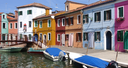
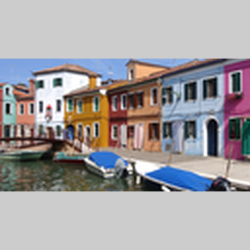
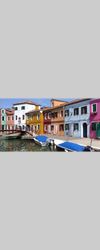
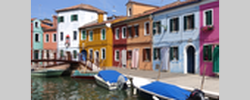
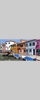


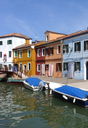
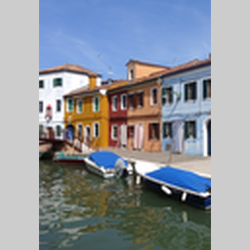
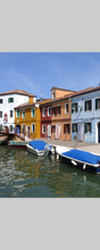
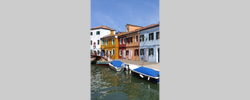
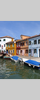

In [104]:
def experiment_image_uniform_scaling(cval=0.8) -> None:
  original_image = media.to_float01(EXAMPLE_IMAGE)
  source_images = [original_image[30:-30], original_image[:, 20:-20]]
  for row, image in enumerate(source_images):
    images = {f'{image.shape[:2]}': image}
    for shape in [(250, 250), (250, 100), (100, 250), (100, 40), (30, 80)]:
      images[f'uniform {shape}'] = resampler.uniform_resize(image, shape, cval=cval)
    media.show_images(images)
    if 1:
      fraction_gray = [
          (abs(image - cval) < 1e-6).all(2).sum() / image.size for image in images.values()
      ]
      expected = [
          [0.000, 0.155, 0.261, 0.080, 0.260, 0.092],
          [0.000, 0.104, 0.139, 0.240, 0.133, 0.242],
      ][row]
      assert np.allclose(fraction_gray, expected, atol=0.001), (row, fraction_gray, expected)


experiment_image_uniform_scaling()

## Image rotation
<a name="Image-rotation"></a>


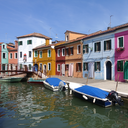
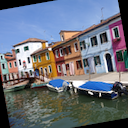
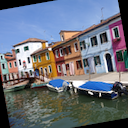
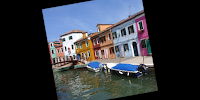
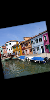


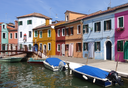
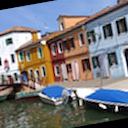
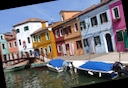
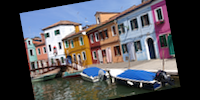
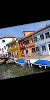

In [105]:
def experiment_rotate_image_about_center(scale=1.0) -> None:
  original = EXAMPLE_IMAGE
  for row, image in enumerate([original, original[20:108]]):
    new_shapes = [original.shape[:2], image.shape[:2], (100, 200), (100, 50)]
    images = {'image': image}
    images |= {
        f'{i}: {new_shape}': resampler.rotate_image_about_center(
            image, math.radians(10), new_shape=new_shape, scale=scale, boundary='natural'
        )
        for i, new_shape in enumerate(new_shapes)
    }
    media.show_images(images)
    if 1:
      fraction_black = [np.sum(image == [0, 0, 0]) / image.size for image in images.values()]
      expected = [[0.000, 0.082, 0.082, 0.519, 0.511], [0.001, 0.054, 0.094, 0.321, 0.492]][row]
      assert np.allclose(fraction_black, expected, atol=0.001), (row, fraction_black, expected)


experiment_rotate_image_about_center()

In [106]:
def overwrite_outside_circle(
    image: _NDArray, cval: _ArrayLike = 0, margin: float = 0.0
) -> _NDArray:
  shape = np.array(image.shape[:2])
  cval = np.broadcast_to(cval, image.shape[2])
  radius = min(shape) / 2 - margin
  mapped_radius = np.linalg.norm(np.indices(tuple(shape)).T + 0.5 - (shape / 2), axis=-1).T
  outside_circle = mapped_radius >= radius
  image = image.copy()
  image[outside_circle] = cval
  return image

In [107]:
def test_overwrite_outside_circle() -> None:
  media.show_image(overwrite_outside_circle(EXAMPLE_IMAGE))


if 0:
  test_overwrite_outside_circle()


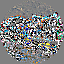
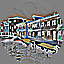
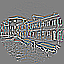
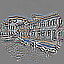
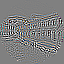
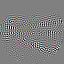
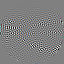
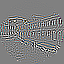
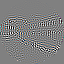
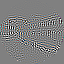
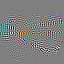
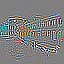
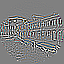
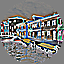
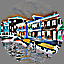
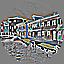

In [108]:
def experiment_compare_successive_rotations(num_rotations=7, gamma='identity') -> None:
  original = resampler.resize(EXAMPLE_IMAGE, np.array(EXAMPLE_IMAGE.shape[:2]) // 2)
  images = {}
  original = media.to_float01(original)  # not linear space
  original_cropped = overwrite_outside_circle(original)
  filters = [f for f in resampler.FILTERS if f not in 'box trapezoid narrowbox'.split()]
  psnrs = []
  for filter in filters:
    image = resampler.rotate_image_about_center(
        original, math.tau / num_rotations, num_rotations=num_rotations, filter=filter, gamma=gamma
    )
    image = overwrite_outside_circle(image)
    psnr = get_psnr(image, original_cropped)
    psnrs.append(psnr)
    if 1:
      # image = (image - original_cropped) * 5 + 0.5
      image = np.subtract(image, original_cropped) * 5 + 0.5  # Help mypy.
    images[f"'{filter}': {psnr:.1f} dB"] = image
  media.show_images(images, columns=6, ylabel=f"gamma='{gamma}'", height=original.shape[0] * 2)
  if gamma == 'identity':
    expected = [18.3, 21.5, 25.5, 27.0, 29.0, 31.6, 33.4, 28.4, 30.9, 30.3, 31.4]
    expected += [28.0, 26.8, 21.4, 19.9, 22.3]
    assert np.allclose(psnrs, expected, atol=0.05), (psnrs, expected)


experiment_compare_successive_rotations(gamma='identity')

if 0:
  # This may be more correct but in fact it reduces PSNR!
  # It may be that the signal squaring induces more aliasing.
  display_markdown('&nbsp;')
  experiment_compare_successive_rotations(gamma='power2')

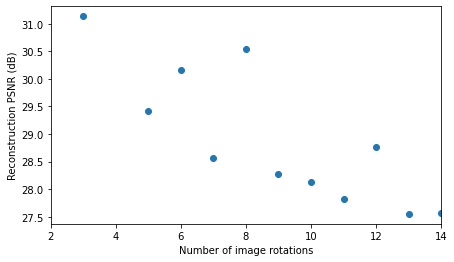

In [109]:
def experiment_plot_psnr_for_num_rotations(filter='lanczos5') -> None:
  original = resampler.resize(EXAMPLE_IMAGE, np.array(EXAMPLE_IMAGE.shape[:2]) // 2)
  _, ax = plt.subplots(figsize=(7, 4))
  x = [i for i in range(2, 15) if i not in [2, 4]]
  psnrs = []
  for num_rotations in x:
    image = resampler.rotate_image_about_center(
        original, math.tau / num_rotations, num_rotations=num_rotations, filter=filter
    )
    psnrs.append(get_psnr(overwrite_outside_circle(image), overwrite_outside_circle(original)))
  ax.scatter(x, psnrs)
  ax.set(xlim=(2, 14), xlabel='Number of image rotations', ylabel='Reconstruction PSNR (dB)')
  if filter == 'lanczos5':
    expected = [31.1, 29.4, 30.2, 28.6, 30.5, 28.3, 28.1, 27.8, 28.8, 27.6, 27.6]
    assert np.allclose(psnrs, expected, atol=0.05), (psnrs, expected)


experiment_plot_psnr_for_num_rotations()


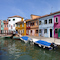
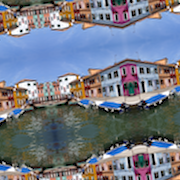
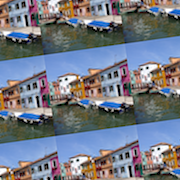
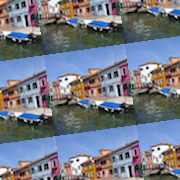
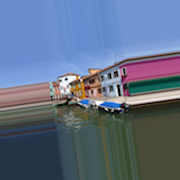
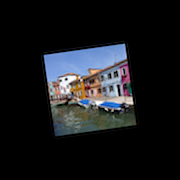
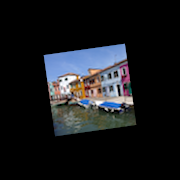
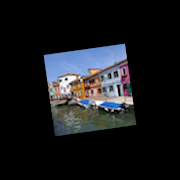
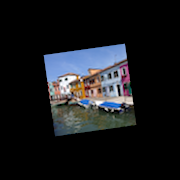
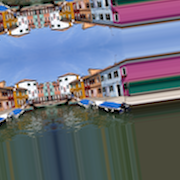
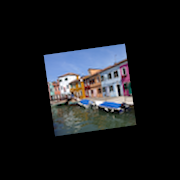
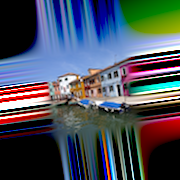
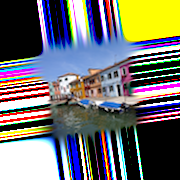

In [110]:
def experiment_visualize_rotation_boundaries(
    degrees=8, scale=2.2, src_size=60, dst_size=180
) -> None:
  original_image = resampler.resize(EXAMPLE_IMAGE, (src_size,) * 2)
  matrix = resampler.rotation_about_center_in_2d(
      original_image.shape[:2], math.radians(degrees), scale=scale
  )
  images = {
      f"'{boundary}'": resampler.resample_affine(
          original_image, (dst_size,) * 2, matrix[:-1], boundary=boundary
      )
      for boundary in resampler.BOUNDARIES
  }
  images = {'original image': original_image} | images
  assert all(image.dtype == np.uint8 for image in images.values())
  media.show_images(images, height=180, columns=5)
  if 1:
    means = [image.mean() for image in images.values()]
    expected = [123, 123, 123, 123, 114, 26, 26, 26, 26, 113, 26, 82, 111]
    assert np.allclose(means, expected, 0.5), (means, expected)


experiment_visualize_rotation_boundaries()


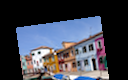
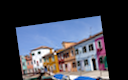
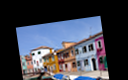

In [111]:
def experiment_with_boundary_antialiasing(degrees=8, scale=1.5, src_size=64, dst_size=128) -> None:
  original_image = resampler.resize(EXAMPLE_IMAGE, (src_size,) * 2)
  matrix = resampler.rotation_about_center_in_2d(
      original_image.shape[:2], math.radians(degrees), scale=scale
  )
  images = {}
  for boundary_antialiasing, gamma in [(False, 'power2'), (True, 'power2'), (True, 'identity')]:
    title = f"boundary_antialiasing={boundary_antialiasing} &nbsp; '{gamma}'"
    boundary = dataclasses.replace(
        resampler._get_boundary('natural'),
        override_value=resampler.UnitDomainOverrideExteriorValue(
            boundary_antialiasing=boundary_antialiasing
        ),
    )
    images[title] = resampler.resample_affine(
        original_image, (dst_size,) * 2, matrix[:-1], boundary=boundary, gamma=gamma, cval=0.0
    )[:80]
  media.show_images(images, height=160)
  if 1:
    t = list(images.values())
    assert np.allclose([get_psnr(t[0], t[1]), get_psnr(t[0], t[2])], [30.5, 31.3], atol=0.05)


experiment_with_boundary_antialiasing()

Conclusion: the middle result is best, with boundary antialiasing enabled,
and with filtering in linear space (after conversion from/to `'power2'` lightness space).

In [112]:
def experiment_zoom_image(original_image, num_frames=60) -> None:
  """Here we vary only the prefilter, keeping constant the default reconstruction filter."""
  videos = collections.defaultdict(list)
  for frame_index in range(num_frames):
    # scale = 0.7 + 0.35 * (frame_index + 0.5) / num_frames
    scale = 0.7 * (1.1 / 0.7) ** ((frame_index + 0.5) / num_frames)
    for filter in 'box trapezoid lanczos3'.split():
      new_image = resampler.resize(
          original_image,
          original_image.shape,
          translate=(1 - scale) / 2,
          scale=scale,
          prefilter=filter,
      )
      videos[f"resize filter='{filter}'"].append(new_image)
  media.show_videos(videos, height=original_image.shape[0] * 2, border=True, fps=10)


if EFFORT >= 1:
  experiment_zoom_image(resampler.resize(EXAMPLE_IMAGE, (128, 128)))

  def create_graphics_image() -> _NDArray:
    return 0.1 + 0.8 * media.to_float01(example_vector_graphics_image())

  experiment_zoom_image(create_graphics_image()[220:980, 210:1240][490:, 470:][:80, :128])

# - minifying with 'box' has terrible temporal behavior!
# - 'trapezoid' is much better; however, for photos, 'lanczos3' is still best.
# try high-frequency test pattern image?

In [113]:
def experiment_zoom_rotate_image(src_size=128, dst_size=128, num_frames=60) -> None:
  """The `resampler` function lacks a prefilter, so shows aliasing during minification."""
  original_image = resampler.resize(EXAMPLE_IMAGE, (src_size,) * 2)
  videos = collections.defaultdict(list)
  for frame_index in range(num_frames):
    angle = (frame_index + 0.5) / num_frames * (0.02 * math.tau)
    # scale = 0.7 + 0.35 * (frame_index + 0.5) / num_frames
    # scale = 0.4 + 0.9 * (frame_index + 0.5) / num_frames
    scale = 0.4 * (1.4 / 0.4) ** ((frame_index + 0.5) / num_frames)
    matrix = resampler.rotation_about_center_in_2d(
        original_image.shape[:2], angle, scale=1.0 / scale
    )
    for filter in 'box lanczos3'.split():  # no 'trapezoid'
      new_image = resampler.resample_affine(
          original_image, (dst_size,) * 2, matrix[:-1], filter=filter, boundary='wrap'
      )
      videos[f"resample filter='{filter}'"].append(new_image)
  media.show_videos(videos, height=dst_size * 2, border=True, fps=10)


if EFFORT >= 1:
  experiment_zoom_rotate_image()

## Affine resample using shears

It would be useful to have a specialized implementation of `resample_affine()` that does not
involve the full generality (and expense) of `resample()`.
One idea is to implement `resample_affine()` as a sequence of 1D shears.

However this presents several difficulties:

- The resulting shears usually involve a non-unity scaling factor.
  Even though this scaling factor is uniform across the entire domain,
  it results in non-repetitive filter weights on all source pixels,
  so the shear computation cannot be expressed using a small sparse matrix
  as in the `_create_resize_matrix()` of `resize()`.

- Filtering using a sequence of two 1D shears does not reproduce the 2D tensor-product filter,
  resulting in small errors (0.6 dB in the example below).

- Correctly handling general boundary conditions would require expanding the domains
  of the intermediate results between successive shears.

In [114]:
# Given a general 2D affine matrix:
#
#     | a  b  t |
# M = | c  d  u |
#     | 0  0  1 |
#
# We can factor it as the product of two 1D shear-scale matrices, M = A * B,
#
# | 1  0  0 |     | h  i  j |     | h      i      j     |
# | e  f  g |  *  | 0  1  0 |  =  | e*h    e*i+f  e*j+g |
# | 0  0  1 |     | 0  0  1 |     | 0      0      1     |
#
# Given (a, b, c, d, t, u), we obtain:
# e = c / a
# f = d - c / a * b
# g = u - c / a * t
# h, i, j = a, b, t

# Note that for a rotation matrix, the factorization involves non-unity scaling factors:
#
# | C  -S  0 |    | 1    0        0 |     | C  -S  0 |
# | S   C  0 | =  | S/C  C+S^2/C  0 |  *  | 0   1  0 |
# | 0   0  1 |    | 0    0        1 |     | 0   0  1 |

# Alternatively, e.g., if a = 0, we can use:
#
#         | h+e*i  f*i    g*i+j |
# B * A = | e      f      g     |
#         | 0      0      1     |
#
# e, f, g = c, d, u
# h = a - c * b / d
# i = b / d
# j = t - u * b / d

# What if a = d = 0, e.g., a 90-degree rotation?
# In that case it is best to include an initial explicit 90-degree CCW rotation R:
#
#     | 0  -1   1 |
# R = | 1   0   0 |
#     | 0   0   1 |
#
#                     | i       -h     h+j       |
# so that A * B * R = | e*i+f   -e*h   e*h+e*j+g |
#                     | 0       0      1         |
#
# e = d / b
# f = c - d / b * a
# g = u - d / b * t
# h = -b
# i = a
# j = t + b

# Instead of a rotation R, we can also consider an initial transpose T:
#
#     | 0   1   0 |
# T = | 1   0   0 |
#     | 0   0   1 |
#
#                     | i      h     j     |
# so that A * B * T = | e*i+f  e*h   e*j+g |
#                     | 0      0     1     |
#
# e = d / b
# f = c - d / b * a
# g = u - d / b * t
# h, i, j = b, a, t
# The only (minor) difference is that the initial X shear has a reflection and translation.
# So just applying a transpose is simpler and does not have any drawback.

# We can also apply the transpose after the two shears:
#
#                     | e*h   e*i+f  e*j+g |
# so that T * A * B = | h     i      j     |
#                     | 0     0      1     |
#
# e = a / c
# f = b - a / c * d
# g = t - a / c * d
# h, i, j = c, d, u

# Overall, we can just use A*B and choose a pre-transposition and a post-transposition,
# for a total of 4 possibilities in 2D.  The goal is to maximize the scaling factor h for A*B.


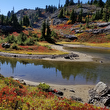
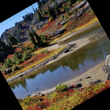
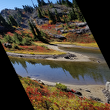
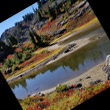
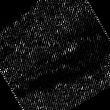


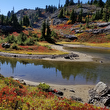
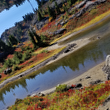
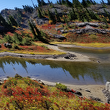
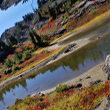
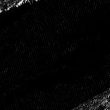


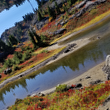
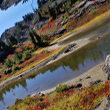

In [115]:
def experiment_shear_image(
    downscale=4, degrees=30, show_compare=False, expected=None, **kwargs
) -> None:
  original = media.to_float01(EXAMPLE_PHOTO[40:, -440:])
  image = resampler.resize(original, np.array(original.shape[:2]) // downscale, filter='lanczos10')
  matrix = resampler.rotation_about_center_in_2d(image.shape[:2], math.radians(degrees))
  kwargs2 = kwargs | dict(filter='lanczos10')
  original2 = resampler.resample_affine(original, original.shape[:2], matrix[:-1], **kwargs2)
  reference = resampler.resize(original2, image.shape[:2], filter='lanczos10')
  # `matrix` maps destination points to source points.
  # source_pos = matrix * destination_pos = (shear2 * shear1) * destination_pos
  # source_pos = shear2 * destination_a_pos
  # destination_a_pos = shear1 * destination_pos
  image2 = resampler.resample_affine(image, image.shape[:2], matrix[:-1], **kwargs)
  (a, b, t), (c, d, u) = matrix[:2]
  e, f, g = c / a, d - c / a * b, u - c / a * t
  shear1 = np.array([[a, b, t], [0, 1, 0], [0, 0, 1]], float)
  shear2 = np.array([[1, 0, 0], [e, f, g], [0, 0, 1]], float)
  assert np.allclose(shear2 @ shear1, matrix)
  image3a = resampler.resample_affine(image, image.shape[:2], shear2[:-1], **kwargs)
  image3 = resampler.resample_affine(image3a, image.shape[:2], shear1[:-1], **kwargs)
  if show_compare:
    media.compare_images([image2, image3])
    return
  psnrs = [get_psnr(image2, reference), get_psnr(image3, reference)]
  images = {
      'source': image,
      f'rotated (PSNR={psnrs[0]:.2f} dB)': image2,
      '1shear': image3a,
      f'2shears (PSNR={psnrs[1]:.2f} dB)': image3,
      'error': hh.rms(image3 - image2, axis=-1) * 2.0,
  }
  media.show_images(images, height=image.shape[0] * 1)
  if expected:
    assert np.allclose(psnrs, expected, 0.005), (psnrs, expected)


if EFFORT >= 1:
  # Small errors in the interior.  downscale=2 -> expected=[32.65, 32.03]
  experiment_shear_image(filter='cubic', boundary='constant', expected=[32.40, 31.65])
  # Plus large boundary errors.  downscale=2 -> expected=[32.01, 25.23]
  experiment_shear_image(filter='cubic', boundary='reflect', expected=[31.95, 26.06])
  # Interactive comparison.
  experiment_shear_image(filter='cubic', boundary='reflect', show_compare=True)

## Gradient backpropagation
<a name="Gradient-backpropagation"></a>

- Tensorflow gradient-descent optimization:

In [116]:
def test_tensorflow_optimize_image_for_desired_upsampling(
    operation='resize',
    num_steps=30,
    debug=False,
    src_shape=(8, 8, 3),
    dst_shape=(16, 16),
    filter='triangle',
) -> None:
  array_np = np.full(src_shape, 0.5, np.float32)
  array = tf.Variable(tf.convert_to_tensor(array_np))
  desired = resampler.resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=np.float32)
  coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape

  def get_keras_resize_model() -> tf.keras.Model:
    x_in = tf.keras.Input(shape=src_shape, batch_size=1)

    def func(x):
      return resampler.resize(x, (x.shape[0], *dst_shape), filter=filter)

    x = tf.keras.layers.Lambda(func)(x_in)
    return tf.keras.Model(inputs=x_in, outputs=x)

  keras_resize_model = get_keras_resize_model()
  if 0:
    keras_resize_model.summary()

  def model(array) -> tf.Tensor:
    functions: dict[str, Callable[[], tf.Tensor]] = {
        'resize': lambda: resampler.resize(array, dst_shape, filter=filter),
        'resample': lambda: resampler.resample(array, coords, filter=filter),
        'keras_resize': lambda: keras_resize_model(array[None])[0],
    }
    return functions[operation]()

  def compute_loss(upsampled) -> tf.Tensor:
    # The learning_rate must be adapted to the magnitude of the loss value, which changes between
    # reduce_sum() and reduce_mean().
    return tf.math.reduce_mean(tf.math.squared_difference(upsampled, desired))

  learning_rate = 1e2
  for _ in range(num_steps):
    with tf.GradientTape() as tape:
      loss = compute_loss(model(array))
    gradient = tape.gradient(loss, array)
    array.assign_sub(learning_rate * gradient)

  # This approach from TensorFlow 1 is no longer supported in TensorFlow 2.
  # learning_rate = 1e-1
  # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  # optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
  # for _ in range(num_steps):
  #   optimizer.minimize(lambda: compute_loss(model(array)), [array])

  upsampled = model(array)
  rms = get_rms(upsampled, desired)
  if debug:
    print(f'rms_loss={rms:.4f}')
    images = {'optimized': array, 'upsampled': upsampled, 'desired': desired}
    media.show_images(images, height=80, border=True)
  assert rms < 0.08, operation


def test_tensorflow_optimize_image_for_desired_upsamplings() -> None:
  operations = 'resize resample keras_resize'.split()
  filters = 'triangle cardinal3'.split()
  for config in itertools.product(operations, filters):
    operation, filter = config
    test_tensorflow_optimize_image_for_desired_upsampling(operation=operation, filter=filter)


if EFFORT >= 1:
  test_tensorflow_optimize_image_for_desired_upsampling(debug=True)
  test_tensorflow_optimize_image_for_desired_upsamplings()

rms_loss=0.0650


- Torch gradient-descent optimization:

In [117]:
def test_torch_optimize_image_for_desired_upsampling(
    src_shape=(8, 8, 3), dst_shape=(16, 16), num_steps=30
) -> None:
  configs = [
      ('resize', 'reflect', 'triangle', 'float64'),
      ('resample', 'border', 'cubic', 'float64'),
      ('resize', 'wrap', 'box', 'float32'),
      ('resample', 'reflect', 'lanczos3', 'float32'),
      ('resize', 'quadratic', 'omoms5', 'float32'),
      ('resample', 'constant', 'cardinal5', 'float64'),
      ('resize', 'clamp', 'impulse', 'float32'),
      ('resample', 'natural', 'cardinal3', 'float64'),
  ]
  for config in configs:
    operation, boundary, filter, dtype = config
    array_np = np.full(src_shape, 0.5, dtype)
    array = torch.tensor(array_np, requires_grad=True)
    desired = torch.as_tensor(
        resampler.resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=dtype)
    )
    coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape

    def model(array) -> _TorchTensor:
      kwargs: Any = dict(boundary=boundary, filter=filter, cval=(0.8, 0.5, 0.4))
      functions: dict[str, Callable[[], Any]] = {
          'resize': lambda: resampler.resize(array, dst_shape, **kwargs),
          'resample': lambda: resampler.resample(array, coords, **kwargs),
      }
      return functions[operation]()

    def compute_loss(upsampled) -> _TorchTensor:
      return torch.linalg.norm(upsampled - desired)  # pylint: disable=not-callable

    # https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
    learning_rate = 0.2
    optimizer = torch.optim.SGD([array], lr=learning_rate)  # Stochastic gradient descent.
    for _ in range(num_steps):
      loss = compute_loss(model(array))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    upsampled = model(array).detach()
    rms = get_rms(upsampled, desired)
    debug = filter == 'triangle'
    if debug:
      print(f'rms_loss={rms:.4f}')
      images = {'optimized': array.detach(), 'upsampled': upsampled, 'desired': desired}
      media.show_images(images, height=80, border=True)
    assert rms < 0.08, (config, rms)


if EFFORT >= 1:
  test_torch_optimize_image_for_desired_upsampling()

rms_loss=0.0654


In [118]:
def test_torch_gradients_using_gradcheck(src_shape=(7, 7), dst_shape=(13, 13)) -> None:
  filters = 'cubic cardinal3'.split()
  for filter in filters:
    coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape
    functions = [
        lambda array: resampler.resize(array, dst_shape, filter=filter),
        lambda array: resampler.resample(array, coords, filter=filter),
    ]
    array_np = np.random.default_rng(0).random(src_shape, np.float64)
    array = torch.tensor(array_np, requires_grad=True)
    for function in functions:
      assert torch.autograd.gradcheck(function, [array], rtol=0, atol=1e-6)


if EFFORT >= 1:
  test_torch_gradients_using_gradcheck()

- Jax gradient-descent optimization:

In [119]:
def test_jax_optimize_image_for_desired_upsampling(
    src_shape=(8, 8, 3), dst_shape=(16, 16), num_steps=30
) -> None:
  configs = [
      ('resize', 'reflect', 'triangle', 'float64'),
      ('resample', 'border', 'cubic', 'float64'),
      ('resize', 'wrap', 'box', 'float32'),
      ('resample', 'reflect', 'lanczos3', 'float32'),
      ('resize', 'quadratic', 'omoms5', 'float32'),
      ('resample', 'constant', 'cardinal5', 'float64'),
      ('resize', 'clamp', 'impulse', 'float32'),
      ('resample', 'natural', 'cardinal3', 'float64'),
  ]
  for config in configs:
    operation, boundary, filter, dtype = config
    if resampler._get_filter(filter).requires_digital_filter:
      print(f'Skipping {config} because {filter} is not jax-differentiable.')
      continue
    array_np = np.full(src_shape, 0.5, dtype)
    array = jnp.asarray(array_np)
    desired = jnp.asarray(resampler.resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=dtype))
    coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape

    def model(array) -> _JaxArray:
      kwargs: Any = dict(boundary=boundary, filter=filter, cval=(0.8, 0.5, 0.4))
      functions: dict[str, Callable[[], Any]] = {
          'resize': lambda: resampler.jaxjit_resize(array, dst_shape, **kwargs),
          'resample': lambda: resampler.resample(array, coords, **kwargs),
      }
      return functions[operation]()

    def compute_loss(array) -> Any:
      return jnp.linalg.norm(model(array) - desired)

    grad_loss = jax.grad(compute_loss)

    # For example, see https://medium.com/swlh/solving-optimization-problems-with-jax-98376508bd4f
    learning_rate = 0.2
    for _ in range(num_steps):
      array = array - learning_rate * grad_loss(array)

    upsampled = model(array)
    rms = get_rms(upsampled, desired)
    debug = filter == 'triangle'
    if debug:
      print(f'rms_loss={rms:.4f}')
      images = {'optimized': array, 'upsampled': upsampled, 'desired': desired}
      media.show_images(images, height=80, border=True)
    assert rms < 0.08, (config, rms)


if EFFORT >= 1:
  test_jax_optimize_image_for_desired_upsampling()

rms_loss=0.0654


Skipping ('resize', 'quadratic', 'omoms5', 'float32') because omoms5 is not jax-differentiable.
Skipping ('resample', 'constant', 'cardinal5', 'float64') because cardinal5 is not jax-differentiable.
Skipping ('resample', 'natural', 'cardinal3', 'float64') because cardinal3 is not jax-differentiable.


In [120]:
def test_jax0() -> None:
  array = jnp.ones((2, 2), 'float32')
  print(array.device_buffer.device())
  print(array, type(array), repr(array))

  array_np = np.ones((2, 2), 'float32')
  array_jax = jax.device_put(array_np)
  print(array_jax.device_buffer.device())
  print(array_jax, type(array_jax), repr(array_jax))

  array_jax = jnp.ones((2000,) * 2, 'float32')
  hh.print_time(lambda: jnp.dot(array_jax, array_jax.T).block_until_ready())

  array_np = np.ones((2000,) * 2, 'float32')
  hh.print_time(lambda: np.dot(array_np, array_np.T))


if 0:
  test_jax0()

In [121]:
def test_jax1(filter='cubic') -> None:
  array = jnp.ones((4_000,) * 2)
  hh.print_time(lambda: resampler.resize(array, (3, 3), filter=filter), max_time=0)
  hh.print_time(lambda: resampler.resize(array, (3, 3), filter=filter), max_time=0)
  hh.print_time(lambda: resampler.resize(array, (3, 3), filter=filter), max_time=0)
  if not resampler._get_filter(filter).requires_digital_filter:
    # Else: TracerArrayConversionError in np.asarray() in jax_inverse_convolution().
    hh.print_time(lambda: resampler.jaxjit_resize(array, (3, 3), filter=filter), max_time=0)
    hh.print_time(lambda: resampler.jaxjit_resize(array, (3, 3), filter=filter), max_time=0)
    hh.print_time(lambda: resampler.jaxjit_resize(array, (3, 3), filter=filter), max_time=0)


if EFFORT >= 1:
  test_jax1()
  test_jax1(filter='cardinal3')

186 ms
30.0 ms
8.42 ms
684 ms
117 µs
513 µs
335 ms
101 ms
108 ms


In [122]:
def test_jax2() -> None:
  def resized_sum(array: resampler._Array) -> Any:
    return resampler.resize(array, (3, 3)).sum()

  array = jnp.ones((2, 2))
  new = jax.grad(resized_sum)(array)
  print(new)


if EFFORT >= 1:
  test_jax2()

[[2.25 2.25]
 [2.25 2.25]]


In [123]:
def test_jax() -> None:
  print(jax.default_backend())
  print(jax.devices())
  print(jax.local_devices())
  array = jnp.ones((2, 2), 'float32')
  if 0:
    print(jax.make_jaxpr(resampler.resize, static_argnums=(1,))(array, (3, 3)))
    print(jax.make_jaxpr(resampler.jaxjit_resize, static_argnums=(1,))(array, (3, 3)))

  if 0:
    # Because `jax.make_jaxpr` unfortunately does not support `static_argnames`, we cannot specify
    # any keyword arguments, e.g., `boundary='natural'`, so we use `functools.partial`.
    resize2 = functools.partial(resampler.resize, boundary='natural')
    _ = resize2
    # print(jax.make_jaxpr(resize2, static_argnums=(1,))(array, (3, 3)))
    # print(jax.make_jaxpr(_immediately_jaxjit_resize(resize2), static_argnums=(1,))(array, (3, 3)))


if 0:
  test_jax()

In [124]:
# ?

# func_value_and_grad = jax.value_and_grad(fun[, argnums, has_aux, ...])

# Can auto-vectorization jax.vmap(func) be used to generate a 2D convolution from a function
# expressing a single-element combination of its neighbors?

# pip install -U 'jax[cuda]' -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !nvcc --version  # CUDA version.

- Use Tensorflow to solve for an image whose spiral upsampling matches a desired image:


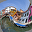
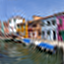
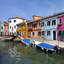

PSNR=22.87 dB



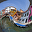
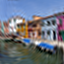
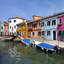

PSNR=22.54 dB



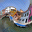
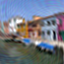
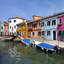

PSNR=22.18 dB


In [125]:
def experiment_image_optimized_for_spiral_resampling(
    num_steps=30,
    src_shape=(32, 32, 3),
    dst_shape=(64, 64),
    regularization_weight=0.0,
    smoothness_weight=0.0,
) -> None:
  array_np = np.full(src_shape, 0.5, np.float32)
  array = tf.Variable(tf.convert_to_tensor(array_np))
  desired = resampler.resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=np.float32)

  yx = ((np.indices(dst_shape).T + 0.5) / dst_shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5

  def model(array) -> tf.Tensor:
    return resampler.resample(array, coords)

  def compute_loss(array, upsampled) -> tf.Tensor:
    data_loss = tf.math.reduce_mean(tf.math.squared_difference(upsampled, desired))
    regularization_loss = regularization_weight * tf.math.reduce_mean(array**2)
    num_pixels = tf.size(array, out_type=tf.float32) / 3
    smoothness_loss = smoothness_weight * (tf.image.total_variation(array) / num_pixels) ** 2
    return data_loss + regularization_loss + smoothness_loss

  learning_rate = 1e3
  for _ in range(num_steps):
    with tf.GradientTape() as tape:
      loss = compute_loss(array, model(array))
    gradient = tape.gradient(loss, array)
    array.assign_sub(learning_rate * gradient)
    if 0:
      print(f'mse={get_rms(model(array), desired)**2:8.6f}  {loss=:8.6f}')

  resampled = model(array)
  images = {'optimized': array, 'resampled': resampled, 'desired': desired}
  media.show_images(images, height=192, border=True)
  psnr = get_psnr(resampled, desired)
  print(f'PSNR={psnr:.2f} dB')
  assert np.allclose(psnr, 22.4, 0.05), (psnr, regularization_weight, smoothness_weight)


if EFFORT >= 1:
  hh.display_html('Without regularization, unconstrained pixels keep their initial gray values:')
  experiment_image_optimized_for_spiral_resampling()

  hh.display_html('With regularization, unconstrained regions get small values (black):')
  experiment_image_optimized_for_spiral_resampling(regularization_weight=0.04)

  hh.display_html('Smoothness destroys the high-frequency content:')
  experiment_image_optimized_for_spiral_resampling(smoothness_weight=1e-2)

## Block partition and timing

In [126]:
def test_blocking_using_image_rotation(max_block_size, src_size=64, dst_size=256) -> None:
  for arraylib in resampler.ARRAYLIBS:
    # print(f'{arraylib=}')
    original_image = resampler._make_array(
        resampler.resize(EXAMPLE_IMAGE, (src_size,) * 2), arraylib
    )

    def rotate_image(degrees=8, scale=2.2, **kwargs) -> Any:
      matrix = resampler.rotation_about_center_in_2d(
          original_image.shape[:2], math.radians(degrees), scale=scale
      )
      return resampler.resample_affine(
          original_image, (dst_size,) * 2, matrix[:-1], boundary='reflect', **kwargs
      )

    reference = rotate_image()
    _check_eq(resampler._arr_arraylib(reference), arraylib)
    result = rotate_image(max_block_size=max_block_size)
    reference_numpy = resampler._arr_numpy(reference)
    result_numpy = resampler._arr_numpy(result)
    _check_eq(result_numpy.shape, reference_numpy.shape)
    _check_eq(result_numpy.dtype, np.uint8)
    assert np.allclose(result_numpy, reference_numpy, atol=1)


if EFFORT >= 1:
  test_blocking_using_image_rotation(max_block_size=1_000)

In [127]:
def experiment_find_the_best_max_block_size(src_size=64, dst_size=4096) -> None:
  original_image_numpy = resampler.resize(EXAMPLE_IMAGE, (src_size,) * 2)

  for arraylib in resampler.ARRAYLIBS:
    print(f'\n# {arraylib}:')
    original_image = resampler._make_array(original_image_numpy, arraylib)

    sizes = [4_000, 10_000, 40_000, 100_000, 400_000, 800_000, 4_000_000]
    # sizes += [8_000_000, 0]  # Can lead to out-of-memory on this large test.
    for max_block_size in sizes:

      def rotate_image(degrees=8, scale=2.2) -> Any:
        matrix = resampler.rotation_about_center_in_2d(
            original_image.shape[:2], math.radians(degrees), scale=scale
        )
        return resampler.resample_affine(
            original_image,
            (dst_size,) * 2,
            matrix[:-1],
            boundary='reflect',
            max_block_size=max_block_size,
        )

      elapsed = hh.get_time(rotate_image)
      print(f'# {max_block_size=:10_} {elapsed:.3f} s')


if EFFORT >= 2:
  experiment_find_the_best_max_block_size()
# 2021-11-05 Colab CPU (Intel Xeon CPU E5-2650 v4 @ 2.20GHz):
# max_block_size=     4_000 24.637 s
# max_block_size=    40_000 23.852 s
# max_block_size=   400_000 23.124 s
# max_block_size=   800_000 23.078 s
# max_block_size= 4_000_000 22.768 s
# max_block_size= 8_000_000 23.178 s
# max_block_size=         0 35.138 s
# Conclusion: it's a worthwhile improvement, with max_block_size = ~4_000_000.

# New 2022-07-09: memory seems higher now.  AMD Ryzen 9 5900X: best max_block_size = 40_000

# numpy:
# max_block_size=     4_000 11.148 s
# max_block_size=    10_000 10.682 s
# max_block_size=    40_000 10.301 s
# max_block_size=   100_000 11.423 s
# max_block_size=   400_000 12.285 s
# max_block_size=   800_000 12.772 s
# max_block_size= 4_000_000 13.195 s

# tensorflow:
# max_block_size=     4_000 12.112 s
# max_block_size=    10_000 9.869 s
# max_block_size=    40_000 8.055 s
# max_block_size=   100_000 8.761 s
# max_block_size=   400_000 11.052 s
# max_block_size=   800_000 10.833 s
# max_block_size= 4_000_000 12.151 s

# torch:
# max_block_size=     4_000 7.758 s
# max_block_size=    10_000 6.787 s
# max_block_size=    40_000 6.393 s
# max_block_size=   100_000 6.006 s
# max_block_size=   400_000 6.595 s
# max_block_size=   800_000 6.900 s
# max_block_size= 4_000_000 7.655 s

# jax:
# max_block_size=     4_000 13.576 s
# max_block_size=    10_000 11.065 s
# max_block_size=    40_000 9.432 s
# max_block_size=   100_000 9.271 s
# max_block_size=   400_000 9.409 s
# max_block_size=   800_000 10.123 s
# max_block_size= 4_000_000 11.023 s

## Visualization of filters

The kernel is usually interpolating,
i.e., it has value $1$ at $x=0$ and value $0$ at all other integer coordinates.

In [128]:
def visualize_filters(filters: Mapping[str, resampler.Filter]) -> None:
  def analyze_filter(name: str, filter: resampler.Filter, ax: Any) -> None:
    footnote = '*' if filter.requires_digital_filter else ''
    if filter.name == 'trapezoid':
      filter = resampler.TrapezoidFilter(radius=0.75)  # Visualize some representative radius.
      footnote = _UNICODE_DAGGER
    radius = filter.radius
    # Mock that the filter is a partition of unity for accurate un-normalized integral
    # (e.g. 'lanczos3') and for raw interp_error (e.g. 'gaussian').
    filter_no_renorm = copy.copy(filter)
    object.__setattr__(filter_no_renorm, 'partition_of_unity', True)

    if filter.name == 'impulse':
      interp_err = 0.0
      integral = 1.0
      x_plot = np.array([-10.0, -0.01, 0.0, 0.01, 10.0])  # Fake for visualization.
      y_plot = np.array([0.0, 0.0, 2.0, 0.0, 0.0])

    else:
      effective_radius = radius * (3 if filter.requires_digital_filter else 1)
      pad = math.ceil(effective_radius)
      src_size = pad * 2 + 1
      x = np.arange(-pad, pad + 1, dtype=np.float64)
      y = np.eye(src_size)[pad]
      scale = 25_000  # Dense enough for accurate integral.
      dst_size = pad * 2 * scale + 1
      x = resampler.resize(x, (dst_size,), gridtype='primal', filter='triangle')
      y = resampler.resize(y, (dst_size,), gridtype='primal', filter=filter_no_renorm)

      x_int = x[::scale]
      y_int = y[::scale]
      expected = np.where(x_int == 0.0, 1.0, 0.0)
      interp_err = abs(y_int - expected).sum()
      interp_err = 0.0 if interp_err < 1e-7 else interp_err

      integral = y.sum() / (len(y) - 1) * 2.0 * pad
      # (Typically the discretized kernel is renormalized anyway.)
      if not filter.continuous and abs(integral - 1.0) < 1e-3:
        integral = 1.0

      num_plot_points = 1_001
      subsample = len(x) // num_plot_points
      x_plot = np.concatenate(([-10.0], x[::subsample].tolist(), [10.0]))
      y_plot = np.concatenate(([0.0], y[::subsample].tolist(), [0.0]))

    ax.plot(x_plot, y_plot)
    ax.set(title=name, xlim=(-6.0, 6.0), ylim=(-0.25, 1.08))
    ax.grid(True, lw=0.3)
    ax.yaxis.set_ticks([0.0, 1.0])
    ax.xaxis.set_ticks(np.arange(-6, 7, 2))
    info = [f'{radius=:.2f}{footnote}', f'{interp_err=:.4f}', f'{integral=:.5f}']
    for i, line in enumerate(info):
      ax.text(0.9, 0.85 - 0.17 * i, line, fontsize=10.5)

    if filter.name != 'impulse':
      # Check that support radius is necessary and sufficient.
      assert np.all(abs(y[[0, -1]]) < 1e-10)
      assert filter(-(radius - 0.1)) != 0.0 and filter(radius - 0.1) != 0.0, filter
      xtmp = np.linspace(radius + 1e-6, radius + 3.0, 1_000)
      assert np.all(filter(xtmp) == 0.0) and np.all(filter(-xtmp) == 0.0), filter
      assert (interp_err < 1e-4) == filter.interpolating, (filter, interp_err)
      assert (abs(integral - 1.0) < 1e-6) == filter.unit_integral, (filter, integral)
      assert (abs(np.diff(y)) < 0.001).all() == filter.continuous, filter

  hh.no_vertical_scroll()
  num_columns = 3
  num_rows = math.ceil(len(filters) / num_columns)
  fig, axs = plt.subplots(num_rows, num_columns, figsize=(4.0 * num_columns, 2.5 * num_rows))
  axes = typing.cast(np.ndarray[Any, Any], axs).flat
  for i, (name, filter) in enumerate(filters.items()):
    analyze_filter(name, filter, axes[i])
  for i in range(len(filters), len(axes)):
    fig.delaxes(axes[i])  # Or: axes[i].axis('off').
  fig.tight_layout()
  plt.show()
  if any(filter.requires_digital_filter for filter in filters.values()):
    display_markdown(
        r'\* The effective radius is actually infinite due to the inverse convolution'
        ' of the digital filter.'
    )
  if any(filter.name == 'trapezoid' for filter in filters.values()):
    display_markdown(
        f"{_UNICODE_DAGGER} The radius for `'trapezoid'` is adjusted based on the scaling factor."
    )

In [129]:
if 0:  # For debug.
  visualize_filters({'hamming3': resampler._get_filter('hamming3')})

<a id="plots_of_filters"></a>**Plots of filters:**

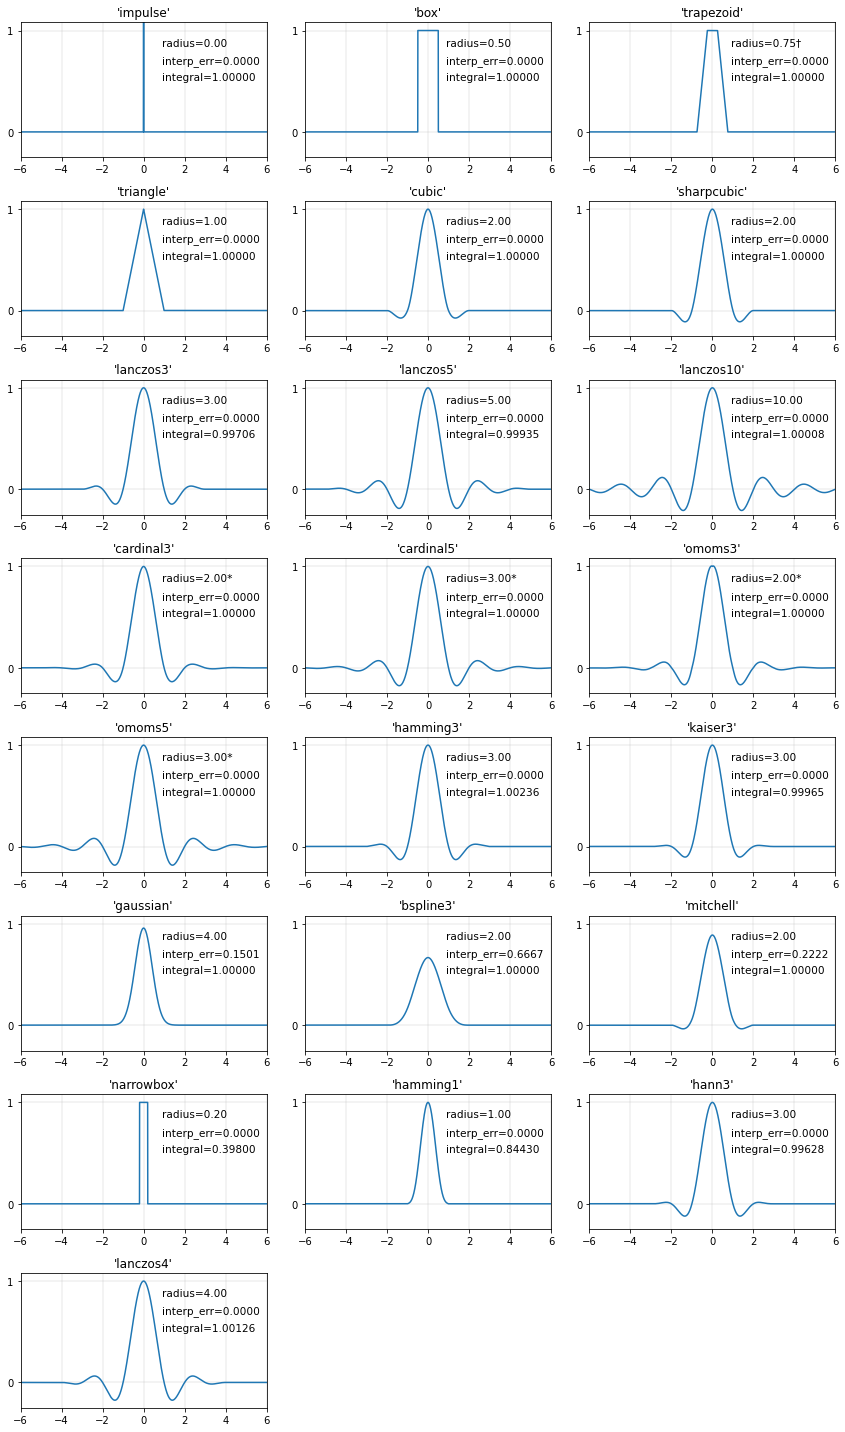

\* The effective radius is actually infinite due to the inverse convolution of the digital filter.

† The radius for `'trapezoid'` is adjusted based on the scaling factor.

In [130]:
if EFFORT >= 1:
  visualize_filters({f"'{name}'": filter for name, filter in resampler._DICT_FILTERS.items()})

## Frequency response of filters

In [131]:
def visualize_filter_frequency_response(filters: Mapping[str, resampler.Filter]) -> None:
  def analyze_filter(name: str, filter: resampler.Filter, ax: Any) -> None:
    if filter.name == 'impulse':
      filter = resampler.NarrowBoxFilter(radius=1e-6)
    if filter.name == 'trapezoid':
      filter = resampler.TrapezoidFilter(radius=0.75)  # Assign some representative radius.
      name = 'TrapezoidFilter(radius=0.75)'
    effective_radius = filter.radius * (10 if filter.requires_digital_filter else 1)
    pad = math.ceil(effective_radius)
    src_size = pad * 2 + 1
    impulse = np.eye(src_size)[pad]
    scale = 100  # Dense enough for accurate discrete approximation of continuous impulse response.
    dst_size = pad * 2 * scale + 1
    # Compute the impulse response function h:
    h = resampler.resize(impulse, (dst_size,), gridtype='primal', filter=filter) / scale
    h /= h.sum()  # For 'impulse' and 'narrowbox'.
    n = len(h) * 100  # Long enough for accurate frequency-domain representation.

    freq = np.fft.rfftfreq(n, d=1 / scale)
    magnitude = abs(np.fft.rfft(h, n=n))
    power_db = 20 * np.log10(np.maximum(magnitude, 1e-10))  # Power spectrum.
    db_at_half_freq = np.interp(0.5, freq, power_db)
    low_freq_gain = power_db[freq < 0.5].mean()
    high_freq_gain = power_db[(0.5 < freq) & (freq < 1.0)].mean()

    ax.plot(freq, power_db)
    ax.set(title=name, xlabel='Normalized frequency (cycles/sample)', ylabel='Gain (dB)')
    ax.set(xlim=[0.0, 2.0], ylim=[-80, 8])
    ax.grid(True, lw=0.3)
    params1 = dict(colors='gray', ls='dotted', lw=2, color='green')
    ax.vlines(x=0.5, ymin=-200, ymax=0, **params1)
    ax.hlines(y=0, xmin=0, xmax=0.5, **params1)
    bbox = dict(boxstyle='square,pad=0.2', fc='white', lw=0)
    if 0:
      text = f'{db_at_half_freq:.1f} dB'
      params2 = dict(ha='right', fontsize=11, arrowprops=dict(arrowstyle='->', lw=1), bbox=bbox)
      ax.annotate(text, xy=(0.5, db_at_half_freq), xytext=(0.42, -24), **params2)
    info = [
        f'[0.0, 0.5]: {low_freq_gain: 5.1f} dB ',
        f'[0.5, 1.0]: {high_freq_gain: 5.1f} dB ',
    ]
    for i, line in enumerate(info):
      ax.text(0.47, 0.9 - 0.13 * i, line, transform=ax.transAxes, fontsize=10.5, bbox=bbox)
    if filter.name == 'triangle':
      gains = low_freq_gain, high_freq_gain
      assert np.allclose(gains, [-2.5, -26.1], atol=0.05), gains

  hh.no_vertical_scroll()
  num_columns = 3
  num_rows = math.ceil(len(filters) / num_columns)
  fig, axs = plt.subplots(num_rows, num_columns, figsize=(4.0 * num_columns, 2.5 * num_rows))
  axes = typing.cast(np.ndarray[Any, Any], axs).flat
  for i, (name, filter) in enumerate(filters.items()):
    analyze_filter(name, filter, axes[i])
  for i in range(len(filters), len(axes)):
    fig.delaxes(axes[i])  # Or: axes[i].axis('off').
  fig.tight_layout()
  plt.show()


# visualize_filter_frequency_response({'cubic': resampler._get_filter('cubic')})

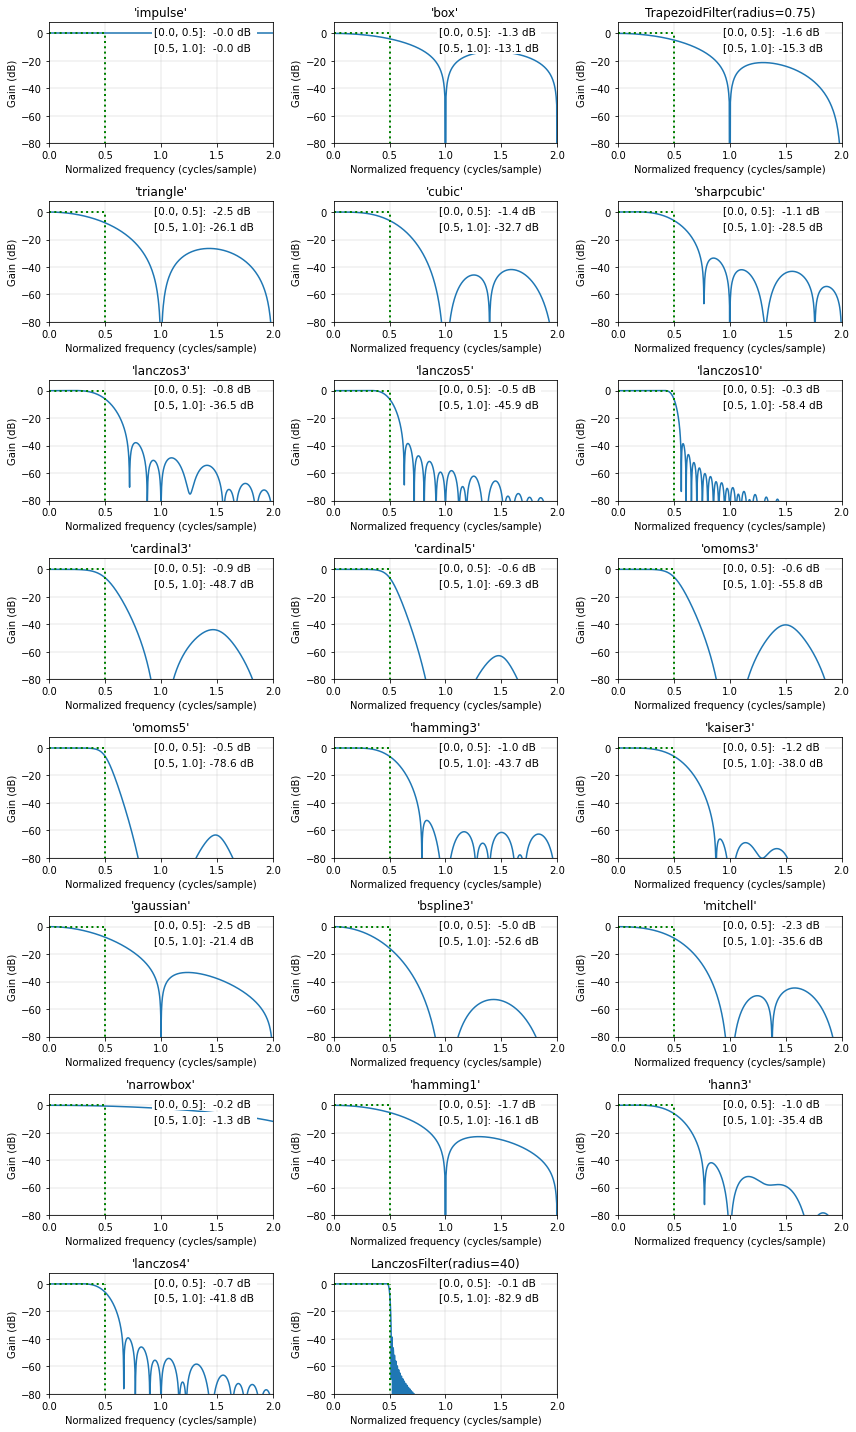

In [132]:
if EFFORT >= 1:
  visualize_filter_frequency_response(
      {f"'{name}'": filter for name, filter in resampler._DICT_FILTERS.items()}
      | {'LanczosFilter(radius=40)': resampler.LanczosFilter(radius=40)}
  )

A good filter should have:
1. Small loss (high gain) below the Nyquist frequency (0.5), to maximize sharpness.
2. Strong attenuation (low gain) above the Nyquist frequency (0.5), to minimize aliasing.

Correspondingly, in the power spectrum plots above, we measure the average dB gain in the frequency ranges $[0.0, 0.5]$ and $[0.5, 1.0]$.

These averages are computed in the space of power dB values and are obtained using integrals over frequency.
(Alternatives would have been to average the amplitudes (or squared amplitudes) and/or to integrate over log frequency.)
These current measurements ignore aliasing due to frequencies above 1.0.

In [133]:
# A faster FFT implementation for our case in which the input is both real and symmetric:
# "An efficient FFT algorithm for real-symmetric data" https://ieeexplore.ieee.org/document/226669
# but it is not available in numpy.
# Also, https://tomroelandts.com/articles/how-to-plot-the-frequency-response-of-a-filter
# https://reference.wolfram.com/language/ref/LanczosWindow.html

## Try other filters

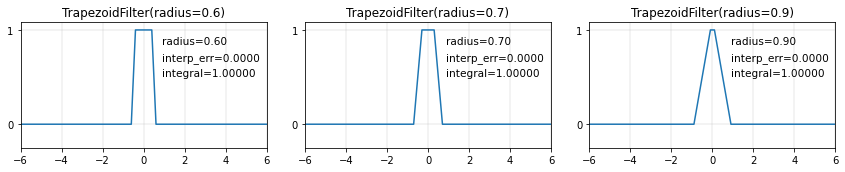

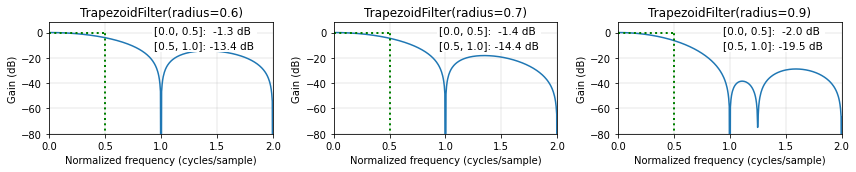

In [134]:
def visualize_trapezoid_filters() -> None:
  """This shows how the trapezoid filter morphs between the box and triangle filters."""
  filters = {
      f'TrapezoidFilter({radius=})': resampler.TrapezoidFilter(radius=radius)
      for radius in [0.6, 0.7, 0.9]
  }
  visualize_filters(filters)
  visualize_filter_frequency_response(filters)


visualize_trapezoid_filters()

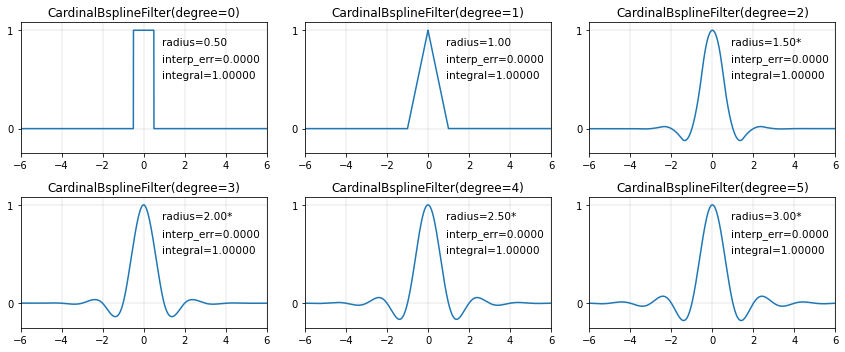

\* The effective radius is actually infinite due to the inverse convolution of the digital filter.

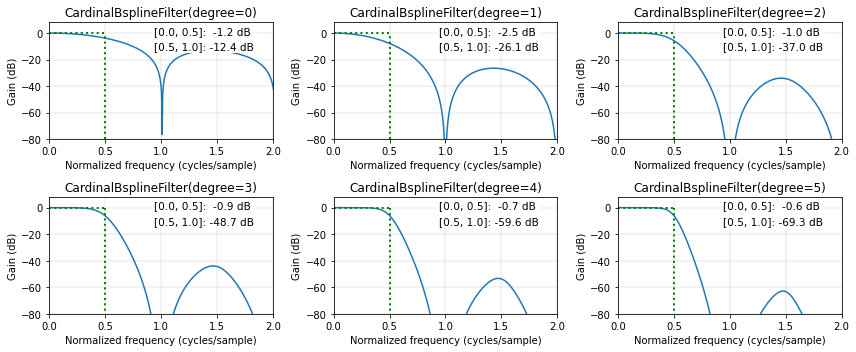

In [135]:
def visualize_cardinal_bsplines() -> None:
  filters = {
      f'CardinalBsplineFilter({degree=})': resampler.CardinalBsplineFilter(degree=degree)
      for degree in range(6)
  }
  visualize_filters(filters)
  visualize_filter_frequency_response(filters)


if EFFORT >= 1:
  visualize_cardinal_bsplines()

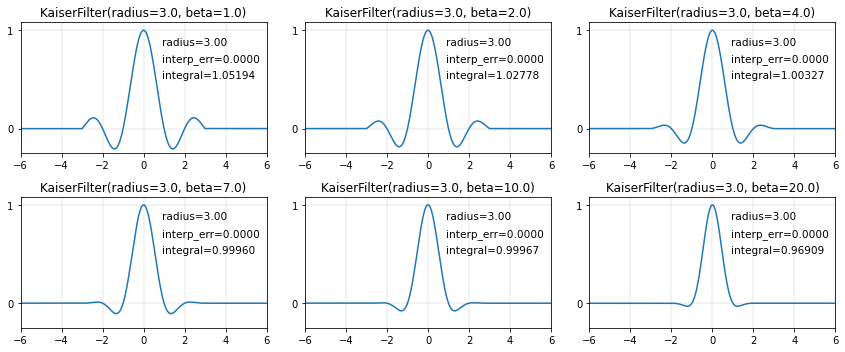

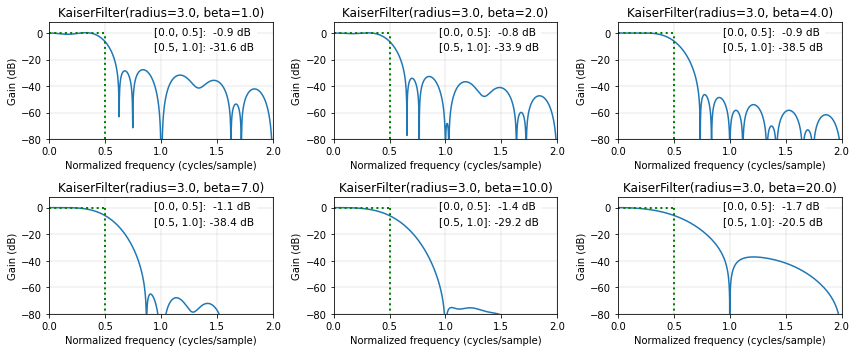

In [136]:
def visualize_kaiser_filter_for_various_beta_values(radius=3.0) -> None:
  filters = {
      f'KaiserFilter({radius=}, {beta=})': resampler.KaiserFilter(radius=radius, beta=beta)
      for beta in [1.0, 2.0, 4.0, 7.0, 10.0, 20.0]
  }
  visualize_filters(filters)
  visualize_filter_frequency_response(filters)


if EFFORT >= 1:
  visualize_kaiser_filter_for_various_beta_values()

In [137]:
def experiment_kaiser_filter_beta_parameters(n: int = 12, s: float = 2.0) -> None:
  """Compute attenuation and beta for number of taps `n` and sampling rate `s`."""
  # The two filter parameters are the number n of taps and the filter
  # half-width f_h.  The filter half-width f_h defines transition band;
  # high f_h in the low-res layers to maximize attenuation in the stopband;
  # low f_h in hig-res layers to recover image detail.
  for f_h in [s / 2, (np.sqrt(2) - 1) * (s / 2)]:
    # L is the spatial extent of the filter (2*radius); s is the sampling rate.
    # n is the number of discrete taps: odd for primal and even for dual.
    # L = 2 * radius = (n - 1) / s
    # Example: dual 2x upsampling; n=12; s=2; L=11/2; radius=11/4
    # Width of the transition band expressed as a fraction of s:
    delta_f = 2 * f_h / (s / 2)
    A = 2.285 * (n - 1) * np.pi * delta_f + 7.9  # Attenuation in dB.
    beta = (
        0.1102 * (A - 8.7)
        if A > 50
        else 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
        if 21 <= A <= 50
        else 0.0
    )
    print(f'{f_h=}, {delta_f=}, {A=}, {beta=}')


experiment_kaiser_filter_beta_parameters()

f_h=1.0, delta_f=2.0, A=165.8278626959589, beta=17.315490469094673
f_h=np.float64(0.41421356237309515), delta_f=np.float64(0.8284271247461903), A=np.float64(73.31586260526218), beta=np.float64(7.120668059099892)


In [138]:
def test_kaiser_filter_fractional_radius(radius=3, s=2.0, n=12, debug=False) -> None:
  i = np.arange(n, dtype=np.float64)
  x = (i - (n - 1) / 2) / s
  x = abs(x)
  beta = 4.0
  L = (n - 1) / s
  window = np.i0(beta * np.sqrt((1.0 - np.square(x / (L / 2))).clip(0.0, 1.0))) / np.i0(beta)
  f1 = np.where(x < radius, resampler._sinc(x) * window, 0.0)
  f2 = resampler.KaiserFilter(radius=3, beta=beta)(x)
  f3 = resampler.KaiserFilter(radius=L / 2, beta=beta)(x)  # L/2 == 2.75
  if debug:
    print(np.i0([0.0, 4.0]))
    print(f'{i=}, {x=}, {L=}, {window=}, {f1=}, {f2=}, {f3=}')
  assert np.allclose(f1, f3)


test_kaiser_filter_fractional_radius()

## Visualization of boundary rules

In [139]:
def visualize_boundary_rules_in_1d(
    *, resizer=resampler.resize, gridtype='dual', filters=None, boundaries=None, cval=0.6
) -> None:
  filters = ['box', 'triangle', 'lanczos3', 'cardinal5'] if filters is None else filters
  boundaries = resampler._OFTUSED_BOUNDARIES if boundaries is None else boundaries
  num_samples = 400
  scale = 0.47
  offset = (1 - scale) / 2 / scale
  color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

  for row_index, filter in enumerate(filters):
    filter = resampler._find_closest_filter(filter, resizer)
    fig, axs = plt.subplots(1, len(boundaries), figsize=(18, 1.5))
    axes = typing.cast(np.ndarray[Any, Any], axs).flat
    fig.subplots_adjust(wspace=0.1)
    array = np.array([0.2, 0.1, 0.4, 0.5])

    for column_index, boundary in enumerate(boundaries):
      ax = axes[column_index]

      params = dict(filter=filter, boundary=boundary, cval=cval)
      if resizer is resampler.resize:
        params |= dict(src_gridtype=gridtype, dst_gridtype='dual')
      else:
        assert gridtype == 'dual'
      x = None
      discrepancy = False

      try:  # See if the filter supports `scale` and `translate` parameters (else TypeError).
        params2 = params | dict(scale=scale, translate=(1 - scale) / 2)
        resized = resizer(array, (num_samples,), **params2)
        if resizer is not resampler.resize:
          reference = resampler.resize(array, (num_samples,), **params2)
        x = (np.arange(len(resized)) + 0.5) / len(resized) / scale - offset
      except (ValueError, TypeError):
        pass

      if x is None:
        try:  # See if the filter supports this particular `boundary`.
          resized = resizer(array, (num_samples,), **params)
          if resizer is not resampler.resize:
            reference = resampler.resize(array, (num_samples,), **params)
          x = (np.arange(len(resized)) + 0.5) / len(resized)
        except ValueError:
          pass

      if x is None:
        ax.plot([])
        ax.text(0.5, 0.5, 'Unavailable', transform=ax.transAxes, ha='center', va='center')

      else:
        for x_value in [0.0, 1.0]:
          ax.axvline(x=x_value, ymin=0.0, ymax=0.77, color='red', linestyle='--', linewidth=1)
        ax.plot(x, resized, '-', color=color, label=boundary)
        x2 = resampler._get_gridtype(gridtype).point_from_index(np.arange(len(array)), len(array))
        ax.plot(x2, array, 'o', color=color)

        if resizer is not resampler.resize:
          big_error = heapq.nlargest(4, abs(np.asarray(resized) - reference))[-1]
          if big_error > 1e-6:
            discrepancy = True
            text = f'maxerr = {big_error:8.6f}'
            ax.text(0.15, 0.86, text, transform=ax.transAxes, color='red')
            # hh.show(np.asarray(resized) - reference)

      ax.set(xlim=(-offset, 1.0 + offset), ylim=(-0.05, 0.75), xticks=[0, 1], yticks=[])
      if row_index == 0:
        dagger = r'$^\dagger$' if gridtype == 'primal' and boundary == 'wrap' else ''
        s_boundary = {'quadratic_constant': 'quadratic_const.'}.get(boundary, boundary)
        title = f"{'boundary=' if column_index == 0 else ''}'{s_boundary}'{dagger}"
        ax.set_title(title, x=0.5, y=1.05, fontsize=14)
      expected_discrepancy = (
          resizer in [resampler.scipy_ndimage_resize, resampler.skimage_transform_resize]
          and boundary in ['clamp', 'border']
          and filter not in ['box', 'triangle']
      ) or (resizer is resampler.scipy_ndimage_resize and boundary == 'border')
      assert discrepancy == expected_discrepancy, (resizer, filter, boundary, discrepancy)

    plt.subplots_adjust(left=0.035)
    # text = f"filter='{filter}'" if row_index == 0 else f"'{filter}'"
    plt.gcf().text(0.02, 0.55, f"'{filter}'", fontsize=14, rotation='vertical', va='center')
    plt.show()

**`gridtype='dual'`:**

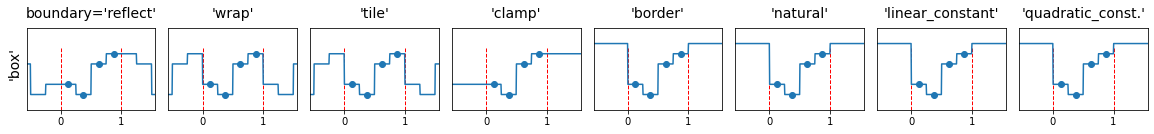

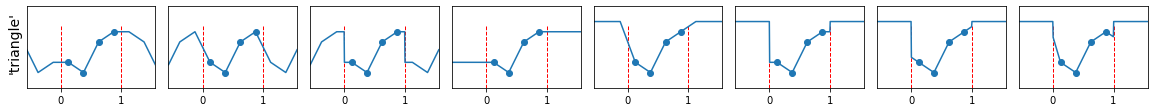

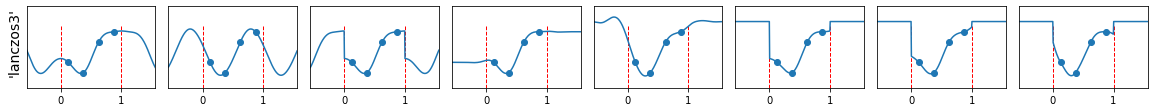

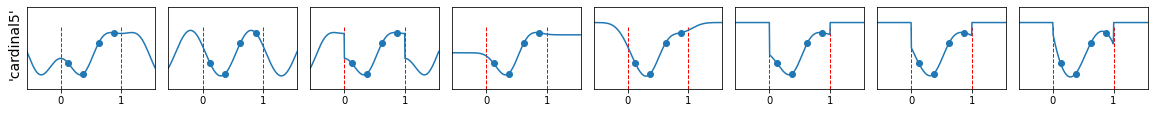

&emsp; &emsp; Graphics
    [texture sampling](https://www.khronos.org/opengl/wiki/Sampler_Object)
    supports a `'dual'` grid with the `'box'` or `'triangle'` filter, using the
    `'reflect'`, `'wrap'`, `'clamp'`, `'reflect_clamp'`, or `'border'` boundary.

<br/>**`gridtype='primal'`:**

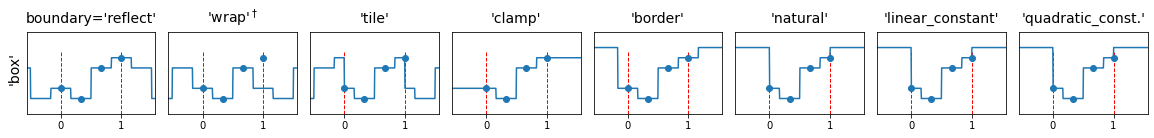

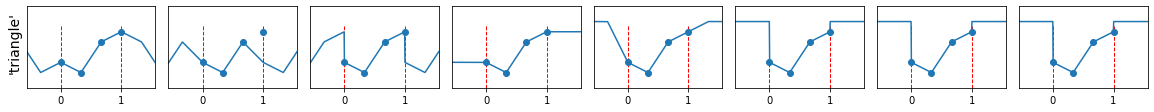

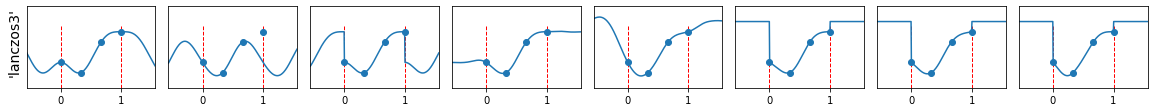

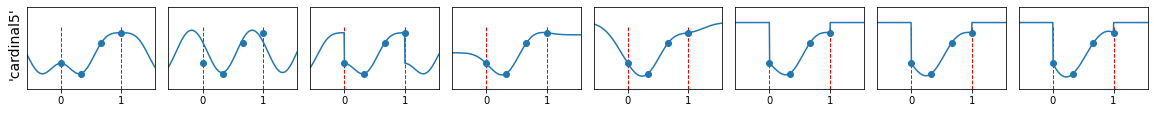

&emsp; &emsp; ${}^\dagger$To create a continuous periodic
    reconstruction, the last sample is ignored for the `'wrap'` boundary rule
    on a `'primal'` grid.

<br/>**For filters_summary figure:**

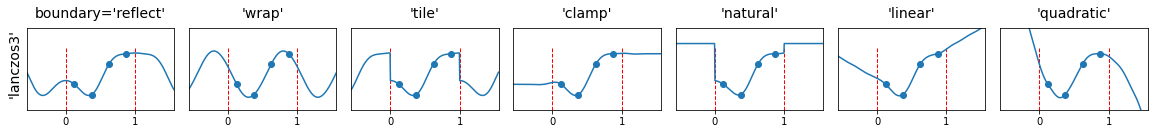

In [140]:
def visualize_all_boundary_rules_in_1d() -> None:
  """Create 1D boundary rule plots similar to
  https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html#ndimage-interpolation-modes"""
  hh.no_vertical_scroll()

  display_markdown("**`gridtype='dual'`:**")
  visualize_boundary_rules_in_1d()
  display_markdown(
      """&emsp; &emsp; Graphics
    [texture sampling](https://www.khronos.org/opengl/wiki/Sampler_Object)
    supports a `'dual'` grid with the `'box'` or `'triangle'` filter, using the
    `'reflect'`, `'wrap'`, `'clamp'`, `'reflect_clamp'`, or `'border'` boundary."""
  )

  display_markdown("<br/>**`gridtype='primal'`:**")
  visualize_boundary_rules_in_1d(gridtype='primal')
  display_markdown(
      r"""&emsp; &emsp; ${}^\dagger$To create a continuous periodic
    reconstruction, the last sample is ignored for the `'wrap'` boundary rule
    on a `'primal'` grid."""
  )

  display_markdown('<br/>**For filters_summary figure:**')
  boundaries = 'reflect wrap tile clamp natural linear quadratic'.split()
  visualize_boundary_rules_in_1d(filters=['lanczos3'], boundaries=boundaries)


if EFFORT >= 1:
  visualize_all_boundary_rules_in_1d()

**Upsampling of a 2D grid (`gridtype=('dual', 'primal')`, for $y$ and $x$ axes respectively)**


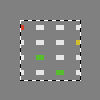
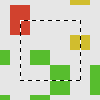
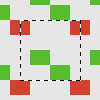
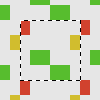
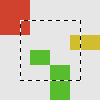
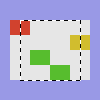
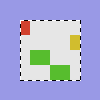
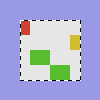
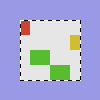


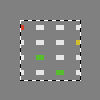
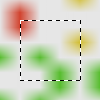
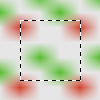
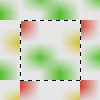
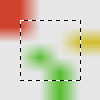
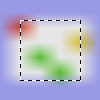
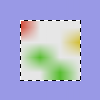
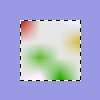
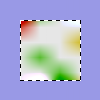


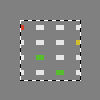
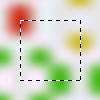
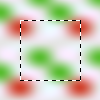
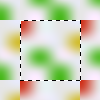
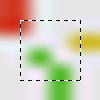
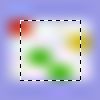
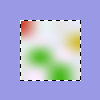
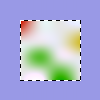
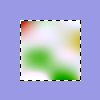


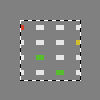
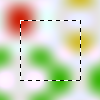
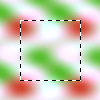
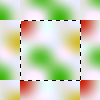
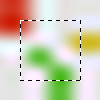
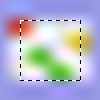
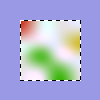
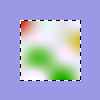
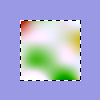

<br/>**Wider view of the same results**


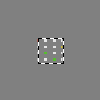
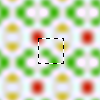
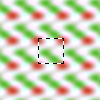
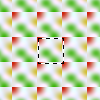
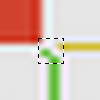
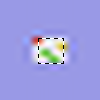
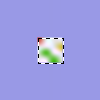
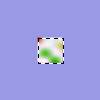
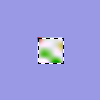

In [141]:
def visualize_boundary_rules_in_2d(
    *, scale=0.6, src_gridtype=('dual', 'primal'), cval=(0.6, 0.6, 0.9)
) -> None:
  hh.no_vertical_scroll()
  shape = (120, 120) if hh.in_colab() else (100, 100)
  if 1:
    # In Colab, the defined HTML style is local to each cell (iframe), whereas in jupyter the
    # style is global across all cells.
    text = """
      <style>
        table.show_images2 { font-size: FONT-SIZE; }
        table.show_images2 div div:nth-of-type(2) { padding-top: 5px; }
        .show_images2 td { padding:1px; }
      </style>
    """.replace(
        'FONT-SIZE', 'medium' if hh.in_colab() else 'small'
    )
    hh.display_html(text)

  # array = np.array([[1.0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 1, 0, 0]])
  # array = np.indices((4, 4), np.float64).sum(axis=0) / 6.0
  # array = np.dstack((array,) * 3)
  o, a, b, c = (0.0, 0.0, 0.0), (1.0, 0.3, 0.2), (0.4, 1.0, 0.2), (0.8, 0.7, 0.1)
  o, a, b, c = (1.0, 1.0, 1.0), (0.9, 0.2, 0.1), (0.3, 0.8, 0.1), (0.9, 0.8, 0.1)
  array = np.array([[a, o, o, o], [o, o, o, c], [o, b, o, o], [o, o, b, o]])
  # array = array * 0.5 + 0.25
  array = array * 0.8 + 0.1

  def show_row(*, scale=scale) -> None:
    kwargs = dict(
        shape=shape,
        src_gridtype=src_gridtype,
        dst_gridtype='dual',
        scale=scale,
        translate=(1 - scale) / 2,
    )
    images = {}
    for boundary in resampler._OFTUSED_BOUNDARIES:
      name = {'quadratic_constant': 'quadratic_const.'}.get(boundary, boundary)
      images[f"'{name}'"] = resize_showing_domain_boundary(
          array, boundary=boundary, cval=cval, filter=filter, **kwargs
      )
    image_samples = resize_showing_domain_boundary(
        array, boundary='constant', cval=0.5, filter='narrowbox', **kwargs
    )
    images = {'(samples)': image_samples} | images
    images2: Any = images if row_index == 0 else images.values()
    # Benefit of show_images() over matplotlib.imshow() is no pixel resampling.
    ylabel = f"filter='{filter}'&nbsp;&nbsp;&nbsp" if row_index == 0 else f"'{filter}'"
    media.show_images(images2, ylabel=ylabel, html_class='show_images2')

  display_markdown(
      "**Upsampling of a 2D grid (`gridtype=('dual', 'primal')`,"
      ' for $y$ and $x$ axes respectively)**'
  )
  for row_index, filter in enumerate('box triangle cubic lanczos3'.split()):
    show_row()

  display_markdown('<br/>**Wider view of the same results**')
  row_index = 0
  filter = 'lanczos3'
  show_row(scale=0.25)


visualize_boundary_rules_in_2d()

## Best boundary rule for resize

In [142]:
def compare_boundary_rules_on_cropped_windows_of_images(
    images, scale, filter, num_windows, reference_filter='lanczos5', name=''
) -> None:
  """Determine the best boundary rule for resizing windows within images.

  The approach is to generate many random cropped windows from each image,
  obtain a groundtruth for the resized window from the *uncropped* content,
  and measure the MSE of the resized crop with respect to this groundtruth.

  All filtering is done in lightness space (i.e. with gamma='identity').
  """
  rng = np.random.default_rng(0)
  # Note: 'linear' and 'linear_constant' are identical for resampler.resize() because the evaluated
  # coordinate is never outside the domain (even though the filter kernel does extend outside).
  boundaries = [
      boundary
      for boundary in resampler.BOUNDARIES
      if 'constant' not in boundary and boundary not in 'wrap tile reflect_clamp border'.split()
  ]

  all_mse = collections.defaultdict(list)
  for image in images:
    for _ in range(num_windows):
      shape = 24, 48
      pad = 6 if scale == 5 / 6 else int(math.ceil(6 / min(scale, 1.0)))
      scaled_pad = must_be_int(pad * scale).item()
      broad_shape = shape[0] + pad * 2, shape[1] + pad * 2
      yx = (
          rng.integers(image.shape[0] - broad_shape[0]),
          rng.integers(image.shape[1] - broad_shape[1]),
      )
      broad_window = image[
          tuple(slice(start, start + size) for start, size in zip(yx, broad_shape))
      ]
      window = broad_window[pad:-pad, pad:-pad]
      pixel_offset = 0 if scale != 1 else 0.25  # Quarter-pixel translation.

      new_broad_shape = must_be_int(np.array(broad_window.shape[:2]) * scale)
      reference = resampler.resize(
          broad_window,
          new_broad_shape,
          boundary='clamp',
          filter=reference_filter,
          translate=(pixel_offset / new_broad_shape),
      )
      reference = reference[scaled_pad:-scaled_pad, scaled_pad:-scaled_pad]

      images = {}
      for boundary in boundaries:
        new_shape = must_be_int(np.array(window.shape[:2]) * scale)
        resized = resampler.resize(
            window,
            new_shape,
            boundary=boundary,
            filter=filter,
            translate=(pixel_offset / new_shape),
        )
        with np.errstate(under='ignore'):
          mse = np.square(resized - reference).mean()
        all_mse[boundary].append(mse)

  all_psnr = {
      boundary: 10 * np.log10(1.0 / (np.mean(mse) + 1e-20)) for boundary, mse in all_mse.items()
  }
  psnr_sorted = sorted([(psnr, boundary) for boundary, psnr in all_psnr.items()], reverse=True)
  best_psnr, best_boundary = psnr_sorted[0]
  print(f'# Best rule for {scale=:.3f} {name=!s} (PSNR) (best={best_boundary}):')
  for psnr, boundary in psnr_sorted:
    print(f'# {boundary:15} {psnr:5.2f} dB')
  if 1:
    if scale > 1.0:
      assert best_boundary == 'reflect'
    if scale <= 1.0:
      assert all_psnr['clamp'] >= best_psnr - 0.12


def experiment_compare_accuracy_of_boundary_rules_using_cropped_windows(
    filters=('lanczos3',),
    num_windows=1_000,
    combined=True,
    scales=(2, 7 / 6, 1, 5 / 6, 1 / 2, 1 / 6),
) -> None:
  images = {
      'photo1': media.to_float01(EXAMPLE_PHOTO),  # (480, 640)
      'vector1': media.to_float01(example_vector_graphics_image()),  # (3300, 2550)
  }
  for filter in filters:
    print(f'# # Results for {num_windows=} {filter=!s}:\n')
    for scale in scales:
      kwargs = dict(scale=scale, filter=filter, num_windows=num_windows)
      if combined:
        compare_boundary_rules_on_cropped_windows_of_images(images.values(), name='all', **kwargs)
      else:
        for name, image in images.items():
          compare_boundary_rules_on_cropped_windows_of_images([image], name=name, **kwargs)
      print()


if EFFORT >= 2:
  experiment_compare_accuracy_of_boundary_rules_using_cropped_windows(
      filters=['lanczos3', 'trapezoid', 'cubic']
  )
elif EFFORT >= 1:
  experiment_compare_accuracy_of_boundary_rules_using_cropped_windows(
      num_windows=40, scales=[2, 7 / 6, 1, 5 / 6, 1 / 2]
  )

# # Results for num_windows=40 filter=lanczos3:

# Best rule for scale=2.000 name=all (PSNR) (best=reflect):
# reflect         40.41 dB
# clamp           40.39 dB
# natural         40.27 dB
# linear          39.53 dB
# quadratic       37.82 dB

# Best rule for scale=1.167 name=all (PSNR) (best=reflect):
# reflect         42.91 dB
# clamp           42.90 dB
# natural         42.67 dB
# linear          42.53 dB
# quadratic       41.66 dB

# Best rule for scale=1.000 name=all (PSNR) (best=reflect):
# reflect         40.38 dB
# clamp           40.36 dB
# natural         40.24 dB
# linear          39.61 dB
# quadratic       38.19 dB

# Best rule for scale=0.833 name=all (PSNR) (best=linear):
# linear          43.77 dB
# clamp           43.77 dB
# quadratic       43.73 dB
# natural         43.70 dB
# reflect         43.43 dB

# Best rule for scale=0.500 name=all (PSNR) (best=clamp):
# clamp           40.30 dB
# linear          40.07 dB
# reflect         39.82 dB
# natural         39.75 dB
# 

Conclusions (particularly from the slower results archived in the next cell):
- `'reflect'` is the best boundary rule for upsamping, and
- `'clamp'` is always among the best boundary rules for downsampling,
  especially for `'lanczos3'`.
- For downsampling with smaller filter kernels like `'cubic'`,
  the rules `'linear'` and `'reflect'` also work well.

In [143]:
# # Results for num_windows=1000 filter=lanczos3:

# Best rule for scale=2.000 name=all (PSNR) (best=reflect):
# reflect         40.38 dB
# clamp           40.32 dB
# natural         40.22 dB
# linear          39.62 dB
# quadratic       38.20 dB

# Best rule for scale=1.167 name=all (PSNR) (best=reflect):
# reflect         43.21 dB
# clamp           43.20 dB
# natural         42.97 dB
# linear          42.86 dB
# quadratic       42.09 dB

# Best rule for scale=1.000 name=all (PSNR) (best=reflect):
# reflect         40.36 dB
# clamp           40.29 dB
# natural         40.19 dB
# linear          39.61 dB
# quadratic       38.23 dB

# Best rule for scale=0.833 name=all (PSNR) (best=linear):
# linear          44.11 dB
# clamp           44.11 dB
# quadratic       44.04 dB
# natural         44.03 dB
# reflect         43.86 dB

# Best rule for scale=0.500 name=all (PSNR) (best=clamp):
# clamp           40.06 dB
# linear          39.88 dB
# natural         39.63 dB
# reflect         39.60 dB
# quadratic       38.63 dB

# Best rule for scale=0.167 name=all (PSNR) (best=clamp):
# clamp           34.76 dB
# natural         33.79 dB
# reflect         33.56 dB
# linear          32.71 dB
# quadratic       23.10 dB

# # Results for num_windows=1000 filter=trapezoid:

# Best rule for scale=2.000 name=all (PSNR) (best=reflect):
# reflect         27.37 dB
# quadratic       27.37 dB
# natural         27.37 dB
# linear          27.37 dB
# clamp           27.37 dB

# Best rule for scale=1.167 name=all (PSNR) (best=reflect):
# reflect         32.38 dB
# quadratic       32.38 dB
# linear          32.38 dB
# clamp           32.38 dB
# natural         32.38 dB

# Best rule for scale=1.000 name=all (PSNR) (best=linear):
# linear          31.79 dB
# reflect         31.68 dB
# natural         31.68 dB
# clamp           31.68 dB
# quadratic       31.31 dB

# Best rule for scale=0.833 name=all (PSNR) (best=linear):
# linear          32.71 dB
# reflect         32.71 dB
# clamp           32.71 dB
# quadratic       32.71 dB
# natural         32.71 dB

# Best rule for scale=0.500 name=all (PSNR) (best=reflect):
# reflect         32.58 dB
# quadratic       32.58 dB
# natural         32.58 dB
# linear          32.58 dB
# clamp           32.58 dB

# Best rule for scale=0.167 name=all (PSNR) (best=reflect):
# reflect         27.98 dB
# quadratic       27.98 dB
# natural         27.98 dB
# linear          27.98 dB
# clamp           27.98 dB

# # Results for num_windows=1000 filter=cubic:

# Best rule for scale=2.000 name=all (PSNR) (best=reflect):
# reflect         36.31 dB
# natural         36.28 dB
# clamp           36.26 dB
# linear          36.14 dB
# quadratic       35.40 dB

# Best rule for scale=1.167 name=all (PSNR) (best=reflect):
# reflect         37.30 dB
# natural         37.30 dB
# clamp           37.30 dB
# linear          37.29 dB
# quadratic       37.23 dB

# Best rule for scale=1.000 name=all (PSNR) (best=reflect):
# reflect         36.21 dB
# natural         36.19 dB
# clamp           36.17 dB
# linear          36.06 dB
# quadratic       35.37 dB

# Best rule for scale=0.833 name=all (PSNR) (best=quadratic):
# quadratic       37.79 dB
# linear          37.75 dB
# reflect         37.75 dB
# clamp           37.73 dB
# natural         37.71 dB

# Best rule for scale=0.500 name=all (PSNR) (best=linear):
# linear          35.00 dB
# reflect         34.95 dB
# quadratic       34.94 dB
# clamp           34.93 dB
# natural         34.73 dB

# Best rule for scale=0.167 name=all (PSNR) (best=clamp):
# clamp           32.31 dB
# reflect         31.96 dB
# linear          31.95 dB
# natural         31.69 dB
# quadratic       22.36 dB

## Best filter for resize
<a name="Best-filter-for-resize"></a>

In [144]:
def experiment_best_downsampling_filter(scale=0.4, clip=False, debug=False) -> None:
  images = [
      media.to_float01(EXAMPLE_PHOTO),  # (480, 640)
      media.to_float01(example_vector_graphics_image())[220:980, 210:1240][:, :500],
      # (3300, 2550) -> (760, 1030) -> (760, 500)
  ]
  crop = [np.s_[100:120, 141:161], np.s_[531:551, 143:163]]
  filters = (
      'box trapezoid triangle mitchell cubic hamming3 cardinal3 lanczos3 omoms5 lanczos10'
  ).split()
  cropped: list[dict[str, _NDArray]] = [{} for _ in range(len(images))]
  filter_psnrs, filter_ssims = {}, {}
  print('# PSNR and SSIM results for (1) natural photos and (2) vector graphics:')
  for filter in filters:
    all_psnr, all_ssim = [], []
    for image_index, image in enumerate(images):
      new_shape = (np.array(image.shape[:2]) * scale + 0.5).astype(int)
      downsampled = resampler.resize(image, new_shape, filter=filter)
      if clip:
        downsampled = downsampled.clip(0.0, 1.0)
      reconstructed = resampler.resize(downsampled, image.shape[:2], filter='lanczos3')
      if clip:
        reconstructed = reconstructed.clip(0.0, 1.0)
      cropped[image_index][f"'{filter}'"] = reconstructed[crop[image_index]]
      mse = np.square(reconstructed - image).mean()
      all_psnr.append(10 * np.log10(1.0 / (mse + 1e-20)))
      all_ssim.append(get_ssim(reconstructed, image))

    filter_psnrs[filter] = all_psnr
    filter_ssims[filter] = all_ssim
    str_psnr = ' '.join(f'{psnr:5.2f}' for psnr in all_psnr)
    str_ssim = ' '.join(f'{ssim:5.3f}' for ssim in all_ssim)
    print(
        f'# {filter:10} PSNR:({str_psnr}) mean={np.mean(all_psnr):5.2f}'
        f'  SSIM:({str_ssim}) mean={np.mean(all_ssim):5.3f}'
    )

  for image_dict in cropped:
    media.show_images(image_dict, border=True, height=100)
  if debug:
    GRAY_FROM_RGB = [0.2989, 0.5870, 0.1140]
    array = media.to_uint8(cropped[1]['lanczos10'] @ GRAY_FROM_RGB)
    show_grid_values(array, figsize=(10, 14))
  if 1:
    best_psnr_filters = [
        sorted(filter_psnrs, key=lambda filter: filter_psnrs[filter][i])[-1]
        for i in range(len(images))
    ]
    assert best_psnr_filters == ['lanczos10', 'lanczos10'], best_psnr_filters
    best_ssim_filters = [
        sorted(filter_ssims, key=lambda filter: filter_ssims[filter][i])[-1]
        for i in range(len(images))
    ]
    assert best_ssim_filters == ['lanczos10', 'trapezoid'], best_ssim_filters


if EFFORT >= 1:
  experiment_best_downsampling_filter()

# PSNR and SSIM results for (1) natural photos and (2) vector graphics:
# box        PSNR:(23.89 18.28) mean=21.08  SSIM:(0.733 0.864) mean=0.799
# trapezoid  PSNR:(24.24 18.76) mean=21.50  SSIM:(0.742 0.874) mean=0.808
# triangle   PSNR:(23.87 18.02) mean=20.94  SSIM:(0.712 0.858) mean=0.785
# mitchell   PSNR:(23.97 18.22) mean=21.10  SSIM:(0.719 0.860) mean=0.789
# cubic      PSNR:(24.32 18.87) mean=21.60  SSIM:(0.744 0.870) mean=0.807
# hamming3   PSNR:(24.44 19.07) mean=21.76  SSIM:(0.753 0.865) mean=0.809
# cardinal3  PSNR:(24.46 19.10) mean=21.78  SSIM:(0.754 0.864) mean=0.809
# lanczos3   PSNR:(24.47 19.12) mean=21.80  SSIM:(0.756 0.862) mean=0.809
# omoms5     PSNR:(24.52 19.21) mean=21.87  SSIM:(0.759 0.853) mean=0.806
# lanczos10  PSNR:(24.53 19.22) mean=21.88  SSIM:(0.759 0.834) mean=0.797


In [145]:
# Copy of results 2023-12-02:
# PSNR and SSIM results for (1) natural photos and (2) vector graphics:
# box        PSNR:(23.89 18.29) mean=21.09  SSIM:(0.733 0.865) mean=0.799
# trapezoid  PSNR:(24.24 18.76) mean=21.50  SSIM:(0.742 0.874) mean=0.808
# triangle   PSNR:(23.87 18.02) mean=20.94  SSIM:(0.712 0.858) mean=0.785
# mitchell   PSNR:(23.97 18.22) mean=21.10  SSIM:(0.719 0.860) mean=0.789
# cubic      PSNR:(24.32 18.87) mean=21.60  SSIM:(0.744 0.870) mean=0.807
# hamming3   PSNR:(24.44 19.07) mean=21.76  SSIM:(0.753 0.865) mean=0.809
# cardinal3  PSNR:(24.46 19.10) mean=21.78  SSIM:(0.754 0.864) mean=0.809
# lanczos3   PSNR:(24.47 19.12) mean=21.80  SSIM:(0.756 0.862) mean=0.809
# omoms5     PSNR:(24.52 19.21) mean=21.87  SSIM:(0.759 0.853) mean=0.806
# lanczos10  PSNR:(24.53 19.22) mean=21.88  SSIM:(0.759 0.834) mean=0.797

Conclusions for downsampling (including several surprises):
- The `'lanczos10'` filter has the best PSNR and SSIM result on natural photos.
- However, on *vector* graphics, **`'trapezoid'` has the best SSIM score**,
  and `'lanczos10'` is terrible due to ringing.
- The `'trapezoid'` filter has a PSNR result that is comparable to that of `'cubic'`,
  although it is not as good as `'lanczos3'`.
- The `'mitchell'` filter is inferior to `'cubic'` on all images, for both MSE and SSIM.
- Clipping the image pixel values (to `[0, 1]` using `clip=True`) has little visual effect.
  For the vector graphics, it reduces PSNR but helps SSIM.
- The cardinal B-spline and O-MOMS filters behave similar to Lanczos.
- Overall, `'trapezoid'` is best for downsampling vector graphics, and
  `'lanczos3'` is a good choice for downsampling natural images like photos.

In [146]:
def experiment_best_upsampling_filter(scale=2.0, clip=False, debug=False) -> None:
  images = [
      media.to_float01(EXAMPLE_PHOTO),  # (480, 640)
      media.to_float01(example_vector_graphics_image())[220:980, 210:1240][:, :500],
      # (3300, 2550) -> (760, 1030) -> (760, 500)
  ]
  crop = [np.s_[100:120, 141:161], np.s_[531:551, 143:163]]
  filters = 'cubic hamming3 cardinal3 lanczos3 lanczos5 omoms5 lanczos10'.split()
  cropped: list[dict[str, _NDArray]] = [{} for _ in range(len(images))]
  filter_psnrs, filter_ssims = {}, {}
  print('# PSNR and SSIM results for (1) natural photos and (2) vector graphics:')
  for filter in filters:
    all_psnr, all_ssim = [], []
    for image_index, image in enumerate(images):
      new_shape = (np.array(image.shape[:2]) / scale + 0.5).astype(int)
      # As analyzed above, best prefilters for photos and vector graphics:
      prefilter = {0: 'lanczos5', 1: 'trapezoid'}[image_index]
      downsampled = resampler.resize(image, new_shape, filter=prefilter)
      if clip:
        downsampled = downsampled.clip(0.0, 1.0)
      reconstructed = resampler.resize(downsampled, image.shape[:2], filter=filter)
      if clip:
        reconstructed = reconstructed.clip(0.0, 1.0)
      cropped[image_index][f"'{filter}'"] = reconstructed[crop[image_index]]
      mse = np.square(reconstructed - image).mean()
      all_psnr.append(10 * np.log10(1.0 / (mse + 1e-20)))
      all_ssim.append(get_ssim(reconstructed, image))

    filter_psnrs[filter] = all_psnr
    filter_ssims[filter] = all_ssim
    str_psnr = ' '.join(f'{psnr:5.2f}' for psnr in all_psnr)
    str_ssim = ' '.join(f'{ssim:5.3f}' for ssim in all_ssim)
    print(
        f'# {filter:10} PSNR:({str_psnr}) mean={np.mean(all_psnr):5.2f}'
        f'  SSIM:({str_ssim}) mean={np.mean(all_ssim):5.3f}'
    )

  for image_dict in cropped:
    media.show_images(image_dict, border=True, height=100)
  if debug:
    GRAY_FROM_RGB = [0.2989, 0.5870, 0.1140]
    array = media.to_uint8(cropped[1]['lanczos10'] @ GRAY_FROM_RGB)
    show_grid_values(array, figsize=(10, 14))
  if 1:
    sorted_psnr_filters = [
        sorted(filter_psnrs, key=lambda filter: filter_psnrs[filter][i], reverse=True)
        for i in range(len(images))
    ]
    best_psnr_filters = [sorted_psnr_filters[0][0], sorted_psnr_filters[1][0]]
    assert best_psnr_filters == ['lanczos10', 'lanczos5'], best_psnr_filters
    assert filter_psnrs['lanczos3'][0] <= filter_psnrs[best_psnr_filters[0]][0] - 0.07
    sorted_ssim_filters = [
        sorted(filter_ssims, key=lambda filter: filter_ssims[filter][i], reverse=True)
        for i in range(len(images))
    ]
    best_ssim_filters = [sorted_ssim_filters[0][0], sorted_ssim_filters[1][0]]
    assert best_ssim_filters == ['lanczos10', 'hamming3'], best_ssim_filters
    assert filter_ssims['lanczos3'][1] <= filter_ssims[best_ssim_filters[1]][1] - 0.001


if EFFORT >= 1:
  experiment_best_upsampling_filter()

# PSNR and SSIM results for (1) natural photos and (2) vector graphics:
# cubic      PSNR:(25.60 20.54) mean=23.07  SSIM:(0.814 0.926) mean=0.870
# hamming3   PSNR:(25.84 20.93) mean=23.39  SSIM:(0.825 0.926) mean=0.876
# cardinal3  PSNR:(25.89 20.98) mean=23.43  SSIM:(0.827 0.925) mean=0.876
# lanczos3   PSNR:(25.90 21.05) mean=23.48  SSIM:(0.829 0.925) mean=0.877
# lanczos5   PSNR:(26.04 21.15) mean=23.60  SSIM:(0.834 0.912) mean=0.873
# omoms5     PSNR:(26.04 21.15) mean=23.60  SSIM:(0.834 0.912) mean=0.873
# lanczos10  PSNR:(26.09 21.11) mean=23.60  SSIM:(0.836 0.882) mean=0.859


In [147]:
# Copy of results 2023-12-02:
# PSNR and SSIM results for (1) natural photos and (2) vector graphics:
# cubic      PSNR:(25.60 20.54) mean=23.07  SSIM:(0.814 0.926) mean=0.870
# hamming3   PSNR:(25.84 20.93) mean=23.39  SSIM:(0.825 0.926) mean=0.876
# cardinal3  PSNR:(25.89 20.98) mean=23.43  SSIM:(0.827 0.925) mean=0.876
# lanczos3   PSNR:(25.90 21.05) mean=23.48  SSIM:(0.829 0.925) mean=0.877
# lanczos5   PSNR:(26.04 21.15) mean=23.60  SSIM:(0.834 0.912) mean=0.873
# omoms5     PSNR:(26.04 21.15) mean=23.60  SSIM:(0.834 0.912) mean=0.873
# lanczos10  PSNR:(26.09 21.11) mean=23.60  SSIM:(0.836 0.882) mean=0.859

Conclusions:
- For upsampling, the filters `'box'`, `'trapezoid'`, and `'mitchell'`
  perform so poorly that they are omitted in these results.
- On natural photos, `'lanczos10'` has the best PSNR and SSIM,
  although `'lanczos3'` is not too far behind.
- On vector graphics, `'lanczos5'` has the best PSNR,
  and `'cubic' / 'lanczos3'` have the best SSIM.
  The problem is that the higher-order Lanczos filters (`'lanczos5'` and `'lanczos10'`) introduce
  too much ringing near step discontinuities.
- The cardinal B-spline and O-MOMS filters have similar behavior to Lanczos.
- Overall, `'lanczos3'` performs well on all images,
  although `'lanczos10'` is best if the images are known to be natural photos.

## Best gamma for resampling


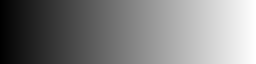
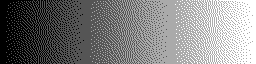
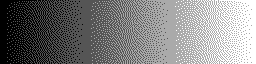

In [148]:
def dither(
    image: _NDArray, num_levels: int, offsets: Iterable[tuple[int, int]], weights: Iterable[float]
) -> _NDArray:
  """Dither an image.

  From https://github.com/scikit-image/skimage-demos/blob/main/dither.py and
  https://github.com/SixLabors/ImageSharp/blob/main/src/ImageSharp/Processing/Processors/Dithering/DHALF.TXT

  Args:
    image: Source image with float type.
    num_levels: Number of quantization levels.
    offsets: Tuples (dy, dx) over which the quantization error is distributed.
    weights: Weights for the propagated error.

  Returns:
    A new image containing values [0, 1, ..., num_levels - 1].
  """
  image = np.array(image)  # Intentional copy.
  _check_eq(image.ndim, 2)
  assert np.issubdtype(image.dtype, np.floating)
  offsets = tuple(offsets)
  weights = np.asarray(weights, np.float32)
  weights = tuple(weights / weights.sum())
  height, width = image.shape

  out = np.zeros_like(image, np.int32)
  for y in range(height):
    for x in range(width):
      # Quantize.
      out[y, x] = image[y, x] * (num_levels - np.finfo(float).eps)
      # Propagate the quantization residual.
      residual = image[y, x] - out[y, x] / (num_levels - 1)
      for (dy, dx), weight in zip(offsets, weights):
        yy, xx = y + dy, x + dx
        if yy < height and 0 <= xx < width:
          image[yy, xx] += residual * weight

  return out


def floyd_steinberg_dither(image: _NDArray, num_levels: int) -> _NDArray:
  offsets = [(0, 1), (1, -1), (1, 0), (1, 1)]
  weights = [7, 3, 5, 1]
  return dither(image, num_levels, offsets, weights)


def filter_lite_dither(image: _NDArray, num_levels: int) -> _NDArray:
  """Evaluate Sierra's "Filter Lite"."""
  offsets = [(0, 1), (1, -1), (1, 0)]
  weights = [2, 1, 1]
  return dither(image, num_levels, offsets, weights)


def experiment_visualize_dither() -> None:
  image = np.indices((64, 256))[1] / 255.0
  images = {'original': image}
  num_levels = 4
  results = {
      'sierra': filter_lite_dither(image, num_levels) / (num_levels - 1),
      'floyd': floyd_steinberg_dither(image, num_levels) / (num_levels - 1),
  }
  psnrs = {name: get_psnr(result, image) for name, result in results.items()}
  ssims = {name: get_ssim(result, image) for name, result in results.items()}
  for name, result in results.items():
    images |= {f'{name} ({psnrs[name]:.1f} dB) (SSIM {ssims[name]:.4f})': result}
  media.show_images(images, vmin=0, vmax=1, border=True)
  if 1:
    assert np.allclose(list(psnrs.values()), 17.4, atol=0.05)
    assert np.allclose(list(ssims.values()), [0.0917, 0.0931], atol=0.00005)


if EFFORT >= 1:
  experiment_visualize_dither()

Conclusion: The `floyd` dithering scheme is slightly better than `sierra` because it is a tiny bit more like the uniform original image in terms of its structure.


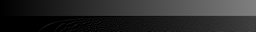
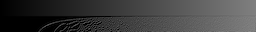

In [149]:
def experiment_gamma_downsample_image() -> None:
  new_shape = 32, 256
  ramp = np.indices((64, 1024))[1] / 2047.0
  num_levels = 2
  dithered = floyd_steinberg_dither(ramp**2.0, num_levels) / (num_levels - 1)
  image = np.concatenate([ramp, dithered], axis=0)
  lightness_space = resampler.resize(image, new_shape, gamma='identity')
  linear_space = resampler.resize(image, new_shape, gamma='power2')
  images = {
      "lightness space - 'identity'": lightness_space,
      "linear space - 'power2'": linear_space,
  }
  media.show_images(images, vmin=0, vmax=1, border=True)
  # This cannot be verified quantitatively, but must instead be visually confirmed.


experiment_gamma_downsample_image()

Conclusion: For downsampling, the best approach is to convert the source image from lightness
to linear space (using `src_gamma='power2'`), downsample, then convert back to lightness (using `dst_gamma='power2'`).
Setting the parameter `gamma='power2'` achieves both of those conversions.

In [150]:
def radial1(shape=(24, 48), frame_center=(0.75, 0.5), reference_shape=None) -> _NDArray:
  del reference_shape
  yx = (np.moveaxis(np.indices(shape), 0, -1) + (0.5, 0.5)) / min(shape)
  radius = np.linalg.norm(yx - frame_center, axis=-1)
  value = np.cos((radius + 0.1) ** 0.5 * 70.0) * 0.5 + 0.5
  return value  # linear space


def visualize_radial1() -> None:
  media.show_image(radial1(), height=200)
  assert np.allclose(std := np.std(radial1()), 0.358, atol=0.0005), std


visualize_radial1()


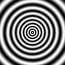
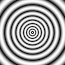
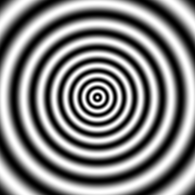

In [151]:
def chirp(
    shape=(65, 65),
    frame_center=(0.5, 0.5),
    period_at_center=2.0,
    period_at_border=4.0,
    reference_shape=None,
) -> _NDArray:
  reference_shape = reference_shape or shape
  yx = (np.moveaxis(np.indices(shape), 0, -1) + (0.5, 0.5)) / max(shape)
  radius = np.linalg.norm(yx - frame_center, axis=-1)
  t = radius / 0.5  # 0.0 at center, 1.0 at nearest original border
  period = (1.0 - t) * period_at_center + t * period_at_border
  value = np.cos(radius / period * math.tau * max(reference_shape)) * 0.5 + 0.5
  return value  # linear space


def visualize_chirps() -> None:
  images = {
      'chirp defined in lightness space': chirp(),
      'linear chirp to lightness': resampler.PowerGamma(2).encode(chirp(), np.dtype('f')),
      'higher resolution': chirp(shape=(260, 260), reference_shape=(65, 65)),
      '25x50 off-center': chirp(shape=(25, 50), frame_center=(0.37, 0.25)),
  }
  media.show_images(images, height=65 * 3)


visualize_chirps()


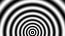
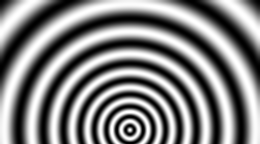
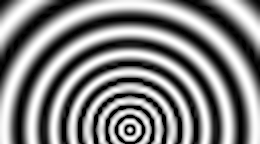


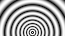
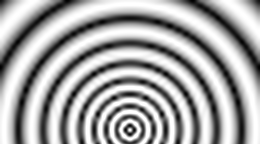
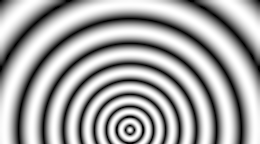


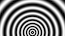
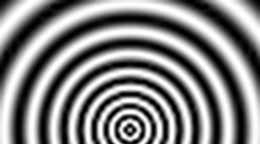
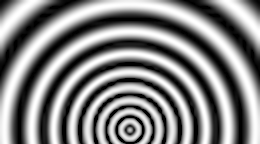

In [152]:
def experiment_visualize_gamma_upsample_image(**kwargs) -> None:
  def try_gamma_upsample(func, shape, frame_center, supersample=1, source_pow=1) -> None:
    supersample_shape = np.array(shape) * supersample
    supersampled = func(supersample_shape, frame_center, reference_shape=shape) ** source_pow
    # or: supersampled = resampler.PowerGamma(2).encode(supersampled, supersampled.dtype)
    image = resampler.resize(
        supersampled, shape, filter='lanczos10', src_gamma='power2', dst_gamma='power2'
    )
    new_shape = np.array(shape) * 4  # Or, "* 8".

    def resize_gamma(gamma: str) -> _NDArray:
      return resampler.resize(image, new_shape, filter='lanczos10', gamma=gamma)

    identity = resize_gamma('identity')
    power2 = resize_gamma('power2')
    images = {'original': image, "gamma='identity'": identity, "gamma='power2'": power2}
    images = {name: image[: image.shape[0] * 5 // 9] for name, image in images.items()}
    ylabel = f'{supersample=}<br/>{source_pow=}'
    media.show_images(images, vmin=0, vmax=1, border=True, width=new_shape[1], ylabel=ylabel)

  try_gamma_upsample(**kwargs)
  try_gamma_upsample(**kwargs, source_pow=0.5)
  try_gamma_upsample(**kwargs, supersample=32)
  # try_gamma_upsample(**kwargs, supersample=32, source_pow=0.5)


hh.no_vertical_scroll()
experiment_visualize_gamma_upsample_image(func=chirp, shape=(65, 65), frame_center=(0.5, 0.5))

In [153]:
def experiment_visualize_gamma_upsample_video(shape=(24, 48), source_pow=1) -> None:
  new_shape = np.array(shape) * 8
  yx = (np.moveaxis(np.indices(shape), 0, -1) + (0.5, 0.5)) / min(shape)
  original, identity, power2 = [], [], []
  for angle in np.linspace(0.0, math.tau, 60, endpoint=False):
    center = (0.75, 0.5) + np.array([np.cos(angle), np.sin(angle)]) * 0.05
    radius = np.linalg.norm(yx - center, axis=-1)
    image = (np.cos((radius + 0.1) ** 0.5 * 70.0) * 0.5 + 0.5) ** source_pow

    def resize_gamma(gamma: str) -> _NDArray:
      return resampler.resize(image, new_shape, filter='lanczos3', gamma=gamma)

    original.append(image)
    identity.append(resize_gamma('identity'))
    power2.append(resize_gamma('power2'))

  videos = {'original': original, 'identity': identity, 'power2': power2}
  ylabel = f'{source_pow=}'
  media.show_videos(videos, codec='gif', fps=10, height=shape[0] * 8, border=True, ylabel=ylabel)


if EFFORT >= 2:
  experiment_visualize_gamma_upsample_video()
  experiment_visualize_gamma_upsample_video(source_pow=0.5)

Conclusions:

Nehab and Hoppe [2014] suggest that for upsampling,
the best approach is to upsample directly in the lightness space of the source image,
rather than converting to linear space (e.g., by squaring the signal) and performing upscaling there.

These experiments confirm this.

The problem is that the example source image (sampled from chirp in lightness space) is
bandlimited in lightness space (where it is stored),
but is not bandlimited when converted to linear space (where it is operated on, e.g., with `gamma='power2'`)
due to the nonlinear squaring operation.
This aliased reconstruction can be prevented in one of two ways:
1. Define a different analytic function that is in fact bandlimited in linear
  space.  A trivial way is to sample a chirp function in linear space and convert it to lightness space.
  However this looks perceptually poor because the bright concentric rings overwhelm the dark ones.
3. Prefilter the linear-space function such that it is bandlimited.  A simple
  approach is to supersample the function in linear space, then convert the supersampled values into lightness space.
  As seen in the image results, the coarse image looks similar to the original with respect to
 the uniformity of the concentric bands (though it is subtly different),
 and its upsampling now has fewer aliasing artifacts.

## Higher diagonal frequencies

On a regular Cartesian 2D grid, the representable frequencies are given
by a square region in the frequency domain.
Therefore, the 45$^\circ$ diagonal is able to represent higher frequencies
(by a factor of $\sqrt{2}$) than the two axial directions.
As an experiment, we supersample axis-aligned rasterized text on grids
that are rotated by various angles (from $0^\circ$ to $90^\circ$)
and measure the reconstruction accuracy.


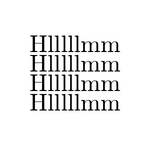
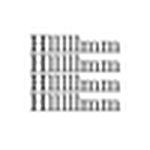
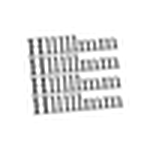
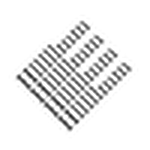
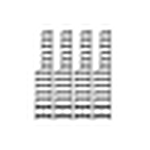

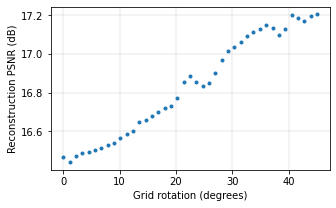

In [154]:
def get_text_image(shape=(200,) * 2) -> _NDArray:
  image = np.full((*shape, 3), 255, np.uint8)
  yx = shape[0] // 2, shape[1] // 2
  text = 'Hlllllmm\n' * 4
  hh.overlay_text(image, yx, text, fontname='cmr10', fontsize=48, align='mc', spacing=5, margin=0)
  return image[..., 0]  # Convert to grayscale.


def experiment_rotated_grid_has_higher_fidelity_for_text(num_rotations=41) -> None:
  original = crop_array(get_text_image() / 255.0, -50, 1.0)

  def generate_image_pair(degree) -> tuple[_NDArray, _NDArray]:
    reference = resampler.rotate_image_about_center(original, np.deg2rad(degree), boundary='clamp')
    reference = resampler.resize(reference, np.array(original.shape[:2]) // 2)
    downsampled = resampler.resize(reference, np.array(reference.shape[:2]) // 3)
    reconstructed = resampler.resize(downsampled, reference.shape[:2])
    return reference, reconstructed

  images = {'original': original}
  for degree in [0, 5, 45, 90]:
    reference, reconstructed = generate_image_pair(degree)
    psnr = get_psnr(reconstructed, reference)
    images[f'{degree=}  {psnr=:.2f}'] = reconstructed
  media.show_images(images, vmin=0, vmax=1, border=True, height=reconstructed.shape[0])

  degrees = np.linspace(0.0, 45.0, num_rotations)
  psnrs = [get_psnr(*generate_image_pair(degree)) for degree in degrees]
  _, ax = plt.subplots(figsize=(5, 3))
  ax.plot(degrees, psnrs, '.')
  ax.set(xlabel='Grid rotation (degrees)', ylabel='Reconstruction PSNR (dB)')
  ax.grid(True, lw=0.3)
  if 1:
    assert 0.98 < (corr := np.corrcoef(degrees, psnrs)[0, 1]) < 0.99, corr


if EFFORT >= 1:
  experiment_rotated_grid_has_higher_fidelity_for_text()

The conclusion is that, indeed, a regular grid is able to
reconstruct higher frequencies along the 45-degree diagonal direction.
For axis-aligned text, there is a small blip at the zero-degree direction,
likely due to avoiding the initial rotational resampling.

## Prefiltering of a discontinuity

Let us examine the effect of different prefiltering filters on the downsampling
of a step function.

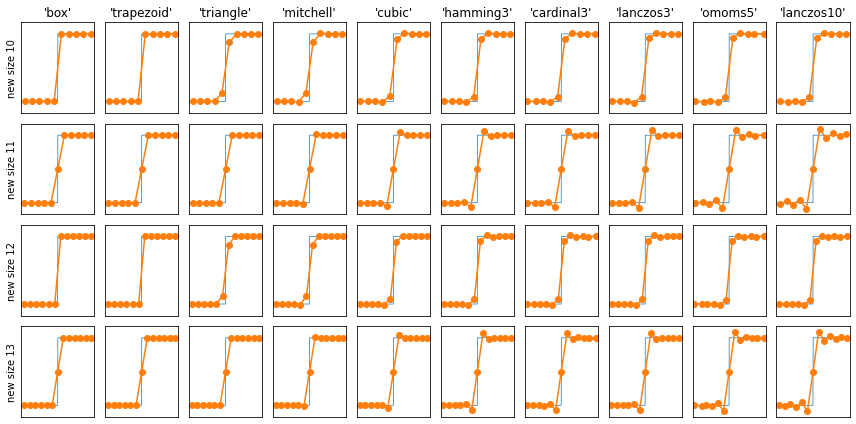

In [155]:
def visualize_prefiltering_a_discontinuity_in_1D(size=400, x_step=0.5) -> None:
  x = (np.arange(size) + 0.5) / size
  array = np.where(x < x_step, 0.0, 1.0)
  new_sizes = [10, 11, 12, 13]  # range(10, 21)
  filters = (
      'box trapezoid triangle mitchell cubic hamming3 cardinal3 lanczos3 omoms5 lanczos10'
  ).split()
  fig, ax_init = plt.subplots(len(new_sizes), len(filters), figsize=(12, 6))
  axs = typing.cast(np.ndarray[Any, Any], ax_init)
  for row_index, new_size in enumerate(new_sizes):
    for col_index, filter in enumerate(filters):

      def downsample(a: _NDArray) -> _NDArray:
        return resampler.resize(a, (new_size,), filter=filter)

      ax = axs[row_index][col_index]
      ax.plot(x, array, '-', linewidth=0.7)
      ax.plot(downsample(x), downsample(array), 'o-')
      ax.set(xlim=(0.0, 1.0), ylim=(-0.17, 1.17))
      ax.set(ylabel=f'new size {new_size}' if col_index == 0 else None)
      ax.set(title=f"'{filter}'" if row_index == 0 else None)
      _ = ax.xaxis.set_ticks([]), ax.yaxis.set_ticks([])

  fig.tight_layout()

  if 1:
    maxs = [resampler.resize(array, (11,), filter=filter).max() for filter in filters]
    expected = [1.000, 1.000, 1.000, 1.014, 1.042, 1.064, 1.067, 1.073, 1.081, 1.088]
    assert np.allclose(maxs, expected, atol=0.0005), maxs


visualize_prefiltering_a_discontinuity_in_1D()

Conclusions:
- Ringing is most evident with `'lanczos10'`.
- There is slight ringing with `'lanczos3'` although it is localized.
- The `'hamming3'` filter behaves much like `'lanczos3'`.

We now consider the same situation in 2D using a sharply defined circle:


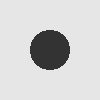

In [156]:
def visualize_prefiltering_a_discontinuity_in_2D(
    shape=(100, 100), radius=0.2, new_shape=(20, 20)
) -> None:
  mapped_radius = np.linalg.norm((np.indices(shape).T + 0.5) / np.array(shape) - 0.5, axis=-1).T
  outside_circle = mapped_radius >= radius
  array = np.where(outside_circle, 0.9, 0.2)
  filters = (
      'box trapezoid triangle mitchell cubic hamming3 cardinal3 lanczos3 omoms5 lanczos10'
  ).split()
  images = {'original': array}
  for filter in filters:
    images[f"'{filter}'"] = resampler.resize(array, new_shape, filter=filter)
  media.show_images(images, vmin=0, vmax=1, height=shape[0] * 1.25, border=True, columns=6)

  if 1:
    maxs = [image.max() for image in images.values()]
    expected = [0.90, 0.90, 0.90, 0.90, 0.91, 0.92, 0.93, 0.93, 0.94, 0.94, 0.95]
    assert np.allclose(maxs, expected, atol=0.005), maxs


visualize_prefiltering_a_discontinuity_in_2D()

Conclusions:
- Again, ringing artifacts are most evident with `'lanczos10'`.
- The ringing is much reduced in `'lanczos3'`, which is again nearly identical to `'hamming3'`.
- Ringing is avoided altogether in `'mitchell'` (and of course `'box'` and `'trapezoid'`).

We saw in 1D that ringing artifacts are scale-dependent.
Here we generate videos to show the effect of continuously changing the scale:

In [157]:
def visualize_prefiltering_as_scale_is_varied(
    shape=(100, 100), radius=0.2, new_shape=(20, 20)
) -> None:
  mapped_radius = np.linalg.norm((np.indices(shape).T + 0.5) / np.array(shape) - 0.5, axis=-1).T
  outside_circle = mapped_radius >= radius
  array = np.where(outside_circle, 0.9, 0.2)
  filters = 'box trapezoid mitchell cubic cardinal3 lanczos3 omoms5 lanczos10'.split()
  videos = collections.defaultdict(list)
  for filter in filters:
    for scale in np.linspace(0.9, 1.1, 61):
      video = resampler.resize(array, new_shape, scale=scale, filter=filter)[3:-3, 3:-3]
      videos[f"'{filter}'"].append(video)
  media.show_videos(videos, qp=14, fps=20, height=shape[0] * 1.5, border=True, columns=4)


if EFFORT >= 1:
  visualize_prefiltering_as_scale_is_varied()

Conclusions:
- There is definite *temporal shimmering* for `'lanczos10'`,
  particularly in the circle interior.
- Although the `'cubic'` and `'lanczos3'` results show halos (both a black ring inside and a white ring outside),
  there is little shimmering.
- The `'trapezoid'` result has no halos (as expected) but is blurry.

## Prefilter convolution

In [158]:
def _torch_symmetric_pad(array: _ArrayLike, padding: Iterable[int]) -> _TorchTensor:
  """Use reflection to pad each dimension."""
  # See https://github.com/pytorch/pytorch/issues/46240 and
  # https://discuss.pytorch.org/t/symmetric-padding/19866/3.
  a = torch.as_tensor(array)
  del array
  padding = tuple(padding)
  if len(padding) != a.ndim:
    raise ValueError(f'Padding {padding} does not match ndim of {a.shape}.')
  if any(pad < 0 for pad in padding):
    raise ValueError(f'Padding {padding} has negative values.')

  dim_indices: list[_NDArray] = []
  for dim in range(a.ndim):
    pad = padding[dim]
    if pad == 0 and not dim_indices:
      # The prefix of unmodified dimensions is accounted for by an Ellipsis.
      continue
    width = a.shape[dim]
    index = np.arange(-pad, width + pad)
    if pad > 0:
      index = np.mod(index, width * 2)
      index = np.where(index < width, index, 2 * width - 1 - index)
    dim_indices.append(index)

  grid_indices = np.meshgrid(*dim_indices, indexing='ij')
  return a[(..., *grid_indices)]

In [159]:
def experiment_with_convolution() -> None:
  # https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html

  def scipy_convolve(array, filter, reflect=False) -> _NDArray:
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    if reflect:
      pad = tuple(np.array(filter.shape) // 2)
      array = np.pad(array, tuple(zip(pad, pad)), 'symmetric')
    mode = 'valid' if reflect else 'same'
    return scipy.signal.convolve(array, filter, mode=mode)

  def scipy_oaconvolve(array, filter, reflect=False) -> _NDArray:
    # Faster than fftconvolve when one array is much larger than the other.
    # https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    if reflect:
      pad = tuple(np.array(filter.shape) // 2)
      array = np.pad(array, tuple(zip(pad, pad)), 'symmetric')
    mode = 'valid' if reflect else 'same'
    return scipy.signal.oaconvolve(array, filter, mode=mode, axes=range(filter.ndim))

  def scipy_sepfir2d(array, filter1d) -> _NDArray:
    if array.ndim > 2:
      a = [scipy_sepfir2d(array[..., i], filter1d) for i in range(array.shape[-1])]
      return np.stack(a, axis=-1)
    return scipy.signal.sepfir2d(array, filter1d, filter1d)

  def numpy_fftconvolve(array, filter) -> _NDArray:
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    a = np.fft.rfftn(array) * np.fft.rfftn(filter, s=array.shape, axes=range(array.ndim))
    result = np.fft.irfftn(a, s=array.shape, axes=range(array.ndim))  # (Always np.float64.)
    result = np.roll(result, -(np.array(filter.shape) // 2), axis=range(array.ndim))
    return result

  def ndimage_convolve(array, filter) -> _NDArray:
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    return scipy.ndimage.convolve(array, filter, mode='reflect')

  def tensorflow_convolve(array, filter, reflect=False) -> _NDArray:
    """Convolve the array [*dims, *sample_shape] with the filter [*dims]."""
    array = tf.convert_to_tensor(array)
    filter = tf.convert_to_tensor(filter)
    conv_ndim = filter.ndim
    assert conv_ndim in (1, 2, 3)
    assert array.ndim >= conv_ndim
    if reflect:
      pad = (*(np.array(filter.shape) // 2), *(0,) * (array.ndim - conv_ndim))
      array = tf.pad(array, tuple(zip(pad, pad)), mode='SYMMETRIC')
    filter = filter[..., None, None]  # WCO, HWCO, or THWCO.
    padding = 'VALID' if reflect else 'SAME'

    def recurse(array) -> tf.Tensor:
      if array.ndim > conv_ndim:
        return tf.stack([recurse(array[..., i]) for i in range(array.shape[-1])], axis=-1)
      array = array[None, ..., None]  # BWC, BHWC, or BTHWC.
      return tf.nn.conv2d(array, filter, strides=1, padding=padding)[0, ..., 0]

    # Note: separable_conv2d() might be simpler but is much slower on CPU.
    return recurse(array).numpy()

  def torch_convolve(array, filter, reflect=False) -> _NDArray:
    """Convolve the array [*dims, *sample_shape] with the filter [*dims]."""
    array = torch.as_tensor(array)
    filter = torch.as_tensor(filter)
    conv_ndim = filter.ndim
    assert conv_ndim in (1, 2, 3)
    assert array.ndim >= conv_ndim
    sample_shape = array.shape[conv_ndim:]
    padding: Any = tuple(np.array(filter.shape) // 2)
    array = array.view(1, *array.shape[:conv_ndim], -1)  # BWC, BHWC, or BTHWC.
    array = array.moveaxis(-1, 1)  # BCW, BCHW , or BCTHW.
    while filter.ndim < array.ndim:
      filter = filter[None]
    filter = filter.expand((array.shape[1], 1, *filter.shape[2:]))  # OCW, OCHW, or OCTHW.
    if reflect:
      array = _torch_symmetric_pad(array, (0, 0, *padding))
      padding = 0
    conv = {
        1: torch.nn.functional.conv1d,
        2: torch.nn.functional.conv2d,
        3: torch.nn.functional.conv3d,
    }[conv_ndim]
    result = conv(array, filter, padding=padding, groups=array.shape[1])
    result = result[0]  # CW, CHW, or CTHW.
    result = result.moveaxis(0, -1)  # WC, HWC, or THWC.
    result = result.view(*result.shape[:conv_ndim], *sample_shape)
    return result.numpy()

  # shape = 17, 17
  shape = 17, 17, 3
  array = np.zeros(shape, np.float32)
  array[tuple(np.array(shape[:2]) // 2)] = 1.0
  array[2, 0] = 1.0
  filter1d = resampler.resize(
      [0.0, 0.0, 1.0, 0.0, 0.0], (11,), gridtype='primal', filter='cubic', dtype=np.float32
  )
  filter1d = filter1d / np.sum(filter1d)
  filter = np.outer(filter1d, filter1d)
  functions: dict[str, Callable[[], _NDArray]] = {
      'scipy_convolve': lambda: scipy_convolve(array, filter),  # zero-padding
      'scipy_convolve_r': lambda: scipy_convolve(array, filter, reflect=True),
      'scipy.oaconvolve': lambda: scipy_oaconvolve(array, filter),  # zero-padding
      'scipy_oaconvolve_r': lambda: scipy_oaconvolve(array, filter, reflect=True),
      'scipy.sepfir2d': lambda: scipy_sepfir2d(array, filter1d),  # reflect
      'numpy_fftconvolve': lambda: numpy_fftconvolve(array, filter),  # periodic
      'ndimage.convolve': lambda: ndimage_convolve(array, filter),  # selectable
      'tf_convolve': lambda: tensorflow_convolve(array, filter),  # zero-padding
      'tf_convolve_r': lambda: tensorflow_convolve(array, filter, reflect=True),
      # 'torch_convolve': lambda: torch_convolve(array, filter),  # zero-padding
      'torch_convolve_r': lambda: torch_convolve(array, filter, reflect=True),
  }
  if 1:
    visualization = {}
    for name, function in functions.items():
      result = function()
      if name != 'numpy_fftconvolve':  # It always computes np.float64.
        _check_eq(result.dtype, array.dtype)
      sum_ = result.sum() / array.sum()
      # print(f'{name:22} {result.shape!s:14} {sum_:.4f}')
      assert 0.85 <= sum_ <= 1.001, name
      visualization[f'{name}<br/>sum={sum_:5.3f}'] = 1 - (array + result)
    media.show_images(visualization, height=120, border=True, columns=6)

  if 1:
    shape = 500, 500, 3
    print(f'For {shape=}:')
    array = np.zeros(shape, np.float32)
    for name, function in functions.items():
      elapsed = hh.get_time(function, max_time=0.2)
      print(f'{name:25}: {elapsed:.3f} s')

  if EFFORT >= 2:  # For 10x downsampling, convolution on source grid is 10x slower.
    array = np.ones((1000, 2000, 3), np.float32)
    filter = np.ones((61, 61), np.float32)
    # (resize to (100, 200) lanczos3 39 ms)
    # (resample to (100, 200) lanczos3 30 ms but aliased)
    hh.print_time(lambda: scipy_convolve(array, filter, reflect=False))  # 309 ms
    hh.print_time(lambda: scipy_convolve(array, filter, reflect=True))  # 325 ms

  if EFFORT >= 2:  # Convolution on source grid is 8-12x slower than resampler.resize().
    array = np.ones((2000, 2000, 3), np.float32)
    for downsample in [1, 2, 3, 4, 8]:
      filter = np.ones((2 * 3 * downsample + 1,) * 2, np.float32)
      print(array.shape, filter.shape)
      # hh.print_time(lambda: scipy_convolve(array, filter, reflect=False))
      hh.print_time(lambda: scipy_convolve(array, filter, reflect=True))
      hh.print_time(lambda: resampler.resize(array, np.array(array.shape[:2]) // downsample))


if EFFORT >= 1:
  experiment_with_convolution()

For shape=(500, 500, 3):
scipy_convolve           : 0.006 s
scipy_convolve_r         : 0.007 s
scipy.oaconvolve         : 0.009 s
scipy_oaconvolve_r       : 0.010 s
scipy.sepfir2d           : 0.006 s
numpy_fftconvolve        : 0.020 s
ndimage.convolve         : 0.041 s
tf_convolve              : 0.016 s
tf_convolve_r            : 0.019 s
torch_convolve_r         : 0.003 s


Conclusions:
- `scipy.ndimage.convolve`: nice flexible boundary conditions, but slower.
- `sepfir2d`: fast and supports `'reflect'` boundaries,
  but only operates in 2D and using the same filter for both axes.
- `tf.nn.separable_conv2d` is horribly slow on the CPU.
- `torch.nn.functional.conv2d` with padding is slow; instead we implement it ourselves.
- `scipy.convolve` and `torch.conv2d` are both fast!
- However, all these convolutions are ~10x slower than the "strided convolution" in the
  `resampler.resize()` operation.
  It does seem wasteful to be computing the convolution on all source pixels
  when the smaller output will just subsample the result.

## Generalized sampling

In [160]:
def test_banded(debug=False) -> None:
  # [On band circulant matrices in the periodic spline interpolation theory]:
  # https://www.sciencedirect.com/science/article/pii/0024379585901533
  array = np.array([3.0, 4.0, 1.0, 2.0, 7.0, 6.0])
  if 0:
    array = np.random.default_rng(0).integers(1, 10, 100).astype(np.float64)
  size = len(array)
  if 0:
    array = np.broadcast_to(array[..., None], array.shape + (2,))
  filter = resampler.BsplineFilter(degree=5)  # 3 or 5
  boundary = 'reflect'
  boundary = 'wrap'
  # We use the notation (l, ab) from scipy.linalg.solve_banded().  l == u.
  l = math.ceil(filter.radius) - 1
  x = np.arange(-l, l + 1)
  values = filter(x)
  if debug:
    print(x, values)  # degree3: [1, 4, 1]/6; degree5: [1, 26, 66, 26, 1]/120
  UNDEFINED = math.nan

  if 1 and l == 1 and boundary == 'reflect':
    ab = np.empty((2 * l + 1, size))
    ab[:] = values[:, None]
    ab[1, 0] = ab[1, 0] + ab[0, 0]
    ab[0, 0] = UNDEFINED
    ab[1, -1] = ab[1, -1] + ab[-1, -1]
    ab[-1, -1] = UNDEFINED
    new = scipy.linalg.solve_banded((l, l), ab, array, check_finite=False)
    print('solve_banded', new)
    offsets = range(l, -l - 1, -1)
    matrix = scipy.sparse.dia_matrix((ab, offsets), shape=(size, size))
    if debug:
      print(matrix.toarray(), matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1:
    src_index = np.arange(size)[:, None] + np.arange(len(values)) - l
    weight = np.broadcast_to(values[None], (size, len(values)))
    src_position = np.broadcast_to(0.5, len(values))
    src_gridtype = resampler._get_gridtype('dual')
    src_index, weight = resampler._get_boundary(boundary).apply(
        src_index, weight, src_position, size, src_gridtype
    )
    data = weight.reshape(-1)
    row_ind = np.arange(size).repeat(src_index.shape[1])
    col_ind = src_index.reshape(-1)
    matrix = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(size, size))
    assert scipy.sparse.linalg.norm(matrix - matrix.T, np.inf) < 1e-10
    if boundary == 'wrap':
      # Transpose of (symmetric) csr_matrix because splu() desires csc_matrix.
      lu = scipy.sparse.linalg.splu(matrix.transpose(), permc_spec='NATURAL')
      _check_eq(lu.perm_c, range(size))
      _check_eq(lu.perm_r, range(size))
      assert lu.L.nnz == lu.U.nnz <= size * len(values)  # Sparse.
      new = lu.solve(array)
    else:
      matrix = matrix.todia()
      _check_eq(matrix.offsets, range(-l, l + 1))
      new = scipy.linalg.solveh_banded(matrix.data[-1 : l - 1 : -1], array, check_finite=False)
    if debug:
      print('boundary', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    ab = np.empty((l + 1, size))
    ab[:] = values[: l + 1, None]
    ab[1, 0] = ab[1, 0] + ab[0, 0]
    ab[0, 0] = UNDEFINED
    ab[1, -1] = ab[1, -1] + ab[0, -1]
    new = scipy.linalg.solveh_banded(ab, array, check_finite=False)
    if debug:
      print('solveh_banded', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
    assert lu.L.nnz <= size * 2 and lu.U.nnz <= size * 2  # Nicely sparse.
    _check_eq(lu.perm_c, range(size))
    _check_eq(lu.perm_r, range(size))
    # print(lu.shape, lu.L.nnz, lu.U.nnz)
    # print(lu.perm_c, lu.perm_r, lu.L, lu.U)
    new = lu.solve(array)
    if debug:
      print('lu', new)

  if 1 and l in [1, 2]:
    # causal/anticausal filters:
    # https://github.com/scipy/scipy/blob/main/scipy/ndimage/src/ni_interpolation.c#L145
    # https://github.com/scipy/scipy/blob/main/scipy/ndimage/src/ni_splines.c
    # Drawbacks: not as precise; only Bspline (no OMOMS); limited boundaries.
    mode = {'reflect': 'reflect', 'wrap': 'grid-wrap'}[boundary]
    new = scipy.ndimage.spline_filter1d(
        array, order=l * 2 + 1, axis=0, mode=mode, output=array.dtype
    )
    if debug:
      print('ndimage', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    # It applies lfilter() twice (once on reversed array).
    # It always produces np.float64, except with method='gust'.
    # https://www.dsprelated.com/showthread/comp.dsp/368362-2.php
    # a = [1 2-sqrt(3)]; b = sum(a);
    # c = filtfilt(f,b,a);
    a = np.array([1.0, 2.0 - 3**0.5])
    b = a.sum()
    new = scipy.signal.filtfilt(b, a, array, axis=0, method='gust')
    if debug:
      print('filtfilt', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    # tensorflow does not support general banded solver.
    # tf.linalg.banded_triangular_solve(): only upper or only lower diagonals.
    # tf.linalg.tridiagonal_solve(): 1 lower diagonal and 1 upper diagonal.
    # Possibly the matrix can be factored into a sequence of the above.
    # tf.linalg.LinearOperatorCirculant().inverse() uses FFT (dense).
    # For TF2: https://stackoverflow.com/a/63583413
    # For splu using TF1: https://stackoverflow.com/a/46913675
    # For tf.keras: https://stackoverflow.com/a/62921079
    # Limitation of tf.py_function: the resulting model cannot be serialized!

    ab = np.empty((2 * l + 1, size))
    ab[:] = values[:, None]
    ab[1, 0] = ab[1, 0] + values[0]
    ab[0, -1] = UNDEFINED
    ab[1, -1] = ab[1, -1] + values[2]
    ab[-1, 0] = UNDEFINED
    ab = tf.convert_to_tensor(ab)
    array = tf.convert_to_tensor(array)
    new = tf.linalg.tridiagonal_solve(ab, array, partial_pivoting=False)
    if debug:
      print('tf.tridiagonal', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 0:
    # torch.linalg lacks solvers for banded, circulant, or sparse matrices.
    pass

  # wrap boundary:
  # scipy lacks efficient solvers for "circulant banded linear systems".
  # scipy.solve_banded() does not support the circulant corners.
  # scipy.solve_circulant() assumes a dense matrix and uses FFT.
  # solution: scipy.sparse LU factorization does remain sparse.


if 1:
  test_banded()

In [161]:
def test_inverse_convolution_2d(
    gridscale=2.0, degree=3, gridtype='dual', boundary='reflect', dtype=np.float32
) -> None:
  filter = resampler.BsplineFilter(degree=degree)
  l = math.ceil(filter.radius) - 1
  x = np.arange(-l, l + 1)
  values = filter(x)
  UNDEFINED = 1e20
  mode = {
      ('dual', 'reflect'): 'reflect',
      ('dual', 'wrap'): 'grid-wrap',
      ('dual', 'clamp'): 'nearest',
      ('primal', 'reflect'): 'mirror',
      ('primal', 'clamp'): 'nearest',
  }[gridtype, boundary]

  def run_spline_filter1d(array: _NDArray) -> _NDArray:
    array = array.copy()
    for dim in range(2):
      scipy.ndimage.spline_filter1d(array, order=degree, axis=dim, mode=mode, output=array)
    return array

  def run_general(array: _NDArray) -> _NDArray:
    for dim in range(2):
      array_dim = np.moveaxis(array, dim, 0)
      size = array_dim.shape[0]
      src_index = np.arange(size)[:, None] + np.arange(len(values)) - l
      weight = np.full((size, len(values)), values, array.dtype)
      src_position = np.broadcast_to(0.5, len(values))
      src_gridtype = resampler._get_gridtype(gridtype)
      src_index, weight = resampler._get_boundary(boundary).apply(
          src_index, weight, src_position, size, src_gridtype
      )
      if gridtype == 'primal' and boundary == 'wrap':
        # Overwrite redundant last row to preserve unreferenced last sample.
        src_index[-1] = [size - 1] + [0] * (src_index.shape[1] - 1)
        weight[-1] = [1.0] + [0.0] * (weight.shape[1] - 1)
      data = weight.reshape(-1)
      row_ind = np.arange(size).repeat(src_index.shape[1])
      col_ind = src_index.reshape(-1)
      matrix = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(size, size))
      if boundary == 'wrap':
        lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
        assert lu.L.nnz == lu.U.nnz <= size * len(values)  # Sparse.
        array_flat = array_dim.reshape(array_dim.shape[0], -1)
        array_flat = lu.solve(array_flat)
        array_dim = array_flat.reshape(array_dim.shape)
      else:
        matrix = matrix.todia()
        _check_eq(matrix.offsets, range(-l, l + 1))
        options = dict(check_finite=False, overwrite_ab=True, overwrite_b=True)
        if resampler._is_symmetric(matrix):
          array_dim = scipy.linalg.solveh_banded(matrix.data[-1 : l - 1 : -1], array_dim, **options)
        else:
          array_dim = scipy.linalg.solve_banded((l, l), matrix.data[::-1], array_dim, **options)
      array = np.moveaxis(array_dim, 0, dim)
    return array

  def run_solveh_banded(array: _NDArray) -> _NDArray:
    for dim in range(2):
      array_dim = np.moveaxis(array, dim, 0)
      size = array_dim.shape[0]
      ab = np.empty((l + 1, size), array.dtype)
      ab[:] = values[: l + 1, None]
      ab[1, 0] = ab[1, 0] + ab[0, 0]
      ab[0, 0] = UNDEFINED
      ab[1, -1] = ab[1, -1] + ab[0, -1]
      array_dim = scipy.linalg.solveh_banded(
          ab, array_dim, check_finite=False, overwrite_ab=True, overwrite_b=True
      )
      array = np.moveaxis(array_dim, 0, dim)
    return array

  def run_splu(array: _NDArray) -> _NDArray:
    for dim in range(2):
      array_dim = np.moveaxis(array, dim, 0)
      size = array_dim.shape[0]
      ab = np.empty((2 * l + 1, size), array.dtype)
      ab[:] = values[:, None]
      ab[1, 0] = ab[1, 0] + ab[0, 0]
      ab[0, 0] = UNDEFINED
      ab[1, -1] = ab[1, -1] + ab[-1, -1]
      ab[-1, -1] = UNDEFINED
      offsets = range(l, -l - 1, -1)
      matrix = scipy.sparse.dia_matrix((ab, offsets), shape=(size, size))
      lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
      array_flat = array_dim.reshape(array_dim.shape[0], -1)
      array_flat = lu.solve(array_flat)
      array_dim = array_flat.reshape(array_dim.shape)
      array = np.moveaxis(array_dim, 0, dim)
    return array

  def run_filtfilt(array: _NDArray) -> _NDArray:
    # _filtfilt_gust() in https://github.com/scipy/scipy/blob/main/scipy/signal/_signaltools.py
    # would likely support complex values but it defines temporaries using untyped np.zeros().
    assert not np.issubdtype(array.dtype, np.complexfloating)
    for dim in range(2):
      a = np.array([1.0, 2.0 - 3**0.5], array.dtype)
      b = a.sum()
      with np.errstate(under='ignore'):
        array = scipy.signal.filtfilt(b, a, array, axis=dim, method='gust')
    return array

  # (480, 640, 3)
  array = media.to_float01(EXAMPLE_PHOTO).astype(dtype, copy=False)
  if np.issubdtype(dtype, np.complexfloating):
    array = array + 0.5j * (array + 0.2)
  functions: dict[str, Callable[[_NDArray], _NDArray]] = {
      'general': run_general,
      'spline_filter1d': run_spline_filter1d,
  }
  if gridtype == 'dual' and boundary == 'reflect' and degree == 3:
    new_shape = (np.array(array.shape[:2]) * gridscale + 0.5).astype(int)
    hh.print_time(lambda: resampler.resize(array, new_shape, filter='cubic'))  # 20 ms
    hh.print_time(lambda: resampler.resize(array, new_shape, filter='lanczos5'))  # 35 ms
    functions = {
        **functions,
        'solveh_banded': run_solveh_banded,
        'splu': run_splu,
        'filtfilt': run_filtfilt,
    }
  with warnings.catch_warnings():
    warnings.filterwarnings(action='error', category=np.exceptions.ComplexWarning)
    for name, function in functions.items():
      if np.issubdtype(dtype, np.complexfloating) and name in ['filtfilt']:
        continue
      elapsed, new = hh.get_time_and_result(lambda: function(array), max_repeat=5)
      _check_eq(new.dtype, dtype)
      filter2d = np.outer(values, values)[..., None]
      convolved = np.empty_like(new)
      convolved.real = scipy.ndimage.convolve(new.real, filter2d, mode=mode)
      if np.issubdtype(dtype, np.complexfloating):
        convolved.imag = scipy.ndimage.convolve(new.imag, filter2d, mode=mode)
      max_error = abs(convolved - array).max()
      print(f'{name:16}: {elapsed:5.3f} s  (max_error:{max_error:9.2e})')
      assert max_error <= 1e-6


if EFFORT >= 1:
  test_inverse_convolution_2d()
# 8.02 ms
# 11.8 ms
# general         : 0.011 s  (max_error: 2.98e-07)
# spline_filter1d : 0.009 s  (max_error: 1.19e-07)
# solveh_banded   : 0.009 s  (max_error: 2.98e-07)
# splu            : 0.021 s  (max_error: 2.38e-07)
# filtfilt        : 0.074 s  (max_error: 5.96e-07)

if EFFORT >= 2:
  test_inverse_convolution_2d(dtype=np.complex128)
  test_inverse_convolution_2d(degree=5)
  test_inverse_convolution_2d(degree=5, gridtype='primal')
  test_inverse_convolution_2d(gridtype='dual', boundary='wrap')
  test_inverse_convolution_2d(boundary='clamp')
  test_inverse_convolution_2d(gridtype='primal', boundary='reflect')
  test_inverse_convolution_2d(gridtype='primal', boundary='clamp')
# 66.4 ms
# 81.6 ms
# general         : 0.026 s  (max_error: 5.55e-16)
# spline_filter1d : 0.024 s  (max_error: 7.02e-16)
# solveh_banded   : 0.024 s  (max_error: 5.55e-16)
# splu            : 0.045 s  (max_error: 7.45e-16)
# general         : 0.032 s  (max_error: 2.38e-07)
# spline_filter1d : 0.015 s  (max_error: 1.19e-07)
# general         : 0.025 s  (max_error: 2.98e-07)
# spline_filter1d : 0.015 s  (max_error: 1.19e-07)
# general         : 0.033 s  (max_error: 2.98e-07)
# spline_filter1d : 0.012 s  (max_error: 1.19e-07)
# general         : 0.011 s  (max_error: 2.98e-07)
# spline_filter1d : 0.009 s  (max_error: 1.19e-07)
# general         : 0.015 s  (max_error: 2.38e-07)
# spline_filter1d : 0.009 s  (max_error: 1.19e-07)
# general         : 0.011 s  (max_error: 2.98e-07)
# spline_filter1d : 0.009 s  (max_error: 1.19e-07)

7.37 ms
8.79 ms
general         : 0.013 s  (max_error: 2.98e-07)
spline_filter1d : 0.011 s  (max_error: 1.19e-07)
solveh_banded   : 0.010 s  (max_error: 2.98e-07)
splu            : 0.020 s  (max_error: 2.38e-07)
filtfilt        : 0.088 s  (max_error: 5.96e-07)


Conclusions:
- Unfortunately, all these digital-filter implementations take
  about the same time as the direct `resampler.resize()` operation.
- E.g., for 2x upsampling, just running the `degree=3` digital filter takes
  as much time as resizing with a `radius=3` filter.
- The digital filter becomes worthwhile if the upscaling
  (or downscaling) factor is 4.0 or greater.
- `scipy.linalg.solveh_banded` gives the fastest time,
  but it does not support `boundary='wrap'`.
- I tried running on just `dim = 0` (to simulate applying the digital
  filter to `array_flat`) and the speedup is very small.

## Other

The 2D continuous `'gaussian'` kernel is the only separable filter
that is rotationally symmetric.
However, it is not rotationally symmetric when used in upsampling,
as seen below,
due to the weight re-normalization performed over the few nonzero entries
in the reconstruction window.
The discretized Gaussian filter becomes more rotationally symmetric when
used as a prefilter with a significant downsampling factor.
In either case (upsampling or downsampling), the Gaussian filter introduces
unnecessary blur and is not recommended.


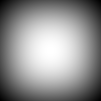

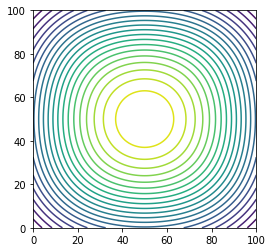

In [162]:
def visualize_rotational_symmetry_of_gaussian_filter(size1=11, size2=1001) -> None:
  gauss = resampler.GaussianFilter()
  # Because the continuous filter is rotationally symmetric, its value at a
  # distance 1.0 along a diagonal equals its value at a distance 1.0 along
  # an axis.
  assert np.allclose(gauss(2.0**-0.5) ** 2.0, gauss(1.0) * gauss(0.0))

  array = np.zeros((size1, size1))
  array[size1 // 2, size1 // 2] = 1
  image = resampler.resize(array, filter='gaussian', shape=(size2, size2))
  media.show_image(crop_array(image, int(size2 * 0.45)), border=True)
  _, ax = plt.subplots(figsize=(4, 4))
  ax.contour(crop_array(image, int(size2 * 0.45)), 20)
  # The upsampled signal does not have exact rotational symmetry.


visualize_rotational_symmetry_of_gaussian_filter()

# Creation of figure images
<a name="Creation-of-figure-images"></a>

In [163]:
# The usage example images are created in the notebook example_usage.ipynb.

In [164]:
# Remember to set Windows -> Display -> "Make everything bigger" to 100% to avoid dwm dpi scaling
# in screen captures.


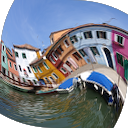

In [165]:
def visualize_resampled_spiral_with_alpha() -> None:
  image = media.read_image('https://github.com/hhoppe/data/raw/main/image.png')
  image = crop_array(image, ((0, 0, 0), (0, 0, -1)), 255)  # Add alpha channel with value 255.
  shape = image.shape[:2]
  yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
  resampled = resampler.resample(image, coords, boundary='constant')
  media.show_image(resampled)


visualize_resampled_spiral_with_alpha()

In [166]:
def visualize_resampled_spiral_large() -> None:
  image = EXAMPLE_IMAGE
  image = crop_array(image, ((0, 0, 0), (0, 0, -1)), 255)  # Add alpha channel with value 255.
  shape = image.shape[:2]
  shape = 1280, 1280
  yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 0.8 - 0.3
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
  resampled = resampler.resample(image, coords, boundary='constant')[320:-320]
  media.show_image(resampled)


if 0:
  visualize_resampled_spiral_large()
if 0:
  media.show_image(resampler.resize(EXAMPLE_IMAGE, (1280, 1280))[320:-320])


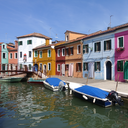
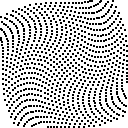
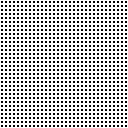
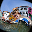

In [167]:
def visualize_warp_samples() -> None:
  image = EXAMPLE_IMAGE
  shape = 32, 32
  yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
  src_shape = 128, 128
  coords_image = np.full(src_shape, 1.0)
  for coord in coords.reshape(-1, 2):
    coord = (coord * src_shape + 0.5).astype(int)
    if np.all((coord >= 0) & (coord + 1 < src_shape)):
      coords_image[tuple(slice(coord[c], coord[c] + 2) for c in range(2))] = 0
  dst_image = resampler.resize(
      np.zeros(shape), src_shape, filter=resampler.NarrowBoxFilter(radius=0.15), cval=1
  )
  resampled = resampler.resample(image, coords, boundary='constant')
  images = {
      'source': image,
      'coords in source': coords_image,
      'destination grid': dst_image,
      'resampled': resampled,
  }
  media.show_images(images, height=128, border=True)


visualize_warp_samples()

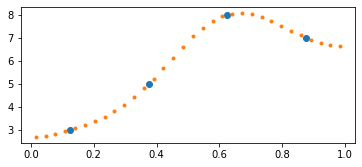

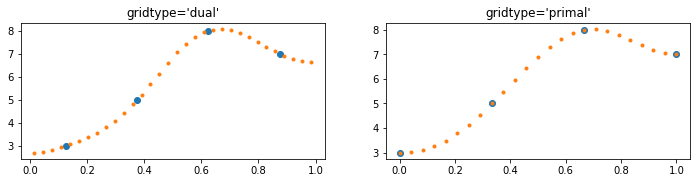

In [168]:
def visualize_unused() -> None:
  array = [3.0, 5.0, 8.0, 7.0]
  upsampled = resampler.resize(array, (32,))
  _, ax = plt.subplots(figsize=(6, 2.5))
  ax.plot((np.arange(len(array)) + 0.5) / len(array), array, 'o')
  ax.plot((np.arange(len(upsampled)) + 0.5) / len(upsampled), upsampled, '.')

  array = [3.0, 5.0, 8.0, 7.0]

  def upsample_1d(ax, gridtype, size, ordinates) -> None:
    upsampled = resampler.resize(array, (size,), gridtype=gridtype)
    ax.plot(ordinates(array), array, 'o')
    ax.plot(ordinates(upsampled), upsampled, '.')
    ax.set(title=f"gridtype='{gridtype}'")

  _, ax_init = plt.subplots(1, 2, figsize=(12, 2.5))
  axs = typing.cast(np.ndarray[Any, Any], ax_init)
  upsample_1d(axs[0], 'dual', 32, lambda x: (np.arange(len(x)) + 0.5) / len(x))
  upsample_1d(axs[1], 'primal', 25, lambda x: np.arange(len(x)) / (len(x) - 1))


visualize_unused()

Images for figures:


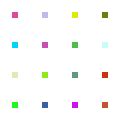
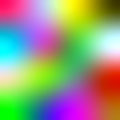
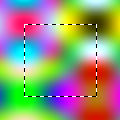
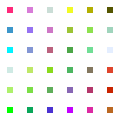

In [169]:
def visualize_reconstruction_and_sampling() -> None:
  array = np.random.default_rng(9).random((4, 4, 3))
  new = resampler.resize(array, (6, 6))
  images = {
      'samples': array,
      'sample_squares': resampler.resize(
          array,
          (120, 120),
          boundary='constant',
          cval=1.0,
          filter=resampler.NarrowBoxFilter(radius=0.099),
      ),
      'reconstruction': resampler.resize(
          array, (120, 120), boundary='constant', cval=1.0, filter='lanczos3'
      ),
      'wide_reconstruction': resize_showing_domain_boundary(array, (120, 120)),
      'new_samples': resampler.resize(
          new,
          (120, 120),
          boundary='constant',
          cval=1.0,
          filter=resampler.NarrowBoxFilter(radius=0.128),
      ),
  }
  media.show_images(images, border=False, height=120)


visualize_reconstruction_and_sampling()
# (These are different from the images originally placed in Google Drawings.)

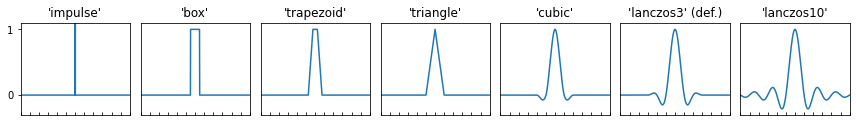

In [170]:
def visualize_example_filters(filters: Sequence[str], num=1_001) -> None:
  fig, ax_init = plt.subplots(1, len(filters), figsize=(12, 1.8))
  axs = typing.cast(np.ndarray[Any, Any], ax_init)

  for index, filter_name in enumerate(filters):
    ax = axs.flat[index]
    filter = resampler._get_filter(filter_name)
    if filter.name == 'trapezoid':
      filter = resampler.TrapezoidFilter(radius=0.75)  # Some representative shape.

    x = resampler.resize(np.arange(-10.0, 11.0), (num,), gridtype='primal', filter='triangle')
    y = resampler.resize([0.0] * 10 + [1.0] + [0.0] * 10, (num,), gridtype='primal', filter=filter)
    if filter.name == 'impulse':
      y = (np.arange(num) == num // 2) * 100.0

    ax.plot(x, y)
    title = f"'{filter_name}'"
    title = title + ' (def.)' if filter_name == resampler._DEFAULT_FILTER else title
    ax.set(title=title, xlim=(-6.0, 6.0), ylim=(-0.30, 1.1))
    ax.yaxis.set_ticks([0.0, 1.0] if index == 0 else [])
    ax.xaxis.set_ticks(np.arange(-6, 7, 1))
    ax.tick_params(axis='x', labelbottom=False, direction='in')

  fig.tight_layout()


visualize_example_filters('impulse box trapezoid triangle cubic lanczos3 lanczos10'.split())
# The filter 'cardinal3' (not shown here) looks almost identical to 'lanczos3'.

# Comparisons with other libraries

In [171]:
# Useful references:
# https://stackoverflow.com/questions/48097941/strided-convolution-of-2d-in-numpy
# https://docs.scipy.org/doc/scipy/reference/sparse.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [172]:
# Other image resampling libraries, with their parameter names and values:

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html
#  boundary='fill'  # or 'wrap', 'symm'.
#  fillvalue=0  # used for 'fill'.
#  Only convolution; not strided; therefore no resizing.

# https://numpy.org/doc/stable/reference/generated/numpy.pad.html
#  mode='constant'  # or 'edge', 'linear_ramp', 'maximum', 'mean', 'median',
#                   #   'minimum', 'reflect', 'symmetric', 'warp', 'empty'.
#  reflect_type='even'  # or 'odd'; for 'reflect' and 'symmetric'.

<font size="+1">**Comparison table for `resize` operation:**</font>

| Library | `ndim` | Array type | Data type | Grid type | Upsample | Antialiased downsample | Boundary rule | Speed | Native code | Grad &nabla; |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| `resampler.resize` | any | `np`, `tf`, `torch`, `jax` | any | dual, primal | any filter | any filter | many | average | <font size="-2">`scipy.sparse`<br/>or `numba`</font> | yes |
| `PIL.Image.resize` | 2D | custom | `float32`, `uint8` | dual | up to `'lanczos3'` | good | `'natural'` | slow | [C](https://github.com/python-pillow/Pillow/blob/main/src/libImaging/Resample.c) | no |
| `cv.resize` | 2D | custom | `float32` | dual | up to `'lanczos4'` | `'trapezoid'` (AREA) | `'clamp'` | fast | [C++](https://github.com/opencv/opencv/blob/next/modules/imgproc/src/resize.cpp) | no |
| `scipy.ndimage.`<br/>&nbsp;`map_coordinates` | any | `np` | any | dual, primal | cardinal B-splines | aliased &#9785; | several | very slow | [C](https://github.com/scipy/scipy/blob/main/scipy/ndimage/src/ni_interpolation.c) | no |
| `skimage.transform.`<br/>&nbsp;`resize` | any | `np` | any | dual, primal | cardinal B-splines | Gaussian &#9785; | several | very slow | [<font size="-2">`scipy.ndimage`</font>](https://github.com/scikit-image/scikit-image/blob/main/skimage/transform/_warps.py) | no |
| `tf.image.resize` | 2D | `tf` | `float32` | dual | up to `'lanczos5'` | good | `'natural'` | average | [C++](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/scale_and_translate_op.cc) | yes |
| `torch.nn.functional.`<br/>&nbsp;`interpolate` | 1D-3D | `torch` | `float32`, `float64` | dual | up to cubic | `'trapezoid'`, `'triangle'`, `'cubic'` | `'clamp'` | average | [C++](https://github.com/pytorch/pytorch/blob/main/aten/src/ATen/native/UpSampleBicubic2d.cpp) | yes |
| `jax.image.resize` | any | `jax` | `float`, `complex` | dual | up to `'lanczos5'` | good but no `'trapezoid'` | `'natural'` | average | [<font size="-2">`opt_einsum`</font>](https://github.com/google/jax/blob/main/jax/_src/image/scale.py) | yes |

The `resampler` library does not require installing any new native code;
it instead leverages the existing sparse matrix representations and operations in `scipy.sparse`
or uses `numba` to jit similar code.

What about support for general resampling (not just resize)?

## Upsampling comparison

float32 src_shape=(200, 400, 3) strides=(4800, 12, 4) dst_shape=(400, 800)



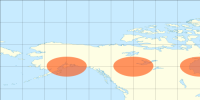
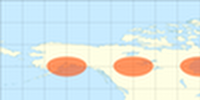
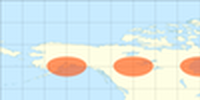
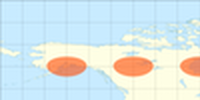
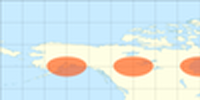
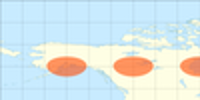
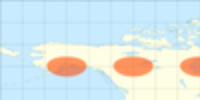
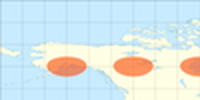
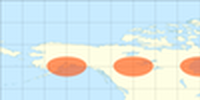
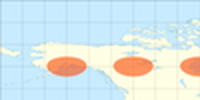
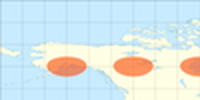
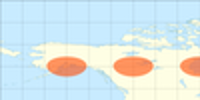
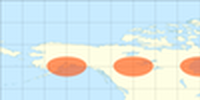
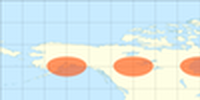
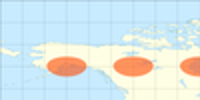
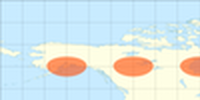
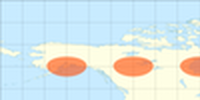
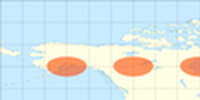
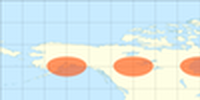
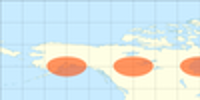
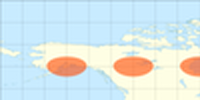
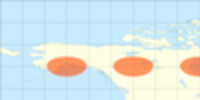
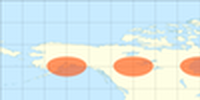
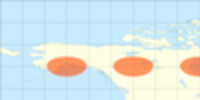
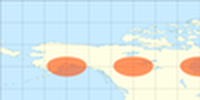
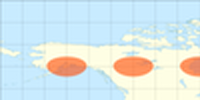

In [173]:
def experiment_compare_upsampling_with_other_libraries(gridscale=2.0) -> None:
  shape = 200, 400
  shape = 400, 800
  # All filtering is done in lightness space (i.e. with gamma='identity').
  original = resampler.resize(
      media.to_float01(example_tissot_image()), shape, filter='trapezoid', dtype=np.float32
  )  # Was 'lanczos5'.
  downsampled_shape_2d = (np.array(shape) / gridscale + 0.5).astype(int)
  array = resampler.resize(original, downsampled_shape_2d, filter='lanczos5')
  if 1:
    array = np.ascontiguousarray(array)  # Compactify, removing cropped X and Y.
  if 0:
    array = np.swapaxes(np.swapaxes(array, 0, 1).copy(), 0, 1)  # Transpose memory layout.
  print(f'{array.dtype} src_shape={array.shape} strides={array.strides} dst_shape={shape}')
  a = array, shape
  funcs: dict[str, Callable[[], _AnyArray]] = {
      'original': lambda: original,
      # 'resize lanczos4': lambda: resampler.resize(*a, filter=resampler.LanczosFilter(radius=4)),
      # 'resample lanczos5': lambda: resampler._resize_using_resample(*a, filter='lanczos5'),
      'resize lanczos5': lambda: resampler.resize(*a, filter='lanczos5'),
      'resize lanczos3': lambda: resampler.resize(*a, filter='lanczos3'),
      # 'resize lanczos3 1thread': lambda: resampler.resize(*a, filter='lanczos3', num_threads=1),
      'resize cardinal3': lambda: resampler.resize(*a, filter='cardinal3'),
      'resize sharpcubic': lambda: resampler.resize(*a, filter='sharpcubic'),
      'resize cubic': lambda: resampler.resize(*a, filter='cubic'),
      'resize triangle': lambda: resampler.resize(*a, filter='triangle'),
      'resize_in_tf lanczos3': lambda: resampler.resize_in_tensorflow(*a, filter='lanczos3'),
      'resize_in_torch lanczos3': lambda: resampler.resize_in_torch(*a, filter='lanczos3'),
      'resize_in_jax lanczos3': lambda: resampler.resize_in_jax(*a, filter='lanczos3'),
      'jaxjit_resize lanczos3': lambda: resampler.jaxjit_resize(*a, filter='lanczos3'),
      'jaxjit_resize cubic': lambda: resampler.jaxjit_resize(*a, filter='cubic'),
      'resample lanczos3': lambda: resampler._resize_using_resample(*a, filter='lanczos3'),
      'PIL.Image.resize lanczos3': lambda: resampler.pil_image_resize(*a, filter='lanczos3'),
      'PIL.Image.resize cubic': lambda: resampler.pil_image_resize(*a, filter='cubic'),
      # 'ndimage.zoom': lambda: scipy.ndimage.zoom(array, (gridscale, gridscale, 1.0)),
      'map_coordinates order=3': lambda: resampler.scipy_ndimage_resize(*a, filter='cardinal3'),
      'skimage.transform.resize': lambda: resampler.skimage_transform_resize(
          *a, filter='cardinal3'
      ),
      'tf.resize lanczos5': lambda: resampler.tf_image_resize(*a, filter='lanczos5'),
      'tf.resize lanczos3': lambda: resampler.tf_image_resize(*a, filter='lanczos3'),
      # 'tf.resize cubic new': lambda: resampler.tf_image_resize(*a, filter='cubic'),  # newer; resize_with_scale_and_translate('keyscubic')
      'tf.resize cubic (aa False)': lambda: resampler.tf_image_resize(
          *a, filter='cubic', antialias=False
      ),  # older; gen_image_ops.resize_bicubic()
      'torch.nn.interp sharpcubic': lambda: resampler.torch_nn_resize(*a, filter='sharpcubic'),
      'torch.nn.interpolate triangle': lambda: resampler.torch_nn_resize(*a, filter='triangle'),
      # 'torch.nn.interp cubic AA': lambda: resampler.torch_nn_resize(*a, filter='sharpcubic', antialias=True),
      # 'torch.nn.interp triangle AA': lambda: resampler.torch_nn_resize(*a, 'filter=triangle', antialias=True),
      'jax.image.resize lanczos3': lambda: resampler.jax_image_resize(*a, filter='lanczos3'),
      'jax.image.resize triangle': lambda: resampler.jax_image_resize(*a, filter='triangle'),
      'cv.resize lanczos4': lambda: resampler.cv_resize(*a, filter='lanczos4'),
      'cv.resize sharpcubic': lambda: resampler.cv_resize(*a, filter='sharpcubic'),
  }
  images = {}
  for name, func in funcs.items():
    if 'jax' in name:
      func()  # Pre-compile/jit the code.
    elapsed, image = hh.get_time_and_result(func, max_time=0.05)
    image = resampler._arr_numpy(image)
    _check_eq(image.dtype, np.float32)
    psnr = get_psnr(image, original)
    name = f'{name}  psnr:{psnr:.2f} dB  ({elapsed * 1000:.2f} ms)'
    images[name] = image

  if 1:  # Optionally crop the images
    images = {name: image[:100, :200] for name, image in images.items()}
  hh.no_vertical_scroll()
  # with media.set_show_save_dir('/tmp'):
  show_args: Any = dict(width=400, columns=5) if hh.in_colab() else dict(width=300, columns=4)
  media.show_images(images, **show_args)


if EFFORT >= 1:
  experiment_compare_upsampling_with_other_libraries()

In [174]:
if EFFORT >= 3:
  experiment_compare_upsampling_with_other_libraries(gridscale=1.9)

Conclusions for upsampling:
- The cardinal spline of `order=3` does as well as `'lanczos3'`.
- `tf.resize` using `'lanczos5'` and `boundary='natural'` is slightly worse
  than `resampler.resize` using `'lanczos5'` and `boundary='reflect'` near the boundary.
- `jaxjit_resize` gives good speedups.
- `resampler.resize` is generally fast, but is not as fast as `torch.nn.interp` for cubic upsampling or
  as fast as OpenCV for cubic and Lanczos upsampling.

## Downsampling comparison

float32 src_shape=(1000, 2000, 3) strides=(24000, 12, 4) dst_shape=(100, 200)



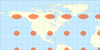
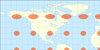
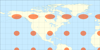
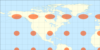
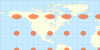
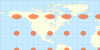
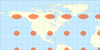
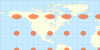
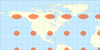
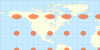
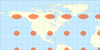
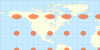
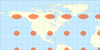
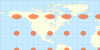
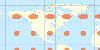
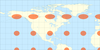
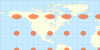
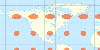
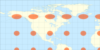
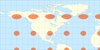
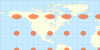
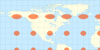
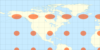
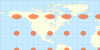
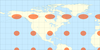
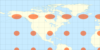
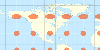
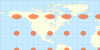

In [175]:
def experiment_compare_downsampling_with_other_libraries(gridscale=0.1, shape=(100, 200)) -> None:
  # All filtering is done in lightness space (i.e. with gamma='identity').
  original_shape_2d = (np.array(shape) / gridscale + 0.5).astype(int)
  original = resampler.resize(
      media.to_float01(example_tissot_image()),
      original_shape_2d,
      filter='lanczos5',
      dtype=np.float32,
  )
  if 1:
    original = np.ascontiguousarray(original)  # Compactify, removing cropped X and Y.
  if 0:
    original = np.swapaxes(np.swapaxes(original, 0, 1).copy(), 0, 1)  # Transpose memory layout.
  array = original
  print(f'{array.dtype} src_shape={array.shape} strides={array.strides} dst_shape={shape}')
  a = array, shape
  funcs: dict[str, Callable[[], _AnyArray]] = {
      # 'resize lanczos5': lambda: resampler.resize(*a, filter='lanczos5'),
      'resize lanczos3': lambda: resampler.resize(*a),
      # 'resize lanczos3 1thread': lambda: resampler.resize(*a, num_threads=1),
      'resize cardinal3': lambda: resampler.resize(*a, filter='cardinal3'),
      'resize cubic': lambda: resampler.resize(*a, filter='cubic'),
      'resize triangle': lambda: resampler.resize(*a, filter='triangle'),
      'resize trapezoid': lambda: resampler.resize(*a, filter='trapezoid'),
      'resize box': lambda: resampler.resize(*a, filter='box'),
      'resize_in_tf lanczos3': lambda: resampler.resize_in_tensorflow(*a),
      'resize_in_tf trapezoid': lambda: resampler.resize_in_tensorflow(*a, filter='trapezoid'),
      'resize_in_torch lanczos3': lambda: resampler.resize_in_torch(*a),
      'resize_in_torch trapezoid': lambda: resampler.resize_in_torch(*a, filter='trapezoid'),
      'resize_in_jax lanczos3': lambda: resampler.resize_in_jax(*a),
      'resize_in_jax trapezoid': lambda: resampler.resize_in_jax(*a, filter='trapezoid'),
      'jaxjit_resize lanczos3': lambda: resampler.jaxjit_resize(*a, filter='lanczos3'),
      'jaxjit_resize trapezoid': lambda: resampler.jaxjit_resize(*a, filter='trapezoid'),
      'resample lanczos3': lambda: resampler._resize_using_resample(*a, filter='lanczos3'),
      'PIL.Image.resize lanczos3': lambda: resampler.pil_image_resize(*a, filter='lanczos3'),
      # 'PIL.Image.resize cubic': lambda: resampler.pil_image_resize(*a, filter='cubic'),
      'PIL.Image.resize box': lambda: resampler.pil_image_resize(*a, filter='box'),
      # 'ndimage.zoom': lambda: scipy.ndimage.zoom(array, (gridscale, gridscale, 1.0)),
      'map_coordinates order=3': lambda: resampler.scipy_ndimage_resize(*a, filter='cardinal3'),
      'skimage.transform.resize': lambda: resampler.skimage_transform_resize(
          *a, filter='cardinal3'
      ),
      'tf.resize lanczos3': lambda: resampler.tf_image_resize(*a, filter='lanczos3'),
      'tf.resize trapezoid': lambda: resampler.tf_image_resize(*a, filter='trapezoid'),
      # 'torch.nn.interpolate cubic': lambda: resampler.torch_nn_resize(*a, filter='sharpcubic'),
      # 'torch.nn.interpolate triangle': lambda: resampler.torch_nn_resize(*a, filter='triangle'),
      'torch.nn.interp cubic AA': lambda: resampler.torch_nn_resize(
          *a, filter='sharpcubic', antialias=True
      ),
      'torch.nn.interp triangle AA': lambda: resampler.torch_nn_resize(
          *a, filter='triangle', antialias=True
      ),
      'torch.nn.interp trapezoid': lambda: resampler.torch_nn_resize(*a, filter='trapezoid'),
      'jax.image.resize lanczos3': lambda: resampler.jax_image_resize(*a, filter='lanczos3'),
      'jax.image.resize triangle': lambda: resampler.jax_image_resize(*a, filter='triangle'),
      'cv.resize lanczos4': lambda: resampler.cv_resize(*a, filter='lanczos4'),  # Aliased.
      'cv.resize trapezoid': lambda: resampler.cv_resize(*a, filter='trapezoid'),
  }
  images = {}
  for name, func in funcs.items():
    func()  # Pre-compile/jit the code.
    elapsed, image = hh.get_time_and_result(func, max_time=0.05)
    image = resampler._arr_numpy(image)
    upsampled = resampler._original_resize(image, original.shape[:2], filter='lanczos5')
    psnr = get_psnr(upsampled, original)
    name = f'{name}  psnr:{psnr:.2f} dB  ({elapsed * 1000:.2f} ms)'
    images[name] = image

  if 1:  # Optionally crop the images
    images = {name: image[:50, :100] for name, image in images.items()}
  hh.no_vertical_scroll()
  # with media.set_show_save_dir('/tmp'):
  show_args: Any = dict(width=400, columns=5) if hh.in_colab() else dict(width=300, columns=4)
  media.show_images(images, **show_args)


if EFFORT >= 1:
  experiment_compare_downsampling_with_other_libraries()

In [176]:
# Occasional Numba error in 'resize trapezoid' when invoking jitted_function(a):
# RuntimeError: In 'NRT_adapt_ndarray_to_python', 'descr' is NULL.
# The solution was to delete resampler/__pycache__.

In [177]:
if EFFORT >= 3:
  experiment_compare_downsampling_with_other_libraries(gridscale=1 / 8)
  experiment_compare_downsampling_with_other_libraries(gridscale=0.1007)

In [178]:
def test_downsample_timing() -> None:
  """Check that we account for strides in `_arr_best_dims_order_for_resize()`."""
  for with_copy in [False, True]:
    for shape in [(1000, 2000), (900, 1800), (800, 1600)]:
      array = media.to_float01(example_tissot_image())
      array = resampler.resize(array, shape, filter='lanczos5', dtype=np.float32)
      if with_copy:
        array = np.ascontiguousarray(array)  # Like copy(), it keeps a stride of 4.
      print(f'{array.dtype} {array.shape!s:<16} {array.strides!s:<16}: ', end='')
      hh.print_time(
          lambda: resampler.resize(array, (100, 200), filter='lanczos3', boundary='reflect'),
          max_time=0,
      )


test_downsample_timing()

float32 (1000, 2000, 3)  (24000, 12, 4)  : 5.85 ms
float32 (900, 1800, 3)   (12, 10800, 4)  : 7.19 ms
float32 (800, 1600, 3)   (12, 9600, 4)   : 5.02 ms
float32 (1000, 2000, 3)  (24000, 12, 4)  : 9.19 ms
float32 (900, 1800, 3)   (21600, 12, 4)  : 8.13 ms
float32 (800, 1600, 3)   (19200, 12, 4)  : 5.87 ms


Conclusions for downsampling:
- The `ndimage` library does not apply prefiltering when downsampling and therefore
  introduces aliasing.
- With `ndimage`, it is difficult to create the right transform / coords to exactly resize
  a 'dual' grid.
  The `zoom()` in the more recent `scipy` has new `grid_mode='True'` to assist with this.
- The `torch.nn` requires `antialias=True` for prefiltering.
- The `skimage.transform.resize` also requires `anti_aliasing=True` and it introduces a
  Gaussian prefilter which prevents aliasing but is blurry.
- OpenCV's best downsampling filter is `AREA`, which is not as sharp as a Lanczos filter.
- The `resampler.resize` box-filtering (using `numba`) is as fast as the C++
  `tf.image.resize` and `OpenCV` implementations.
- `resampler.resize` achieves the fastest downsampling with a Lanczos filter.

## Elongated arrays

In [179]:
def test_elongated_arrays():
  shape, new_shape = (100, 3000), (100, 2000)
  image = np.ones(shape, np.float32)
  filter = 'triangle'  # Or 'cubic_like'.
  for name, resize in resampler._RESIZERS.items():
    print(f'# {name:32}: ', end='')
    filter2 = resampler._find_closest_filter(filter, resize)
    hh.print_time(lambda: resize(image, new_shape, filter=filter2), max_time=0.1)


if 0:
  test_elongated_arrays()

# resampler.resize                : 865 µs
# PIL.Image.resize                : 617 µs
# cv.resize                       : 50.6 µs
# scipy.ndimage.map_coordinates   : 5.39 ms
# skimage.transform.resize        : 3.24 ms
# tf.image.resize                 : 2.69 ms
# torch.nn.functional.interpolate : 237 µs
# jax.image.scale_and_translate   : 72.6 ms

# Note the large overhead in jax.image.scale_and_translate due to the creation of a dense weight
# matrix for use with jax.np.einsum.

In [180]:
# hh.prun(lambda: resampler.resize(np.ones((100, 3000), 'f'), (100, 2000), filter='triangle'))
# The overhead is in _create_resize_matrix().

## Boundary comparison

**resampler.resize:**

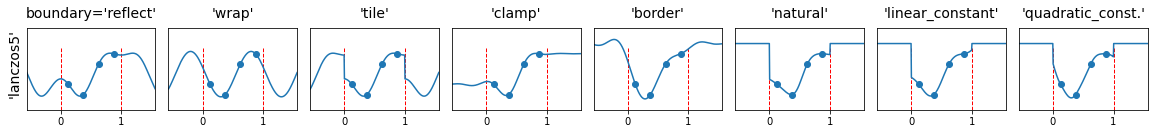

**cv.resize:**

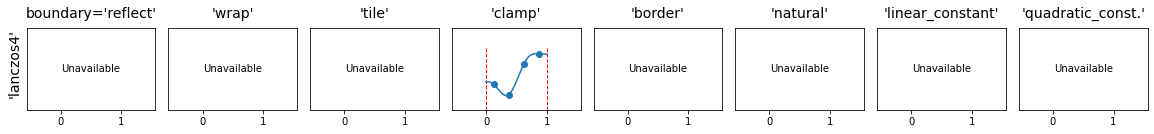

**scipy.ndimage.map_coordinates:**

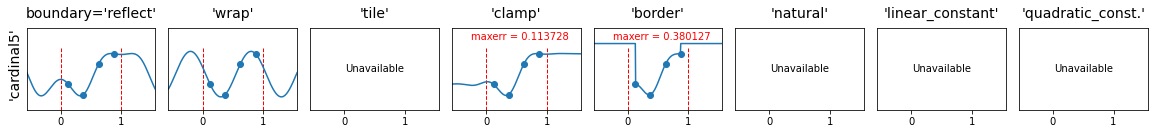

**skimage.transform.resize:**

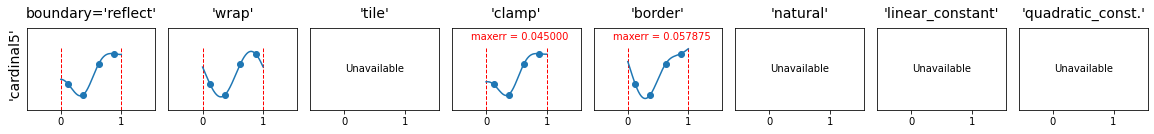

**tf.image.resize:**

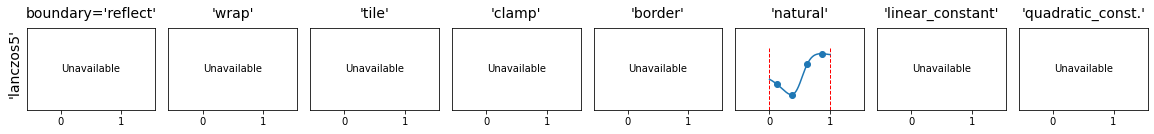

**torch.nn.functional.interpolate:**

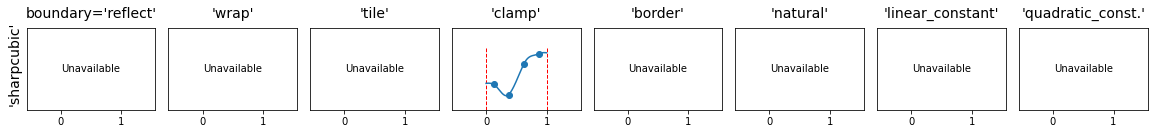

**jax.image.scale_and_translate:**

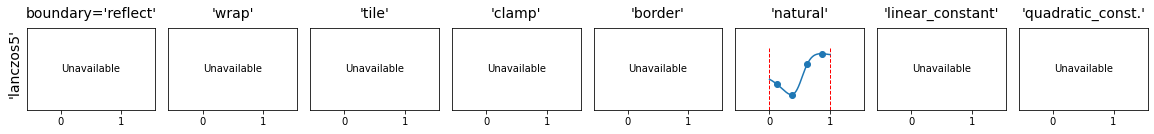

In [181]:
def visualize_boundary_rules_across_libraries(*, filter='triangle', cval=0.0) -> None:
  """Compare 1D boundary rules across libraries."""
  hh.no_vertical_scroll()
  for name, resize in resampler._RESIZERS.items():
    display_markdown(f'**{name}:**')
    visualize_boundary_rules_in_1d(resizer=resize, filters=[filter], cval=cval)


if EFFORT >= 1:
  visualize_boundary_rules_across_libraries(filter='high_quality', cval=0.6)

# The grid below let us identify what boundary conditions are implemented in the other libraries.
# The results generally match ours.

# The discrepancy for filter='cardinal5' and filter='clamp','border' may be due to the interaction
# of the digital filter and the boundary clamp extension, e.g., which comes first.

# For `jax.image.scale_and_translate`, the value of the function outside the unit domain is
# automatically assigned to zero, so we only enable scale and translation with `cval=0.0`,
# as shown in the next example.

**resampler.resize:**

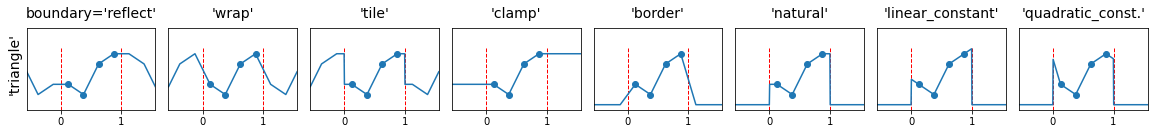

**cv.resize:**

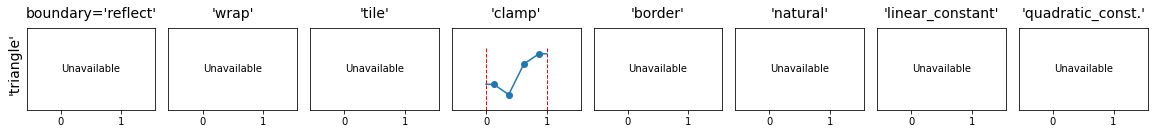

**scipy.ndimage.map_coordinates:**

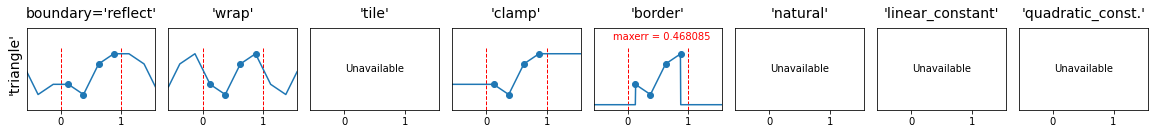

**skimage.transform.resize:**

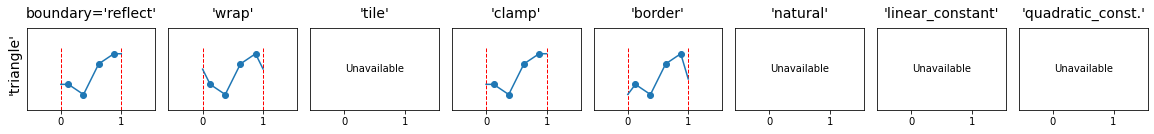

**tf.image.resize:**

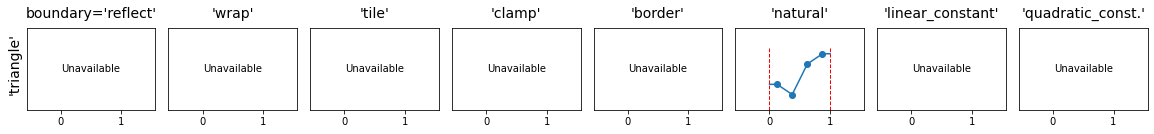

**torch.nn.functional.interpolate:**

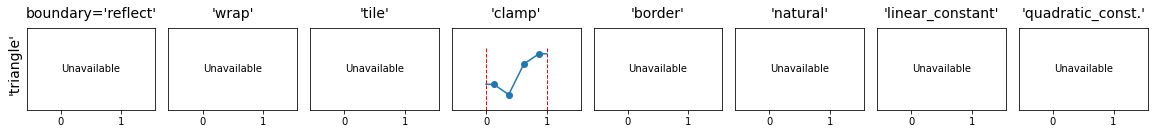

**jax.image.scale_and_translate:**

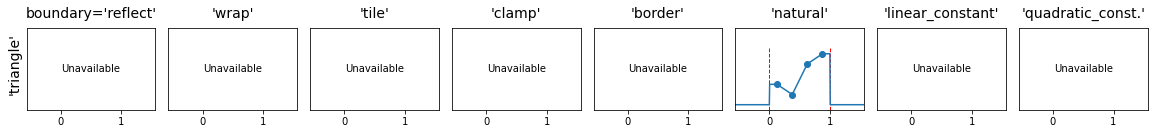

In [182]:
if EFFORT >= 1:
  visualize_boundary_rules_across_libraries(filter='triangle', cval=0.0)

# Note that for triangle='filter' (as well as 'box_like'), the function value within the domain
# interior is the same for boundary in ['reflect', 'clamp', 'natural'], so we cannot deduce what
# boundary condition is implemented in the other libraries in this particular case.

# There is a discrepancy between our boundary='border' and that in `scipy.ndimage.map_coordinates`.
# Our 'border' definition overrides values of the sample values outside the domain.
# Their 'border' definition overrides the value of the reconstructed function immediately beyond
# the last domain-interior samples.
# It seems that our definition matches that of `skimage.transform.resize`.

In [183]:
if EFFORT >= 2:
  visualize_boundary_rules_across_libraries(filter='box_like', cval=0.6)

# Again, everything matches, including the same discrepancy for boundary='border' in
# `scipy.ndimage.map_coordinates` that we saw earlier with filter='triangle'.

In [184]:
if EFFORT >= 2:
  visualize_boundary_rules_across_libraries(filter='cubic_like', cval=0.6)

# Again, everything matches, except for the discrepancies observed earlier in filter='high_quality'.

# Run external tools

In [185]:
def run_lint() -> None:
  """Run checks on *.py notebook code (saved using jupytext or from menu)."""
  if pathlib.Path('resampler_notebook.py').is_file():
    # On SageMaker Studio Lab, if autopep8 sees ~/.config/pycodestyle, ./pyproject.toml is ignored.
    hh.run('echo autopep8; autopep8 --global-config skip -j8 -d .')
    hh.run('echo pyink; pyink --diff .')
    hh.run('echo mypy; mypy . || true')
    hh.run('echo pylint; pylint -j8 . || true')


if EFFORT >= 2:
  run_lint()

In Windows Emacs, use `compile` command:
```shell
c:/windows/sysnative/wsl -e bash -lc 'echo autopep8; autopep8 -j8 -d .; echo pyink; pyink --diff .; echo mypy; mypy .; echo pylint; pylint -j8 .; echo All ran.'
```

In [186]:
# Remember to increment __version__ to allow a new pypi package.


def build_and_upload_pypi_package() -> None:
  """Build and upload a PyPI package.  (Instead, this is normally performed as a GitHub action.)"""
  if 0:
    hh.run('git clone -q https://github.com/hhoppe/resampler')
  if 0:
    hh.run('(sudo apt update && sudo apt install -y python3.10-venv)')
  hh.run('pip install -q build')
  hh.run('rm dist/*')
  hh.run('python3 -m build')  # Creates dist/*.
  if 0:
    hh.run('pip install -q twine')
    hh.run('python3 -m twine upload dist/*')  # Uploads to pypi.org.
  print('Update should be visible soon at https://pypi.org/project/resampler/.')


if 0:
  build_and_upload_pypi_package()

In [187]:
def create_documentation_files() -> None:
  """Locally create pdoc HTML.  (Instead, this is normally performed as a GitHub action.)

  Note: Automated this on GitHub by using .github/workflows/docs.yml so ./docs is never stored in
  repo and there is no need for a gh-pages branch; enabled GitHub Pages from 'main' branch at '/';
  modified Action permissions to prevent pages-build-deployment bot action --
  see https://github.com/mitmproxy/pdoc/issues/414.
  """
  if 0:
    hh.run('pip install pdoc')
  # Used https://www.xiconeditor.com/ to upload 4-channel png and save *.ico .
  # Use custom template ./pdoc/module.html.jinja2 and output ./docs/*.
  # hh.run('pdoc --math -t ./pdoc_files -o ./docs ./resampler --logo https://github.com/hhoppe/resampler/raw/main/pdoc_files/logo.png --favicon https://github.com/hhoppe/resampler/raw/main/pdoc_files/favicon.ico --logo-link https://hhoppe.github.io/resampler/resampler.html')
  # To run interactively in web browser, just omit '-o ./docs'.
  hh.run('pdoc_files/make.py')


if 0:
  create_documentation_files()

# Epilog

In [188]:
hh.analyze_functools_caches(globals())

# example_tissot_image                      1/inf        0.875 hit=            7 miss=            1
# example_vector_graphics_image             1/inf        0.750 hit=            3 miss=            1


In [189]:
def show_added_global_variables_sorted_by_type() -> None:
  ok_typenames = (
      '_GenericAlias _SpecialGenericAlias partial type function _lru_cache_wrapper CPUDispatcher'
  ).split()
  for typename, name in sorted((type(value).__name__, name) for name, value in globals().items()):
    is_ok = (
        name in _ORIGINAL_GLOBALS
        or name.startswith(('_', 'test_', 'visualize_'))
        or typename in ok_typenames
        or (len(name) >= 6 and name.upper() == name)
        or name in ''.split()
    )
    if not is_ok:
      print(f'# {typename:24} {name}')


show_added_global_variables_sorted_by_type()

In [190]:
print(f'# {EFFORT=}')
hh.show_notebook_cell_top_times()
# EFFORT=1:
# Local: ~48 s.
# Colab: ~170 s
# Kaggle: ~88 s.
# MyBinder: ~80 s.
# DeepNote: ~74 s.

# EFFORT=1
# Total time: 121.96 s
# In[101] if EFFORT >= 1:\n  test_profile_upsampling((1024, 1024, 1), 12.051 s
# In[175] def experiment_compare_downsampling_with_other_libraries(   11.094 s
# In[ 98] def test_profile_downsampling(\n    shape, new_shape,        8.522 s
# In[173] def experiment_compare_upsampling_with_other_libraries(      6.552 s
# In[115] def experiment_shear_image(\n    downscale=4, degrees=30,    4.709 s
# In[130] if EFFORT >= 1:\n  visualize_filters({f"\'{name}\'":         4.207 s
# In[ 84] def test_jit_timing() -> None:\n  indptr, indices, data =    3.759 s
# In[ 38] hh.pdoc_help(resampler.resize)\nhh.no_vertical_scroll()      3.541 s
# In[ 62] def test_that_all_resize_and_resample_agree(shape=(3, 2, 2)  3.521 s
# In[157] def visualize_prefiltering_as_scale_is_varied(\n    shape=(  3.316 s
# In[112] def experiment_zoom_image(original_image, num_frames=60) ->  3.299 s
# In[161] def test_inverse_convolution_2d(\n    gridscale=2.0,         2.923 s
# In[159] def expe

In [191]:
# EFFORT=0
# Total time: 15.08 s
# In[ 39] hh.pdoc_help(resampler.resize)\nmedia.set_max_output_        3.358 s
# In[181] def visualize_prefiltering_a_discontinuity_in_1D(size=400,   1.018 s
# In[ 16] _URL_BASE = 'https://github.com/hhoppe/data/raw/main'        0.843 s

# EFFORT=1
# Total time: 98.59 s
# In[203] def experiment_compare_downsampling_with_other_libraries(    6.207 s
# In[201] def experiment_compare_upsampling_with_other_libraries(      4.948 s
# In[127] def test_profile_downsampling(\n    shape, new_shape,        4.888 s
# In[144] def experiment_shear_image(degrees=30, show_compare=False,   3.774 s
# In[130] if EFFORT >= 1:\n  test_profile_upsampling((1024, 1024, 1),  3.723 s
# In[141] def experiment_zoom_image(original_image, num_frames=60) ->  3.718 s
# In[159] if EFFORT >= 1:\n  visualize_filters({f"\'{name}\'":         3.713 s
# In[ 39] hh.pdoc_help(resampler.resize)\nmedia.set_max_output_        3.563 s
# In[187] def test_inverse_convolution_2d(\n    gridscale=2.0,         3.205 s
# In[183] def visualize_prefiltering_as_scale_is_varied(\n    shape=(  2.845 s
# In[185] def experiment_with_convolution() -> None:\n  # https://     2.696 s
# In[180] def get_text_image(shape=(200,) * 2) -> _NDArray:\n  image   2.689 s
# In[168] def compare_boundary_rules_on_cropped_windows_of_images(\n   2.613 s
# In[114] # This analysis is only for 1D resize; it fails to account   2.557 s
# In[ 83] def test_that_all_resize_and_resample_agree(shape=(3, 2, 2)  2.539 s
# In[161] if EFFORT >= 1:\n  visualize_filter_frequency_response(\n    2.285 s
# In[145] def test_tensorflow_optimize_image_for_desired_upsampling(   2.216 s
# In[148] def test_jax_optimize_image_for_desired_upsampling(\n        2.060 s
# In[108] def test_jax_image_resize() -> None:\n  at_boundaries = [    1.716 s
# In[ 66] def test_that_resize_matrices_are_equal_across_arraylib() -  1.709 s

# EFFORT=2
# Total time: 974.02 s
# In[156] def experiment_find_the_best_max_block_size(src_size=64,    304.242 s
# In[168] def compare_boundary_rules_on_cropped_windows_of_images(\n  144.282 s
# In[124] def test_best_dimension_ordering_for_resize_timing(dtype=   124.535 s
# In[125] def experiment_with_resize_timing() -> None:\n  def run(    95.221 s
# In[127] def test_profile_downsampling(\n    shape, new_shape,       60.157 s
# In[214] def run_lint() -> None:\n  """Run checks on *.py notebook   43.398 s
# In[123] def test_gamma_conversion_from_and_to_uint8_timings() ->    35.702 s
# In[ 83] def test_that_all_resize_and_resample_agree(shape=(3, 2, 2) 19.013 s
# In[132] if EFFORT >= 2:\n  test_profile_upsampling((1024, 1024, 3), 18.524 s
# In[185] def experiment_with_convolution() -> None:\n  # https://    15.716 s
# In[187] def test_inverse_convolution_2d(\n    gridscale=2.0,         9.414 s
# In[ 53] def test_profile_resample() -> None:\n  def run(src_shape,   6.433 s
# In[205] def experiment_compare_downsampling_with_other_libraries(    5.709 s
# In[126] def test_compare_timing_of_resize_and_media_show_image() ->  4.827 s
# In[203] def experiment_compare_upsampling_with_other_libraries(      4.756 s
# In[130] if EFFORT >= 1:\n  test_profile_upsampling((1024, 1024, 1),  3.689 s
# In[159] if EFFORT >= 1:\n  visualize_filters({f"\'{name}\'":         3.567 s
# In[144] def experiment_shear_image(degrees=30, show_compare=False,   3.507 s
# In[179] def experiment_visualize_gamma_upsample_video(shape=(24, 48  3.497 s
# In[141] def experiment_zoom_image(original_image, num_frames=60) ->  3.369 s

# EFFORT=3
# Total time: 1056.34 s

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->